# Final Project Machine Learning
**Lilach Cohen & Noa Levy** - group 24


### Imports

In [219]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.resetwarnings()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc, roc_auc_score , roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import f_classif, SelectKBest, chi2
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

#ended up not using for final model:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
#
from sklearn.linear_model import  LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier





### Import the data

In [220]:
def read_csv(train_name_csv, test_name_csv):
    #read train and test csv
    data = pd.read_csv(train_name_csv)
    test_data = pd.read_csv(test_name_csv)
    return data, test_data

data = pd.read_csv('train.csv')


### Train test split

In [221]:
def train_validation_split(data):
    X = data.drop('label', axis=1)
    y = data['label']
    X_train_n, X_test_n, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42, shuffle = True)
    #n stands for not scaled
    # x_test, y_test is our validation set :)
    return X_train_n, X_test_n, y_train, y_test

In [222]:
X_train_n, X_test, y_train, y_test = train_validation_split(data)


### Utility Functions

In [223]:
# scaling the data
def scaling_data (train , test):
    sc = StandardScaler() 
    return pd.DataFrame(sc.fit_transform(train)), pd.DataFrame(sc.transform(test))

# categorical features data exploration
def categorial_dist(data , col_name ):
    uniques , counts , sorted_indices = count_sort(data , col_name)
    n = len(uniques)
    print ('there are %d unique values:' %n)
    for i in range(n):
        print (uniques[sorted_indices[n-i-1]] , counts[sorted_indices[n-i-1]] ,'samples \n') 
    print('the median is: ' ,np.median(counts))
    return

def count_sort(data , col_name):
    data[col_name] = data[col_name].astype(str)
    uniques , counts = np.unique(data[col_name], return_counts = True)
    sorted_indices = np.argsort(counts)
    return  uniques , counts, sorted_indices

# outlier handling categorical features
def reduce_to_top_k_indices(train, test , col_name, k, bool):
    u , c  , sorted_indices = count_sort(train , col_name)
    top_k = u[sorted_indices[-k:]]
    print('reducing to %d values means %d different values in %d rows will be classified as other,\n losing %.2f precent of the data \n the most common value is %s with %d rows' % 
        (k ,len(c[sorted_indices[:-k]]) , np.sum(c[sorted_indices[:-k]]) ,((np.sum(c[sorted_indices[:-k]]) / np.sum(c)) *100), u[sorted_indices[-k-1]], c[sorted_indices[-k-1]]))
    if bool:
        train.loc[~train[col_name].isin(top_k), col_name] = 'other'
        test.loc[~test[col_name].isin(top_k), col_name] = 'other'
        return  train , test
    else :
        return 
       

# numeric features outlier handeling

# Capping & Inter-Quartile Range (IQR)
def outliers_handling(feature, df_source, df_target):
    #finding the Q1(25 percentile) and Q3(75 percentile)
    q1 = df_source[feature].quantile(0.25)
    q2 = df_source[feature].quantile(0.75)
    #finding out the value of Inter Quartile Range
    IQR = q2 - q1
    #defining max and min limits
    max_limit = q2 + (1.5 * IQR)
    min_limit = q1 - (1.5 * IQR) 
    #capping
    df_target.loc[df_target[feature] > max_limit, feature] = max_limit
    df_target.loc[df_target[feature] < min_limit, feature] = min_limit
        
# percentile method
def outliers_handling_precentile(feature, p , df_source, df_target):
    #set quantile himslf  if upper limit is 99% and we have to look 1 % in lower quantile
    upper_limit = df_source[feature].quantile(p)
    lower_limit = df_source[feature].quantile(1-p)
    #removing outliers
    df_target.loc[df_target[feature] > upper_limit, feature] = upper_limit
    df_target.loc[df_target[feature] < lower_limit, feature] = lower_limit

# evaluating models
# finding AUC and ROC
# https://www.kaggle.com/code/akbarhuseynov23/roc-and-auc
def get_AUC (test_proba, y_test, model , dr_method):
    test_proba = test_proba[:, 1]
    auc = roc_auc_score(y_test, test_proba)
    print('for %s model, with: %s AUROC = %.3f' % (model , dr_method ,auc) )

def get_ROC(test_proba , y_test, model , dr_method):
    test_proba = test_proba[:, 1]
    clf_fpr, clf_tpr, _ = roc_curve(y_test, test_proba)
    auc = roc_auc_score(y_test, test_proba)
    plt.figure(figsize=(12, 8))
    plt.plot(clf_fpr, clf_tpr, linestyle='--', label='%s with %s prediction (AUC = %0.3f)' % (model ,dr_method, auc))
    plt.title('ROC Plot')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()  
    plt.show()

# fit a model using k-fold cross-validation and create a ROC plot that includes each fold.
# for models that dont have gridsearchcv
def fit_with_kfold_get_roc2(model, X, y,test , n =5):
    skf = StratifiedKFold(n_splits=n)
    fig, ax = plt.subplots()
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
        
        # Perform k-fold cross-validation
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Split the data into training and validation sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f"ROC fold {i+1} (AUC = {roc_auc:.2f})")
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)
    
    proba = model.predict_proba(test)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr,color='pink',label=f"Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})")
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves')
    ax.legend(loc="lower right")
    plt.show()
    return proba

# fit a model using k-fold cross-validation and create an ROC plot that includes each fold.
def fit_with_kfold_get_roc(model, X, y,n =5):
    skf = StratifiedKFold(n_splits=n)
    fig, ax = plt.subplots()
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
        
        # Perform k-fold cross-validation
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Split the data into training and validation sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f"ROC fold {i+1} (AUC = {roc_auc:.2f})")
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr,color='pink',label=f"Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})")
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves')
    ax.legend(loc="lower right")
    plt.show()
    return 

# confusion matrix
def create_confusion_matrix(y_test, y_predict):
    cm = confusion_matrix(y_test, y_predict)  # y_test is the actual test labels, proba is from the random_forest the y_predict
    TN = cm[1, 1]  # True negatives
    FP = cm[0, 1]  # False positives
    FN = cm[1, 0]  # False negatives
    TP = cm[0, 0]  # True positives 
    print("True Positives (TP):", TP)
    print("False Positives (FP):", FP)
    print("True Negatives (TN):", TN)
    print("False Negatives (FN):", FN)
    recall= TP/(TP+FN)
    precision= TP/(TP+FP)
    accuracy= (TP+TN)/(TP+FP+TN+FN)
    print("recall\sensitivity:", recall)
    print("precision:", precision)
    print("accuracy:", accuracy)
        
    plt.figure(figsize=(8, 6))  # Set the figure size
    # Use seaborn's heatmap to create the plot
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=True, yticklabels=True)
    plt.title("Confusion Matrix")  # Set the title
    plt.xlabel("Predicted Labels")  # Set the x-axis label
    plt.ylabel("True Labels")  # Set the y-axis label
    plt.show()  # Display the plot
    return




<>:109: DeprecationWarning: invalid escape sequence '\p'
<>:145: DeprecationWarning: invalid escape sequence '\p'
<>:170: DeprecationWarning: invalid escape sequence '\s'
<>:109: DeprecationWarning: invalid escape sequence '\p'
<>:145: DeprecationWarning: invalid escape sequence '\p'
<>:170: DeprecationWarning: invalid escape sequence '\s'
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2512127471.py:109: DeprecationWarning: invalid escape sequence '\p'
  ax.plot(mean_fpr, mean_tpr,color='pink',label=f"Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})")
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2512127471.py:145: DeprecationWarning: invalid escape sequence '\p'
  ax.plot(mean_fpr, mean_tpr,color='pink',label=f"Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})")
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2512127471.py:170: DeprecationWarning: invalid escape sequence '\s'
  print("recall\sensitivity:", recall)


# Data Understanding & Exploration

In this section we will gather basic information about the data

### First Look

Create a unified data set 'train' to examine the data.

In [224]:
train = X_train_n.copy()
train['label'] = y_train

Trying to gather basic information about the dataset.

We used this fuctions to get some insights. 

This functions allowed us to see a few (first 5) rows from the train data set, and get basic statistics about each feature.

In [225]:
train.head()


sha256     size     vsize  \
48572  d803a8f442f442017e6815739015092e268bbaebe03673...   600848  638976.0   
38696  de0d2b805c9abb1d19f223acf3f34b7681f4bd695a9dcc...  1102936  180224.0   
13611  75251fe495a1fd1b9eda0bf74ce563af2546e81840ceff...   431944  188416.0   
35213  82bc6cef016c8ec65a3b0ac864d96ac8c7afad3b9626cb...   873472  991232.0   
31766  ea3cca79a0898e1c30378670c29f4ee9de664323a65a00...    48055  217088.0   

       imports  exports  has_debug  has_relocations  has_resources  \
48572    209.0      0.0        0.0              1.0            1.0   
38696    122.0      NaN        0.0              0.0            1.0   
13611      NaN      0.0        0.0              0.0            1.0   
35213     88.0      0.0        0.0              0.0            1.0   
31766    155.0      0.0        0.0              0.0            1.0   

       has_signature  has_tls  ...  registry    MZ  printables   avlength  \
48572            1.0      1.0  ...       NaN   1.0     64130.0  11.915645   
38696            1.0      0.0  ...       0.0  17.0     30989.0   6.360632   
13611            1.0      0.0  ...       0.0   9.0     15523.0        NaN   
35213            0.0      0.0  ...       5.0   1.0      5445.0  16.157270   
31766            0.0      0.0  ...       0.0   NaN      4668.0        NaN   

                                  file_type_trid  file_type_prob_trid  \
48572   Win32 EXE PECompact compressed (generic)                 47.5   
38696   Win32 Executable MS Visual C++ (generic)                 38.8   
13611  NSIS - Nullsoft Scriptable Install System                 94.8   
35213   Win32 Executable MS Visual C++ (generic)                 37.8   
31766  NSIS - Nullsoft Scriptable Install System                 94.6   

              A         B    C  label  
48572 -1.671498  5.869204   er      0  
38696 -4.373939  6.541799   er      0  
13611 -0.250451  6.433637   mc      0  
35213  0.634696  5.136413  gow      1  
31766  2.224836  5.590438   vh      1  

[5 rows x 24 columns]

In [226]:
train.describe()

size         vsize       imports       exports     has_debug  \
count  4.800000e+04  4.646800e+04  46591.000000  46321.000000  45645.000000   
mean   1.487790e+06  1.983077e+06    106.071602     30.137778      0.404031   
std    4.527823e+06  2.222179e+07    209.175454    507.278529      0.490709   
min    2.980000e+02  5.440000e+02      0.000000      0.000000      0.000000   
25%    1.089920e+05  1.228800e+05      1.000000      0.000000      0.000000   
50%    4.843520e+05  4.218880e+05     28.000000      0.000000      0.000000   
75%    1.231360e+06  1.601536e+06    152.000000      0.000000      1.000000   
max    3.253537e+08  4.278288e+09  15047.000000  48840.000000      1.000000   

       has_relocations  has_resources  has_signature       has_tls  \
count     45341.000000   46418.000000   46445.000000  45650.000000   
mean          0.542180       0.860033       0.253310      0.234020   
std           0.498223       0.346957       0.434912      0.423389   
min           0.000000       0.000000       0.000000      0.000000   
25%           0.000000       1.000000       0.000000      0.000000   
50%           1.000000       1.000000       0.000000      0.000000   
75%           1.000000       1.000000       1.000000      0.000000   
max           1.000000       1.000000       1.000000      1.000000   

             symbols  ...         paths          urls      registry  \
count   45901.000000  ...  45058.000000  46126.000000  45980.000000   
mean       41.238862  ...      1.636979     12.454668      0.435907   
std      1319.018297  ...     35.926116     75.684864     12.603688   
min         0.000000  ...      0.000000      0.000000      0.000000   
25%         0.000000  ...      0.000000      0.000000      0.000000   
50%         0.000000  ...      0.000000      0.000000      0.000000   
75%         0.000000  ...      1.000000     10.000000      0.000000   
max    181660.000000  ...   5324.000000   9387.000000   2492.000000   

                 MZ    printables       avlength  file_type_prob_trid  \
count  45540.000000  4.585300e+04   45816.000000         48000.000000   
mean      15.972310  1.200620e+05      31.531482            53.695633   
std       71.821684  5.596747e+05    1063.949689            20.640742   
min        1.000000  5.000000e+00       5.000000            17.500000   
25%        1.000000  6.062000e+03       7.447368            38.400000   
50%        4.000000  2.287100e+04      12.026422            43.300000   
75%       11.000000  7.668300e+04      17.324120            69.400000   
max     5449.000000  5.034687e+07  207990.925620           100.000000   

                  A             B         label  
count  45041.000000  44925.000000  48000.000000  
mean       3.994959      5.810068      0.500313  
std        6.379257      0.641098      0.500005  
min      -17.783199      0.004929      0.000000  
25%       -0.325612      5.470740      0.000000  
50%        3.638574      5.854641      1.000000  
75%        7.851833      6.340478      1.000000  
max       43.926598      6.584937      1.000000  

[8 rows x 21 columns]

In [227]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 48572 to 56422
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sha256               48000 non-null  object 
 1   size                 48000 non-null  int64  
 2   vsize                46468 non-null  float64
 3   imports              46591 non-null  float64
 4   exports              46321 non-null  float64
 5   has_debug            45645 non-null  float64
 6   has_relocations      45341 non-null  float64
 7   has_resources        46418 non-null  float64
 8   has_signature        46445 non-null  float64
 9   has_tls              45650 non-null  float64
 10  symbols              45901 non-null  float64
 11  numstrings           45825 non-null  float64
 12  paths                45058 non-null  float64
 13  urls                 46126 non-null  float64
 14  registry             45980 non-null  float64
 15  MZ                   45540 non-n

Based on the information we have about the features, we devided them to 3 classes of information- numeric, binary and categorial. 

Also, based on feature information we received with the data, we know we can remove the column 'sha256'. this column contains a unique identifier for each file, we know that each row in the data is a different file and therefore we don't need this column.


In [228]:
def drop_sha(X_train_n, X_test_n):   
    X_train_n.drop(['sha256'], axis = 1, inplace= True)
    X_test_n.drop(['sha256'], axis = 1, inplace= True)


In [229]:

    
def create_subgroups():
    #divinding the feautures by type
    categorical = ['file_type_trid', 'C']
    numeric = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'paths'
            , 'urls', 'registry', 'MZ','printables', 'avlength', 'A','B','file_type_prob_trid']
    #we know from the feature information that this features are binary
    binary =['has_debug','has_relocations', 'has_resources', 'has_signature', 'has_tls']
    return categorical, numeric, binary



In [230]:
drop_sha(X_train_n, X_test)
categorical, numeric, binary = create_subgroups()

### Identifying correlative behavior between features - 

we created 3 correlation matrices to see correlation between different features:

Firstly, correlation matrix on the complete train dataset - 



    we noticed that there is a high correlation between the variables 'size', 'numstrings' and between 'size', 'MZ' and between 'numstrings' and 'MZ'. 
    
    From this we got an intuition that maybe later on we could remove some of the features to reduce dimensionality without harming the prediction.

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1396644000.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


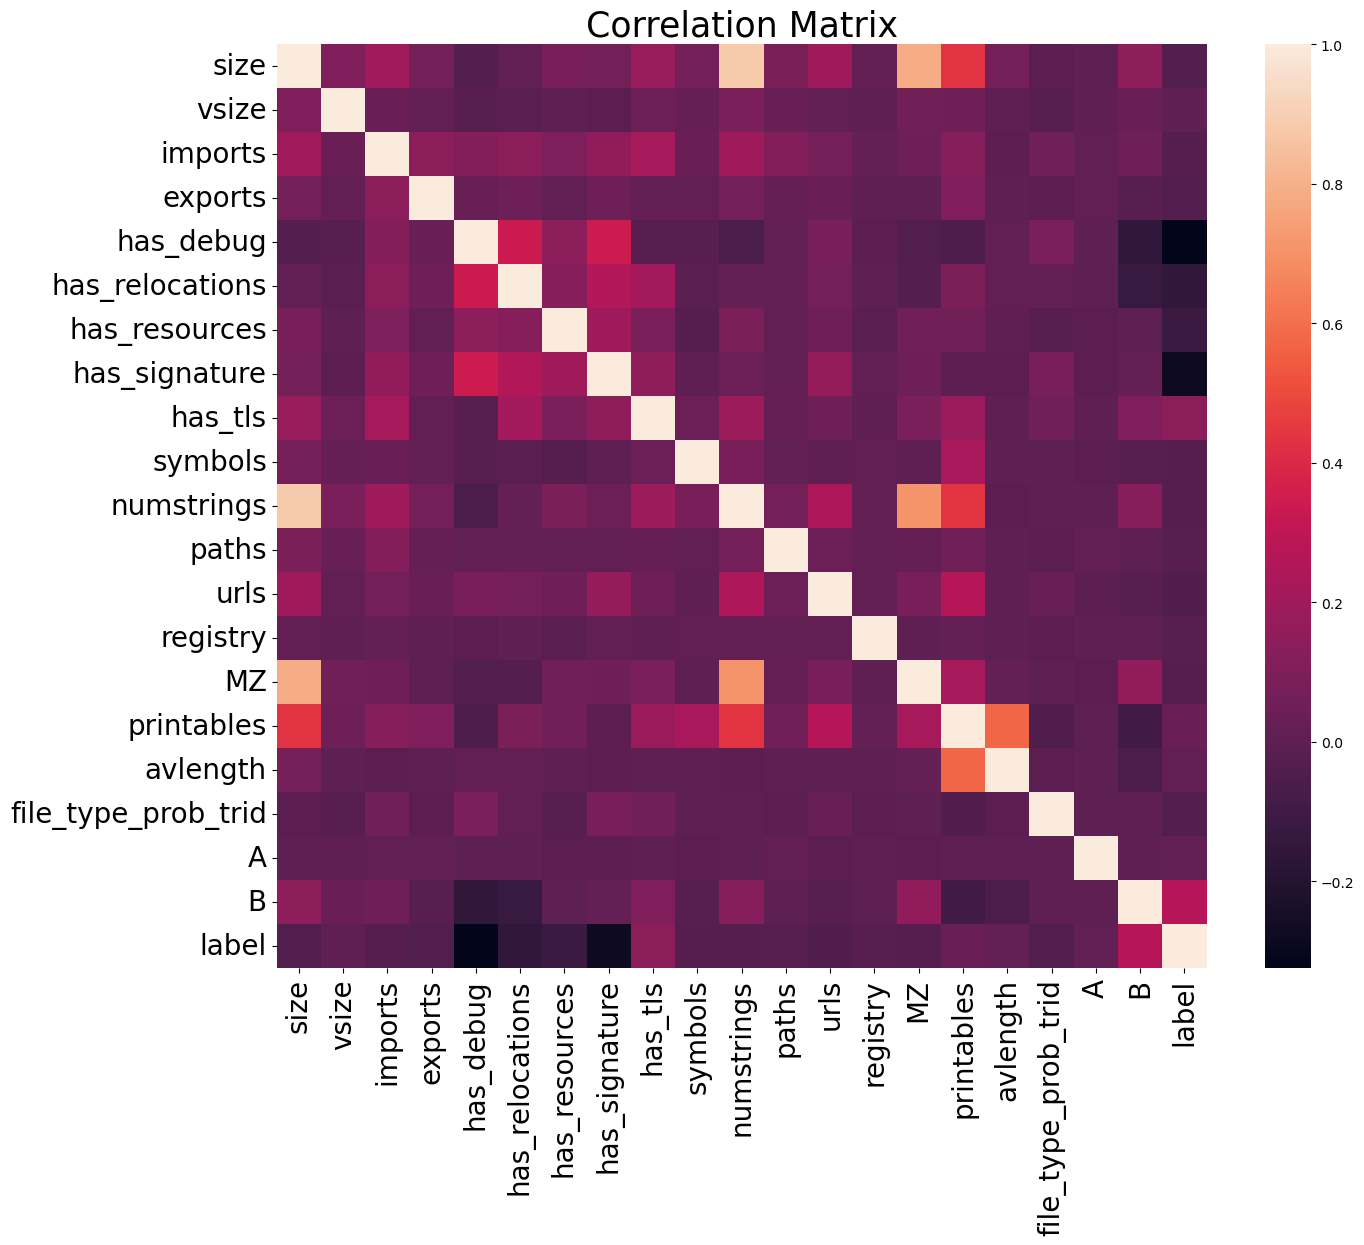

In [231]:
def corr_matrix(data):
    corr_matrix = data.corr()
    plt.figure(figsize=(15, 12) )
    sns.heatmap(corr_matrix, annot=False) 
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title("Correlation Matrix",fontsize=25 )
    plt.show()

corr_matrix(train)

In [232]:
#the following rows show the corelations( seperate between 0 or 1 labels) between diffrent features.
#we can change the feature as we want to get better understanding on diffrent corelations.
#for example between has_signature and has_debug
label_1_data = train[y_train == 1]
label_0_data = train[y_train == 0]
correlation_label_1 = label_1_data['has_signature'].corr(label_1_data['has_debug'])
correlation_label_0 = label_0_data['has_signature'].corr(label_0_data['has_debug'])
print(correlation_label_1)
print(correlation_label_0)


0.40327562790348215
0.19990210448691176


    We can see that there was a difference between the corrlation in different labels.
    
### Therefore we decided to create two correlation maps, one for each label: 
one on the train when the label = 1, and another one where the label = 0.

    We saw that when the labels are only '0', the correlations are significantly higher than '1'.

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1396644000.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


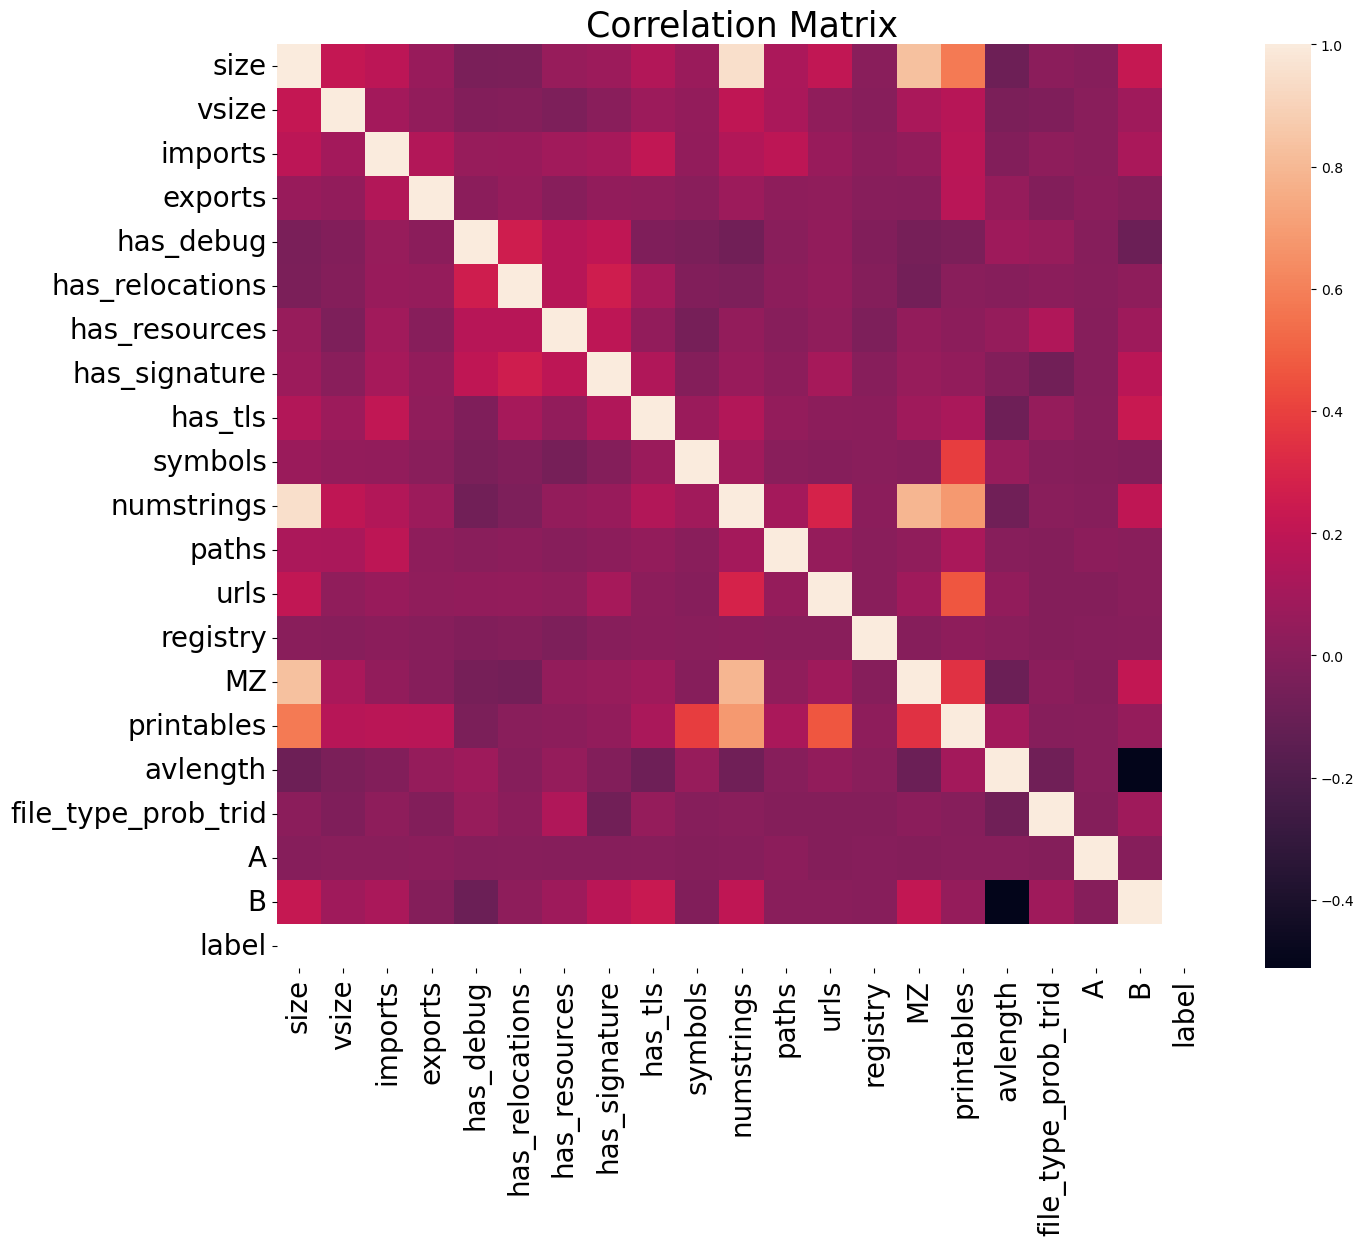

In [233]:
corr_matrix(label_0_data)

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1396644000.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


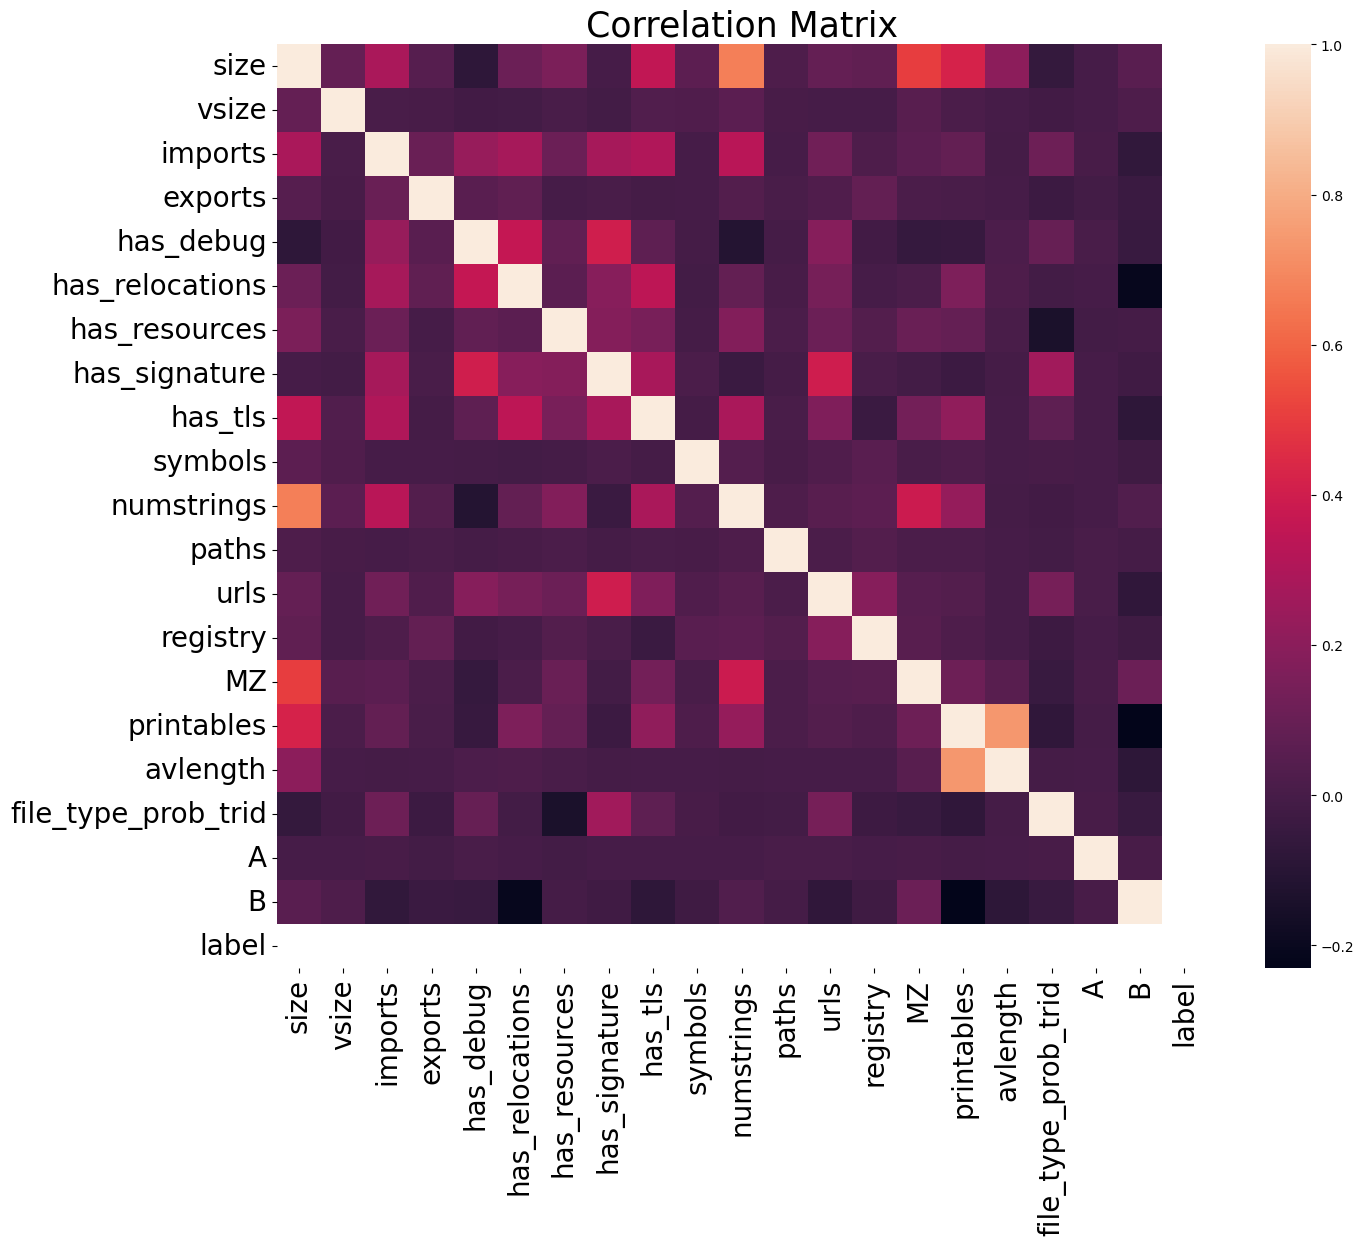

In [234]:
corr_matrix(label_1_data)

### Checking the distribution between each label, for the binary features.

    we can see that all of them besides 'has_relocations' differ significantly between each of the labels.

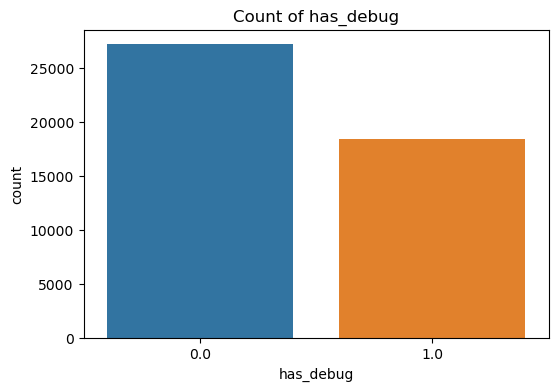

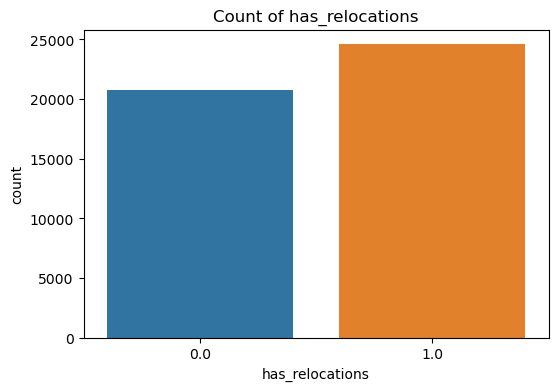

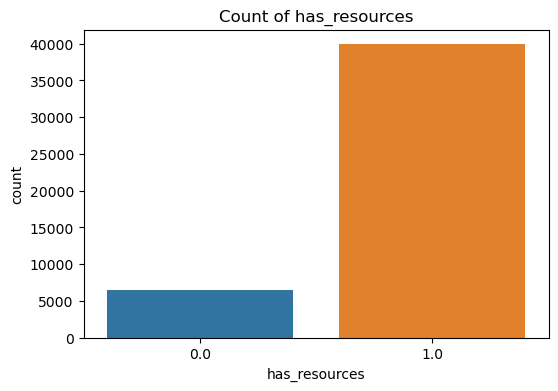

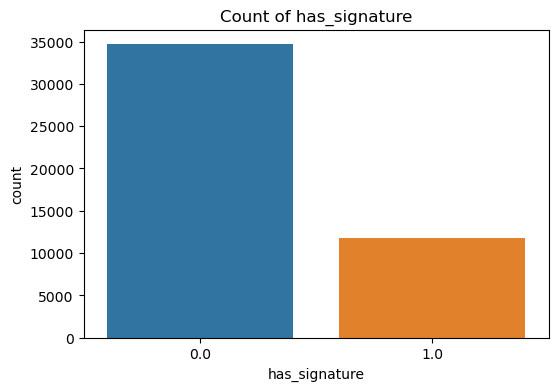

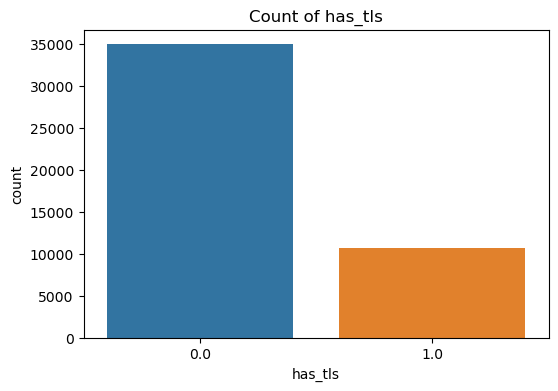

In [235]:
for col in binary:    
    fig , ax = plt.subplots(figsize=(6,4))
    sns.countplot(x=X_train_n[col], data=y_train)
    plt.title("Count of %s" % (col))
    plt.show()

### Plotting the numeric features's relation with the lable, using boxplot 

although we don't know if it's a normal distribution, we can still get a lot of information from looking on the boxplot(and especially to get understanding on outliers).

we used boxplot assuming that the nummeric features distribute normally. because of the wide spread of outliers in the data we created features that are log of the original features' just in order to get a better visual. we wont use the log features any further.

In [236]:
log_numeric = []
for col in numeric:
    name = "log_" + col
    log_numeric.append(name)
    train[name] = np.log(train[col])


/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = ge

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


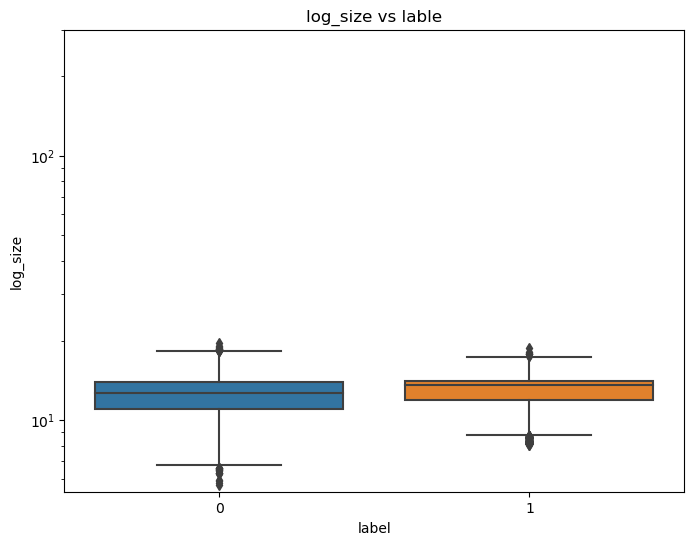

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


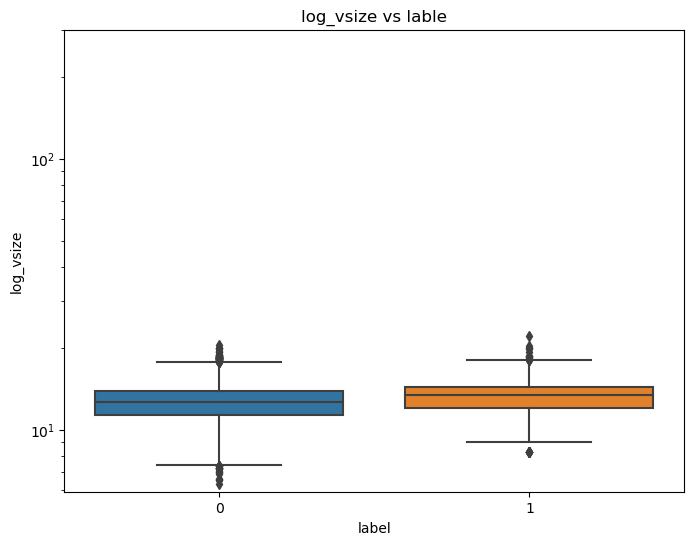

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


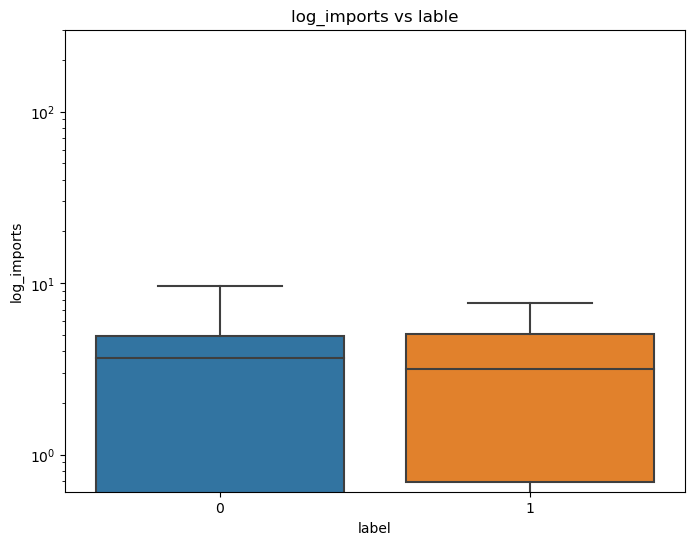

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


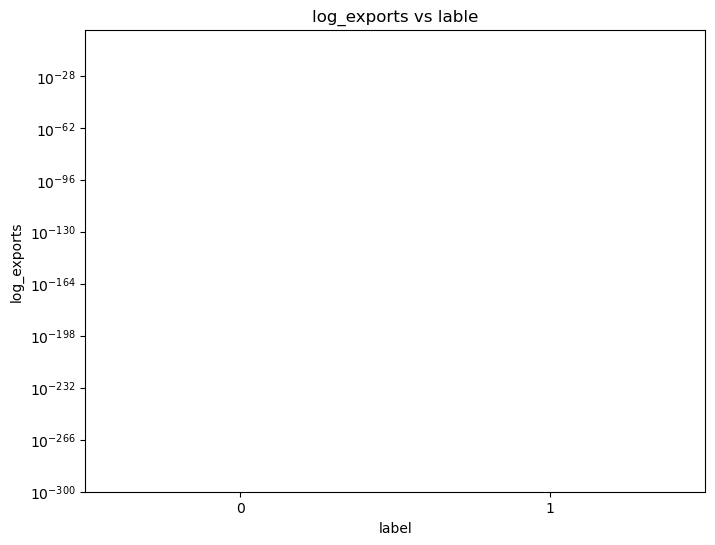

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


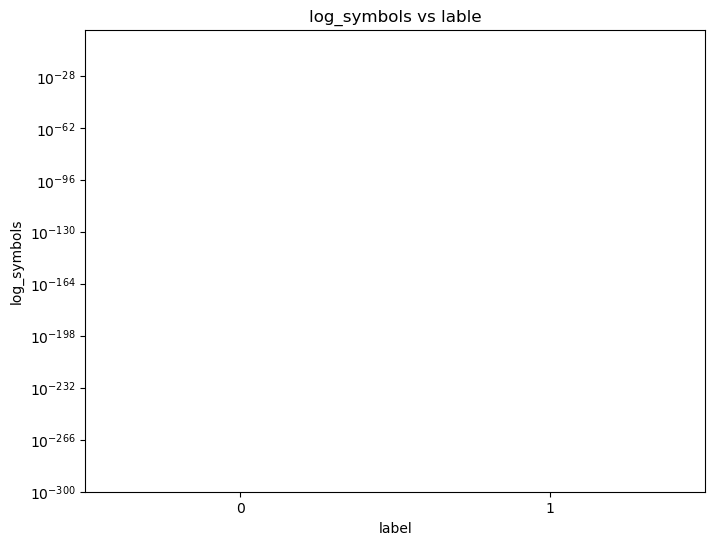

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


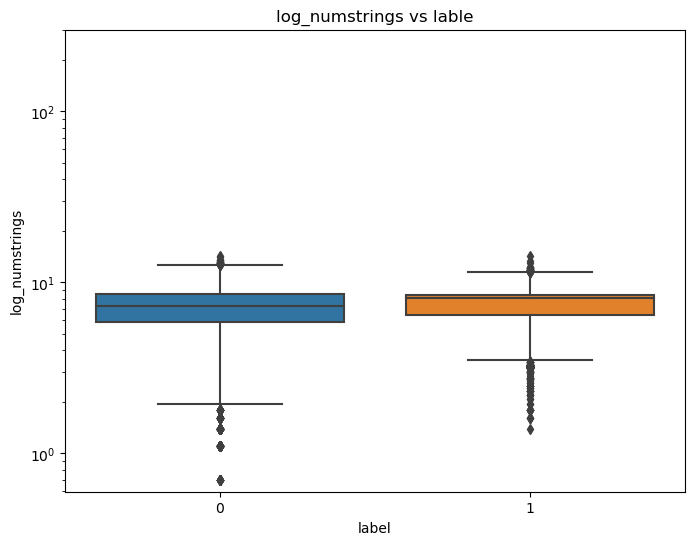

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


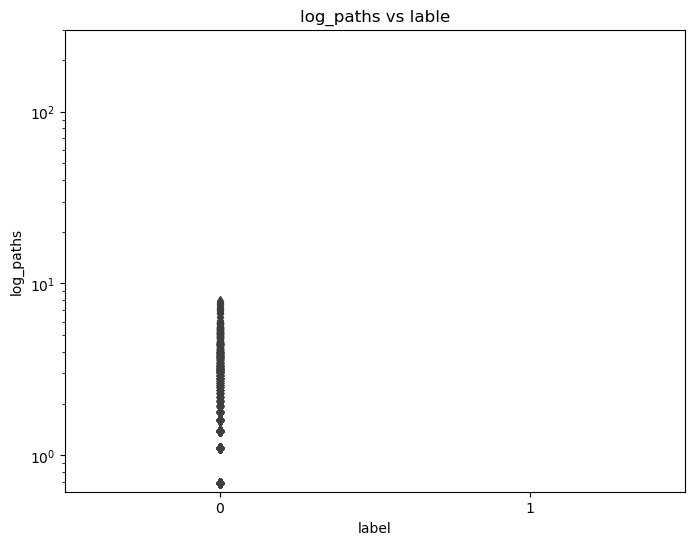

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


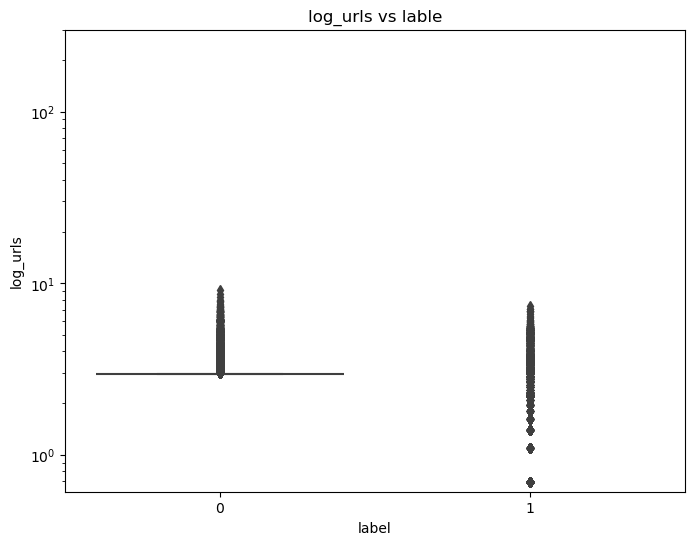

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


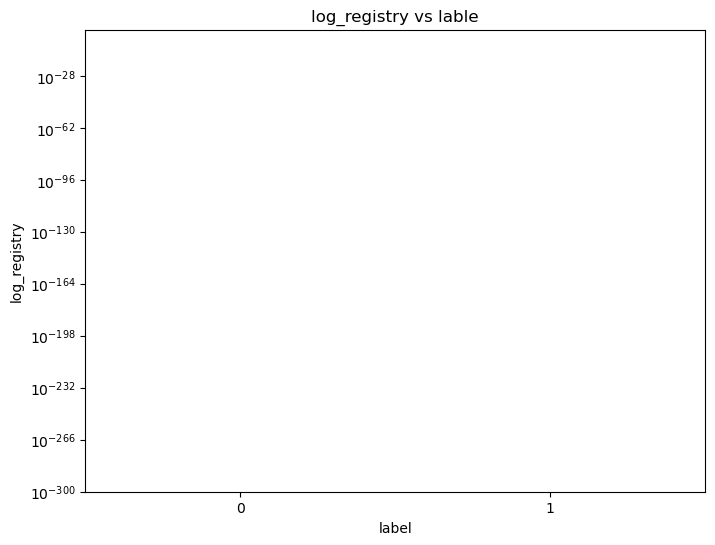

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


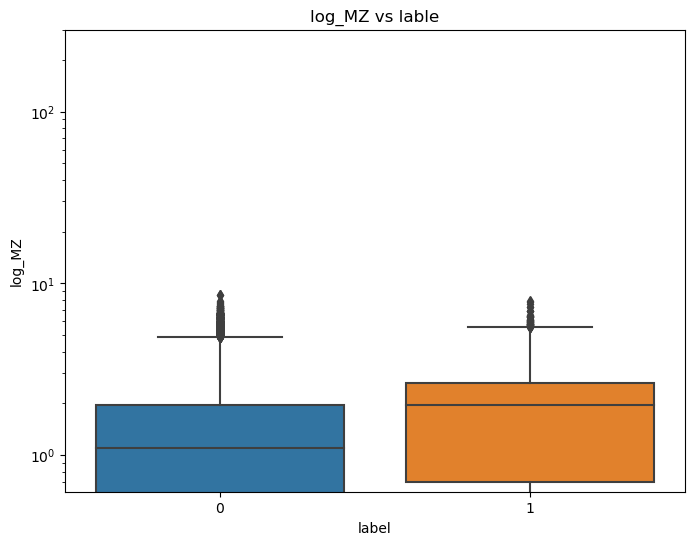

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


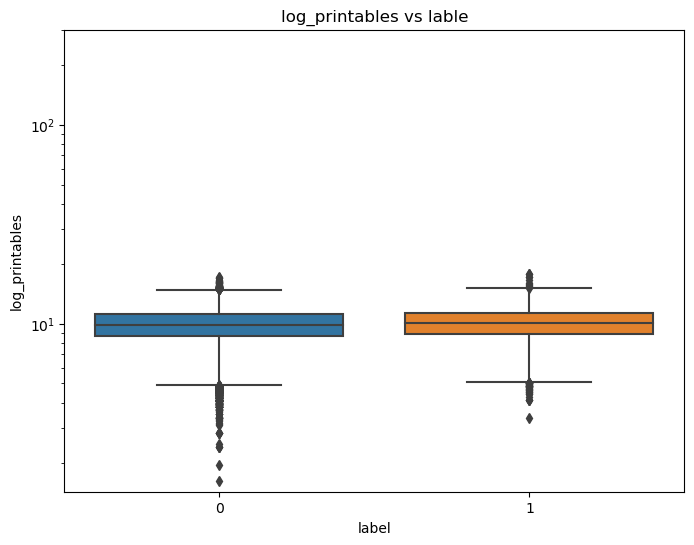

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


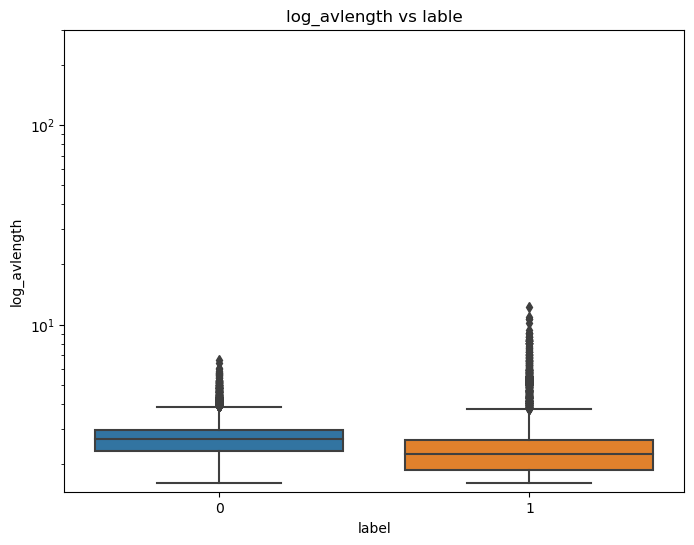

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


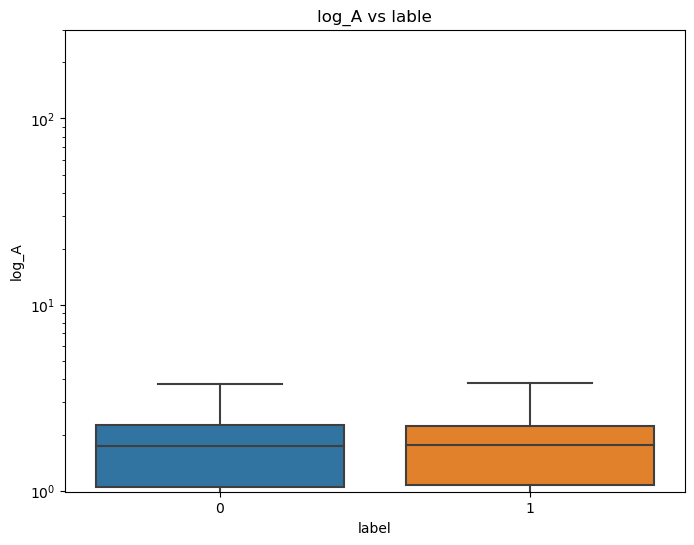

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


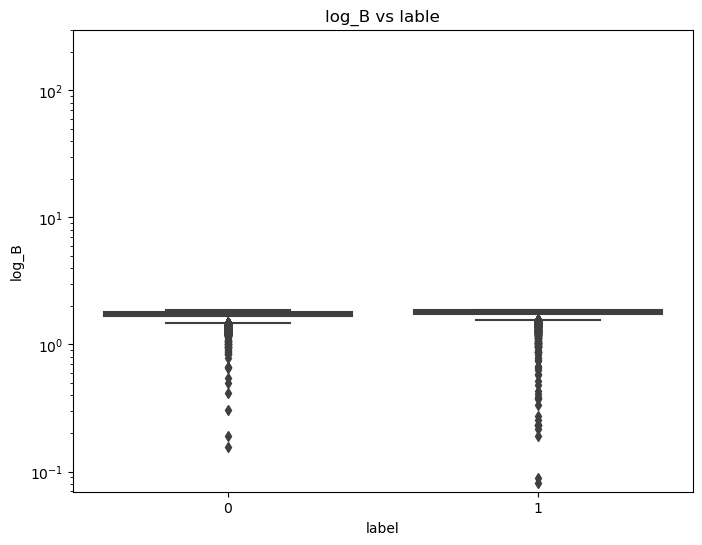

/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/1877936528.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,300)


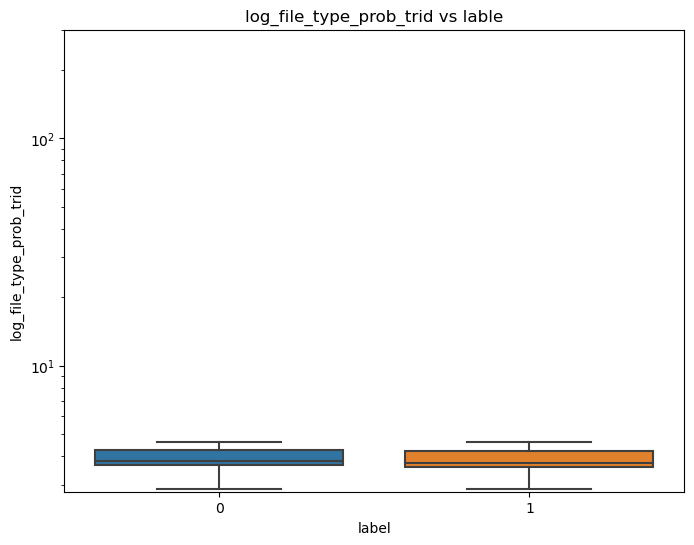

In [237]:

for col in log_numeric:    
    fig, ax=plt.subplots(1,figsize=(8,6))
    sns.boxplot(x= 'label', y =  col, data = train )
    plt.yscale('log')
    ax.set_ylim(0,300)
    plt.title("%s vs lable" % (col))
    plt.show()

    we can see that MZ  and avleangth differ in each label.
    on the other hand, A shows little to no difference.

# Preprocessing 

### categorical features

In [238]:
X_train_n[categorical].isnull().sum()

file_type_trid       0
C                 1659
dtype: int64

    we can see that only C contains null values.

#### Null handling

In [239]:
#null removing 
def null_removing_categorical (X_train , X_test, categorical):
    for f in categorical:
        X_train[f].fillna('NONE_VAL', inplace = True)
        X_test[f].fillna('NONE_VAL',  inplace = True)




In [240]:
null_removing_categorical (X_train_n, X_test, categorical)


In [241]:
for f in categorical: 
    print(X_train_n[f].value_counts())

Win64 Executable (generic)                   8040
Win32 Executable MS Visual C++ (generic)     7175
Win32 Executable (generic)                   7048
Win32 Dynamic Link Library (generic)         3204
Generic CIL Executable (.NET, Mono, etc.)    3019
                                             ... 
OllyDbg plugin                                  1
VirtualDub Filter Plug-in                       1
Photoshop filter plug-in                        1
Microsoft CLR native image executable           1
foobar 2000 generic component                   1
Name: file_type_trid, Length: 88, dtype: int64
vh          18617
er           9267
cs           4745
bf           4637
gow          4475
mc           4096
NONE_VAL     1659
vr            504
Name: C, dtype: int64


At first we tried to handle the categorical features with dummies but, considering that there are 88 different values in file_type_trid ,we decieded to use another method

we created a function that shows the row count for each different value in the categorical features:

In [242]:
categorial_dist(X_train_n , 'file_type_trid')
categorial_dist(X_train_n,'C' )

there are 88 unique values:
Win64 Executable (generic) 8040 samples 

Win32 Executable MS Visual C++ (generic) 7175 samples 

Win32 Executable (generic) 7048 samples 

Win32 Dynamic Link Library (generic) 3204 samples 

Generic CIL Executable (.NET, Mono, etc.) 3019 samples 

Windows Control Panel Item (generic) 2580 samples 

InstallShield setup 1815 samples 

UPX compressed Win32 Executable 1729 samples 

DOS Executable Generic 1389 samples 

Win32 Executable Microsoft Visual Basic 6 1334 samples 

Win32 EXE PECompact compressed (generic) 939 samples 

Generic .NET DLL/Assembly 938 samples 

OS/2 Executable (generic) 931 samples 

WinRAR Self Extracting archive (4.x-5.x) 902 samples 

NSIS - Nullsoft Scriptable Install System 811 samples 

Microsoft Visual C++ compiled executable (generic) 796 samples 

Win32 Executable Delphi generic 708 samples 

Inno Setup installer 650 samples 

Win16 NE executable (generic) 621 samples 

Windows ActiveX control 527 samples 

DOS Borland compiled

#### Plot that shows the row count for each value in the categorical features:

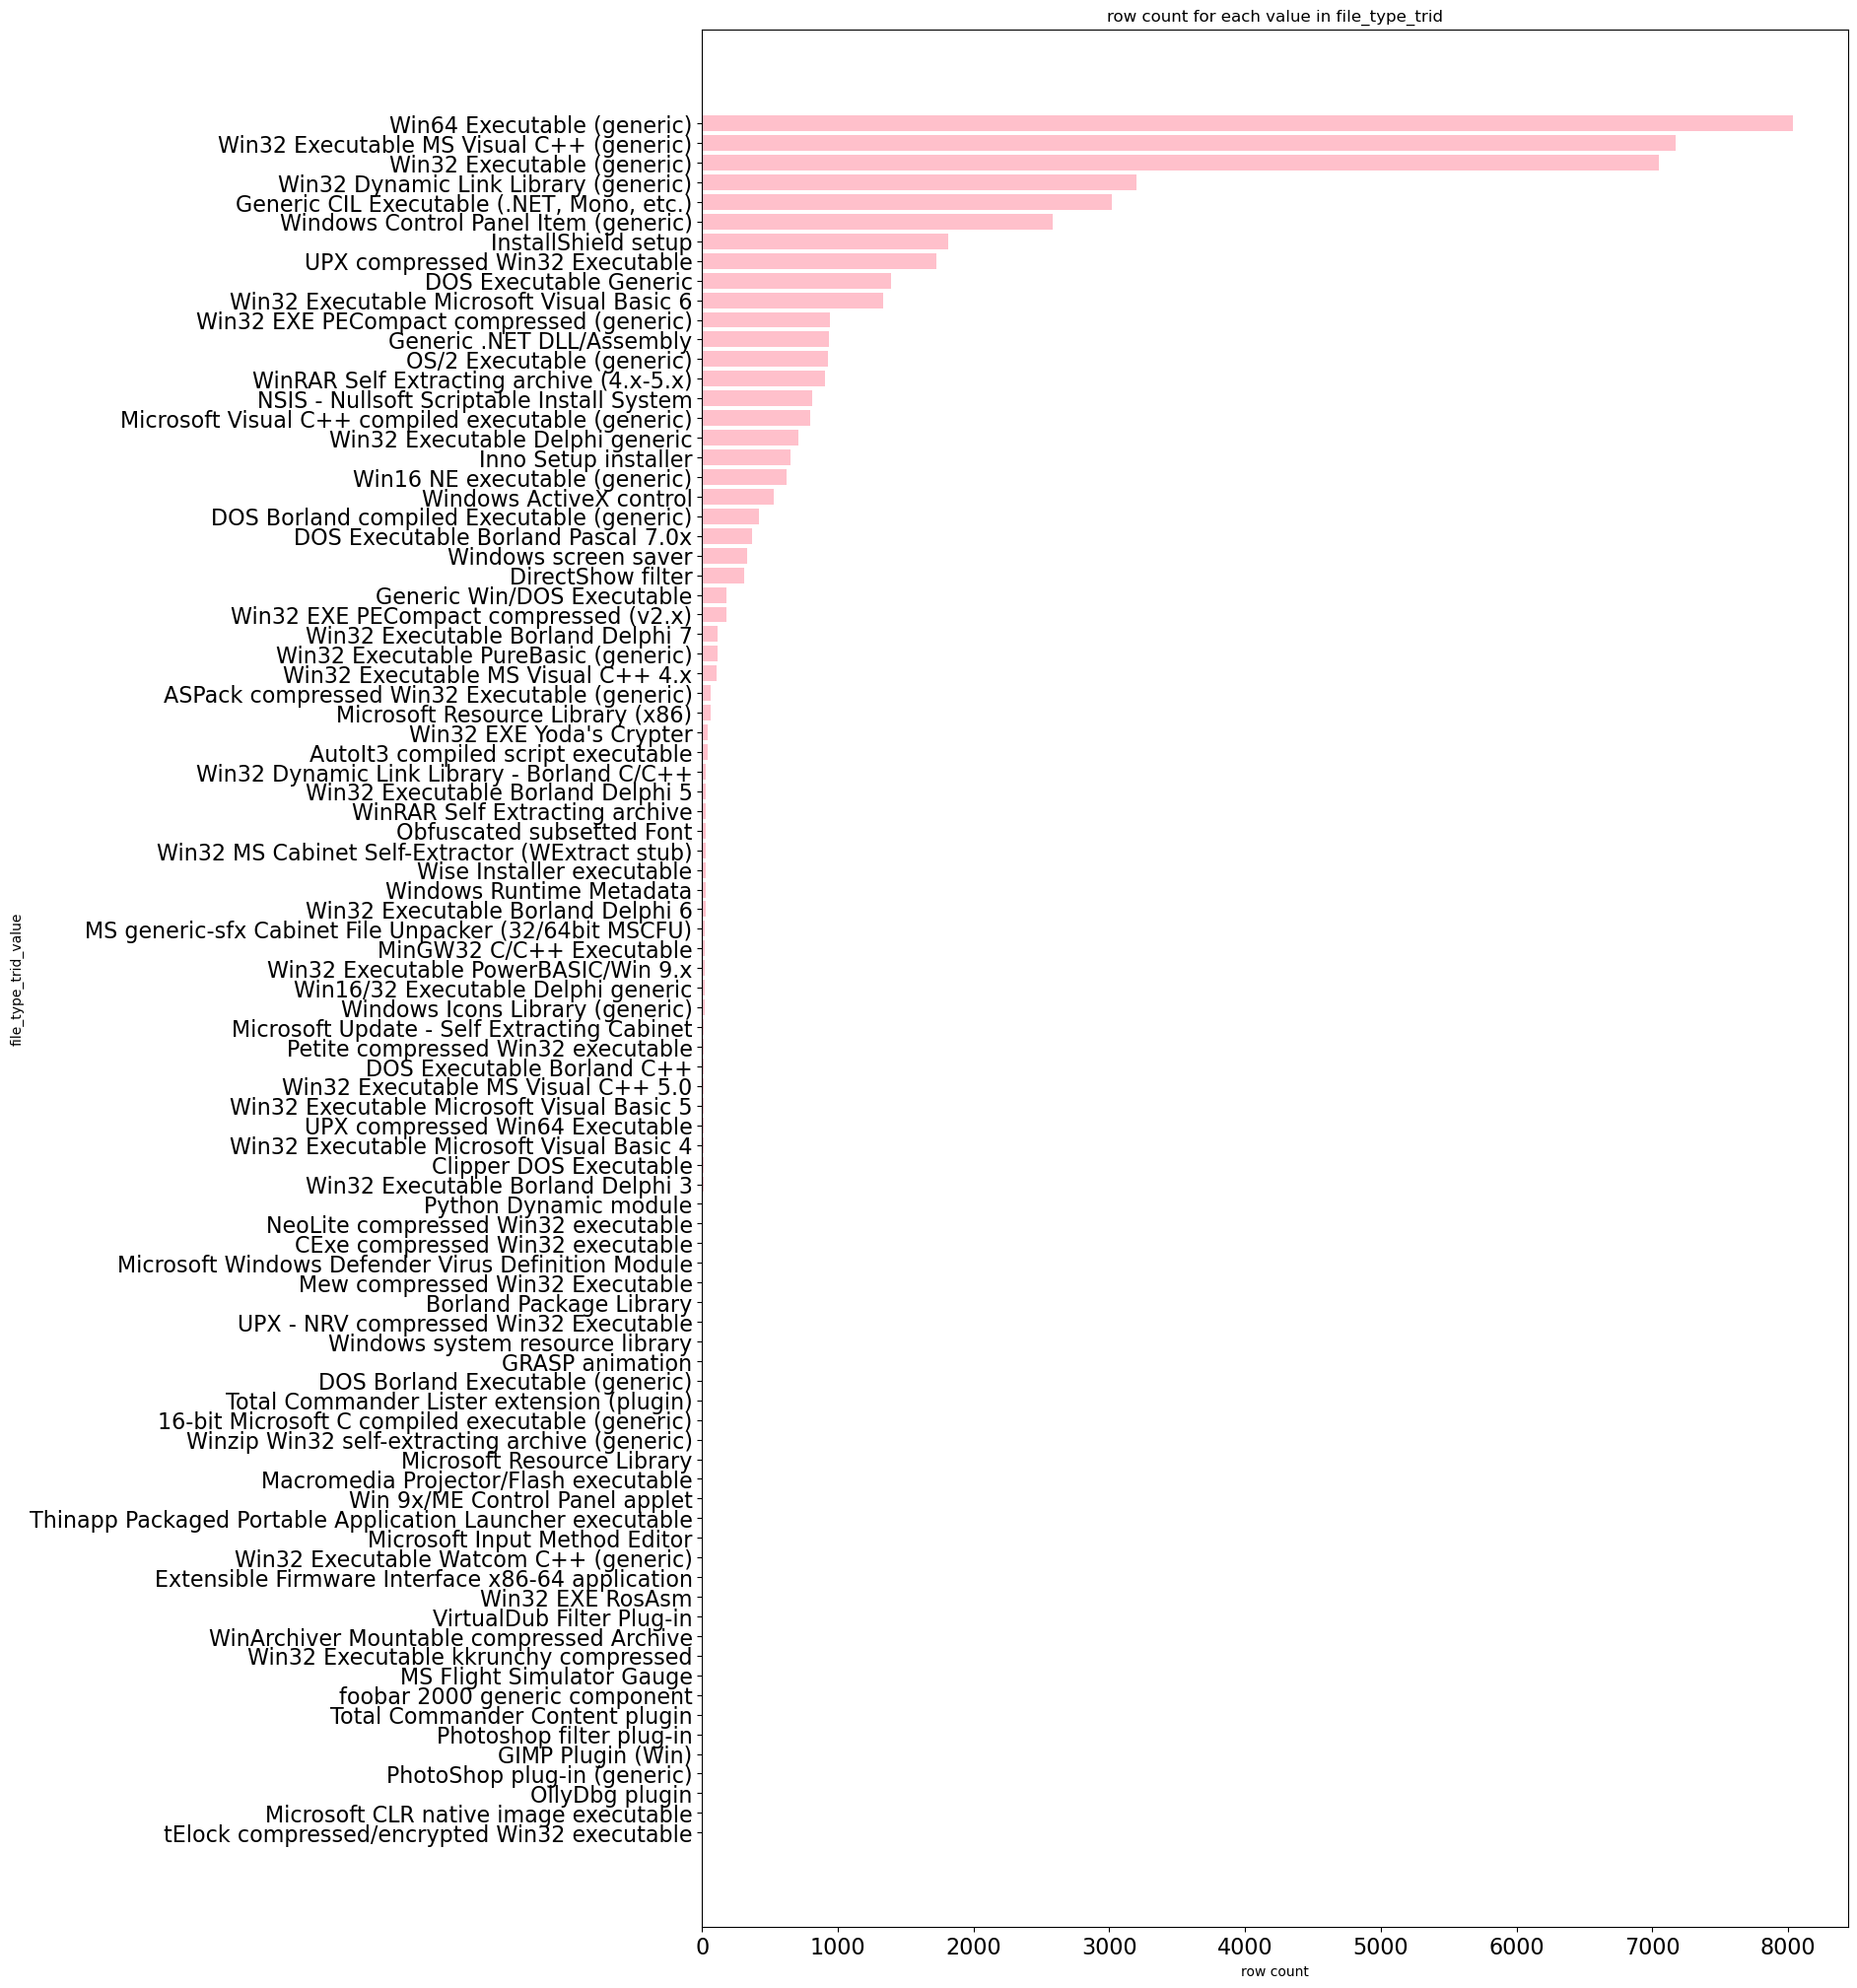

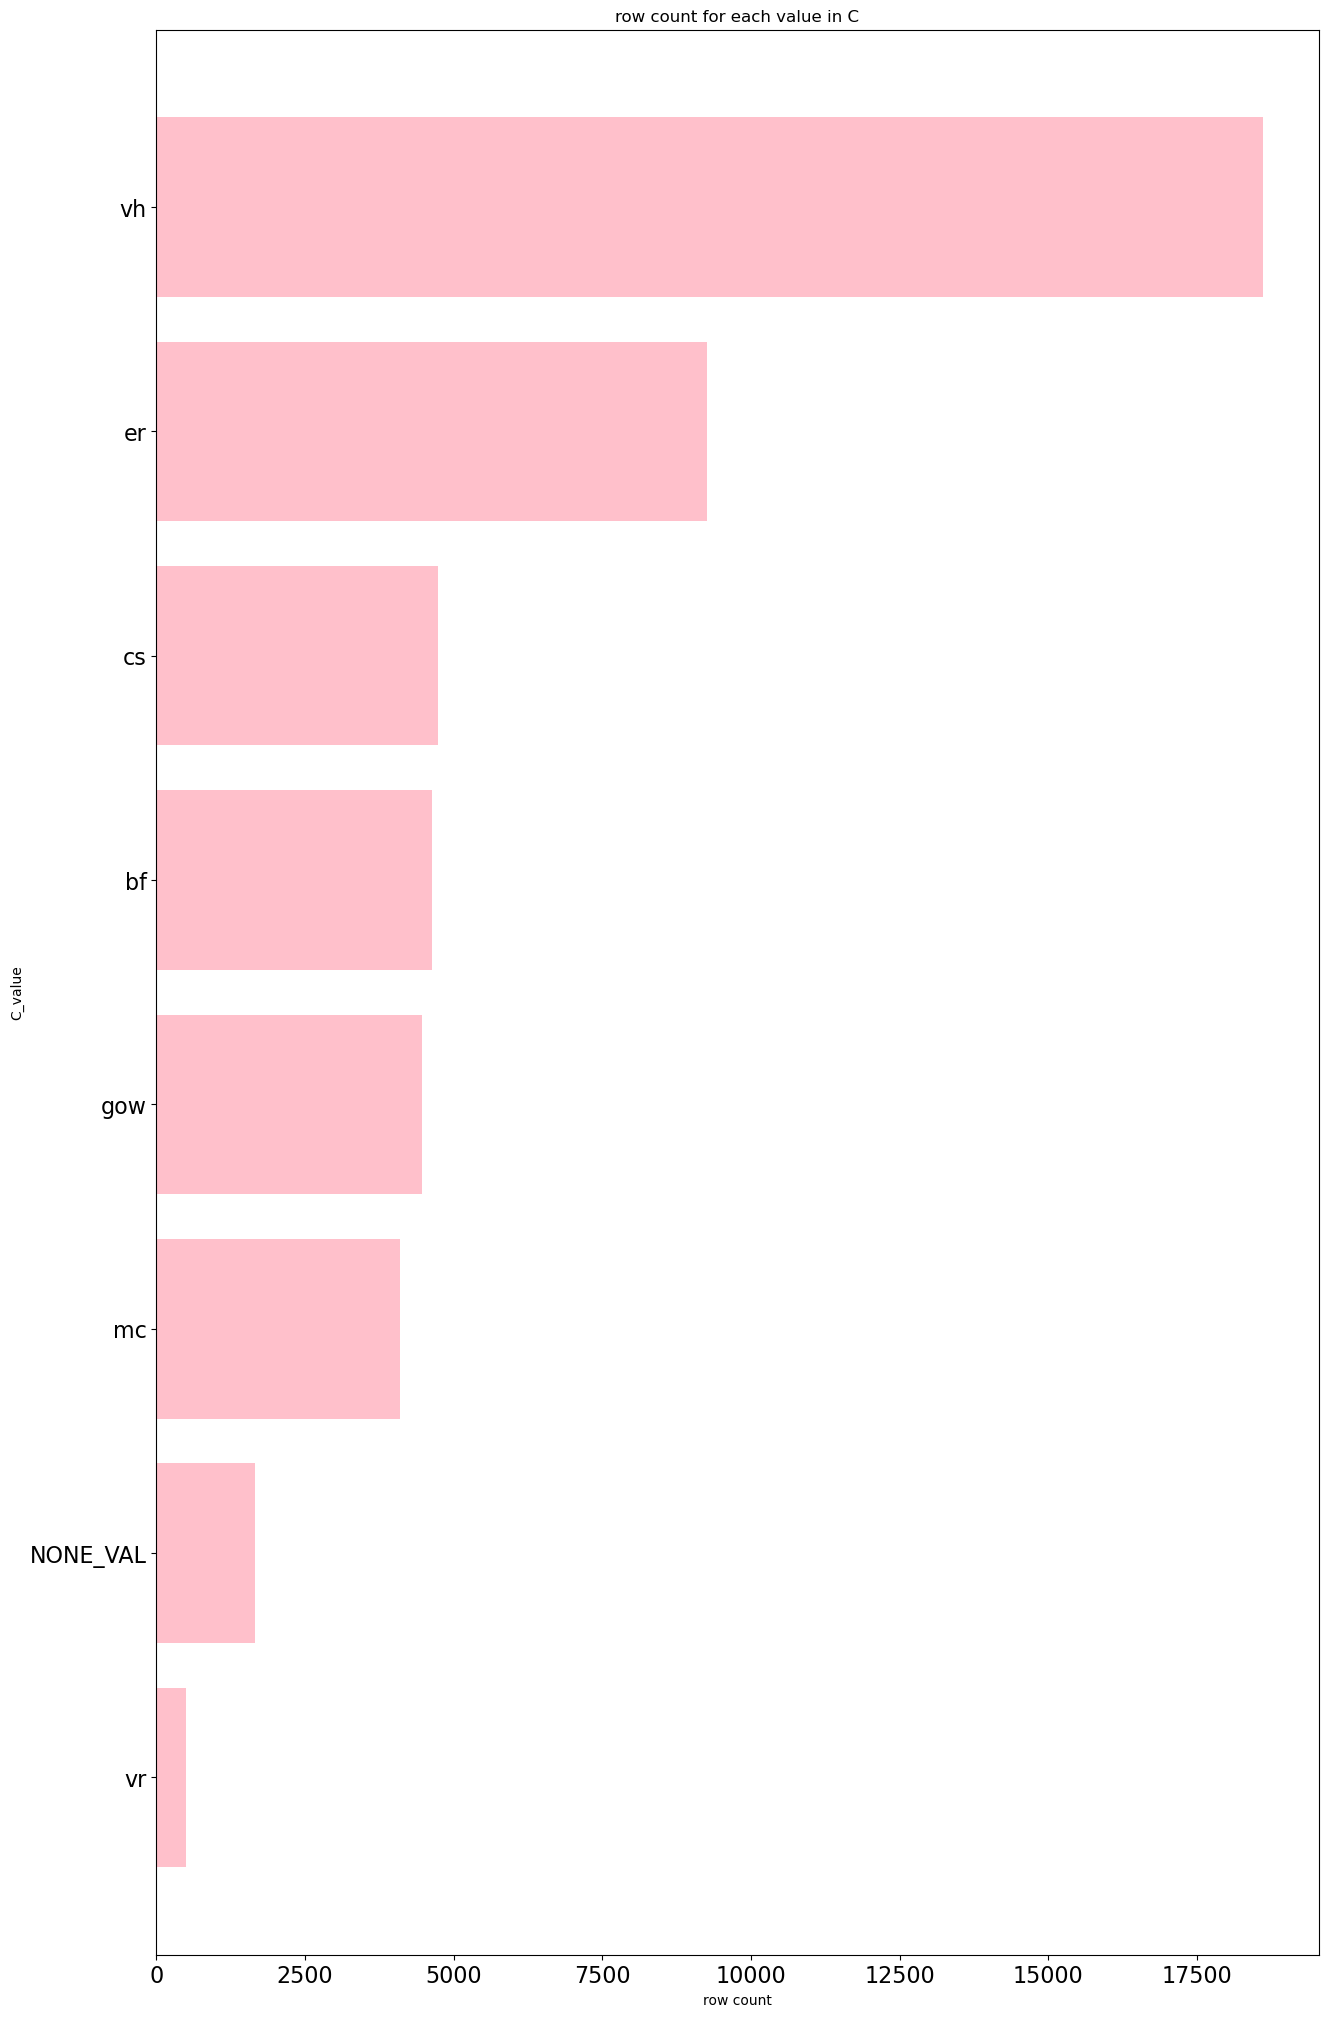

In [243]:
#understanding the distribution in the the categorical columns 
def plot_categorical_dist(x_train , categorical):
    for f in categorical:
        u , c , sortedind = count_sort( x_train , f)
        plt.figure(figsize=(15,25))
        plt.barh(u[sortedind] ,c[sortedind], color='pink' )
        plt.ylabel("%s_value" % f)
        plt.xlabel("row count")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.title("row count for each value in %s" % f)
        plt.show()

plot_categorical_dist(X_train_n, categorical)

### categorical features outlier handling

    Based on the plot above, we saw that it is preferable to remove values that appear in a very small number of rows in the data. this are the outliers in this features. 
    
Therfore we created the function that reduces to k different values,keeping the k most frequent values and replacing the others with a new class 'other' , we chose k for each feature based on the plot.

In [244]:

X_train_n, X_test = reduce_to_top_k_indices(X_train_n,  X_test , 'C', 6, True)
X_train_n, X_test = reduce_to_top_k_indices(X_train_n,  X_test , 'file_type_trid', 30, True)

reducing to 6 values means 2 different values in 2163 rows will be classified as other,
 losing 4.51 precent of the data 
 the most common value is NONE_VAL with 1659 rows
reducing to 30 values means 58 different values in 656 rows will be classified as other,
 losing 1.37 precent of the data 
 the most common value is Microsoft Resource Library (x86) with 62 rows


### Numeric features

#### Null handling
we chose to replace null value with the meadian.

In [245]:
print(X_train_n[numeric].isnull().sum())


size                      0
vsize                  1532
imports                1409
exports                1679
symbols                2099
numstrings             2175
paths                  2942
urls                   1874
registry               2020
MZ                     2460
printables             2147
avlength               2184
A                      2959
B                      3075
file_type_prob_trid       0
dtype: int64


In [246]:
def num_null_handling(X_train_n , X_test, numeric):
    numeric_features_train = X_train_n[numeric]
    numeric_features_test = X_test[numeric]

    # Create an instance of SimpleImputer with median strategy
    imputer = SimpleImputer(strategy='median')

    # Fit and transform the training data
    numeric_features_train.iloc[:,:] = imputer.fit_transform(numeric_features_train)
    # Transform the test data
    numeric_features_test.iloc[:,:] = imputer.transform(numeric_features_test)

    # Drop the original numeric columns from the original dataframes
    X_train_n.drop(numeric, axis=1, inplace=True)
    X_test.drop(numeric, axis=1, inplace=True)

    # Concatenate the imputed numeric features with the original dataframes
    X_train_n = pd.concat([X_train_n, numeric_features_train], axis=1)
    X_test = pd.concat([X_test, numeric_features_test], axis=1)

    return X_train_n , X_test




In [247]:
X_train_n, X_test = num_null_handling(X_train_n , X_test, numeric)


/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/304819278.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_features_train.iloc[:,:] = imputer.fit_transform(numeric_features_train)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/304819278.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  numeric_features_train.iloc[:,:] = imputer.fit_transform(numeric_features_train)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/304819278.py:11: SettingWithCopyWarning: 
A valu

In [248]:
print(X_train_n.isnull().sum())

has_debug              2355
has_relocations        2659
has_resources          1582
has_signature          1555
has_tls                2350
file_type_trid            0
C                         0
size                      0
vsize                     0
imports                   0
exports                   0
symbols                   0
numstrings                0
paths                     0
urls                      0
registry                  0
MZ                        0
printables                0
avlength                  0
A                         0
B                         0
file_type_prob_trid       0
dtype: int64


#### Null handling in binary features

In [249]:

def null_handling_binary(X_train_n , X_test,binary):
    for c in binary:
        
        X_train_n[c].fillna(0, inplace= True)
        X_test[c].fillna(0, inplace= True)
    return

null_handling_binary(X_train_n , X_test,binary)



In [250]:
print(X_train_n.isnull().sum())

has_debug              0
has_relocations        0
has_resources          0
has_signature          0
has_tls                0
file_type_trid         0
C                      0
size                   0
vsize                  0
imports                0
exports                0
symbols                0
numstrings             0
paths                  0
urls                   0
registry               0
MZ                     0
printables             0
avlength               0
A                      0
B                      0
file_type_prob_trid    0
dtype: int64


### outlier hanling - numeric features

    After several attempts to handle outliers in this features, we created three subgroups of the numerical features for each of them we adapted to the removal method

#### First step: create a plot to see the distribution of each feature.

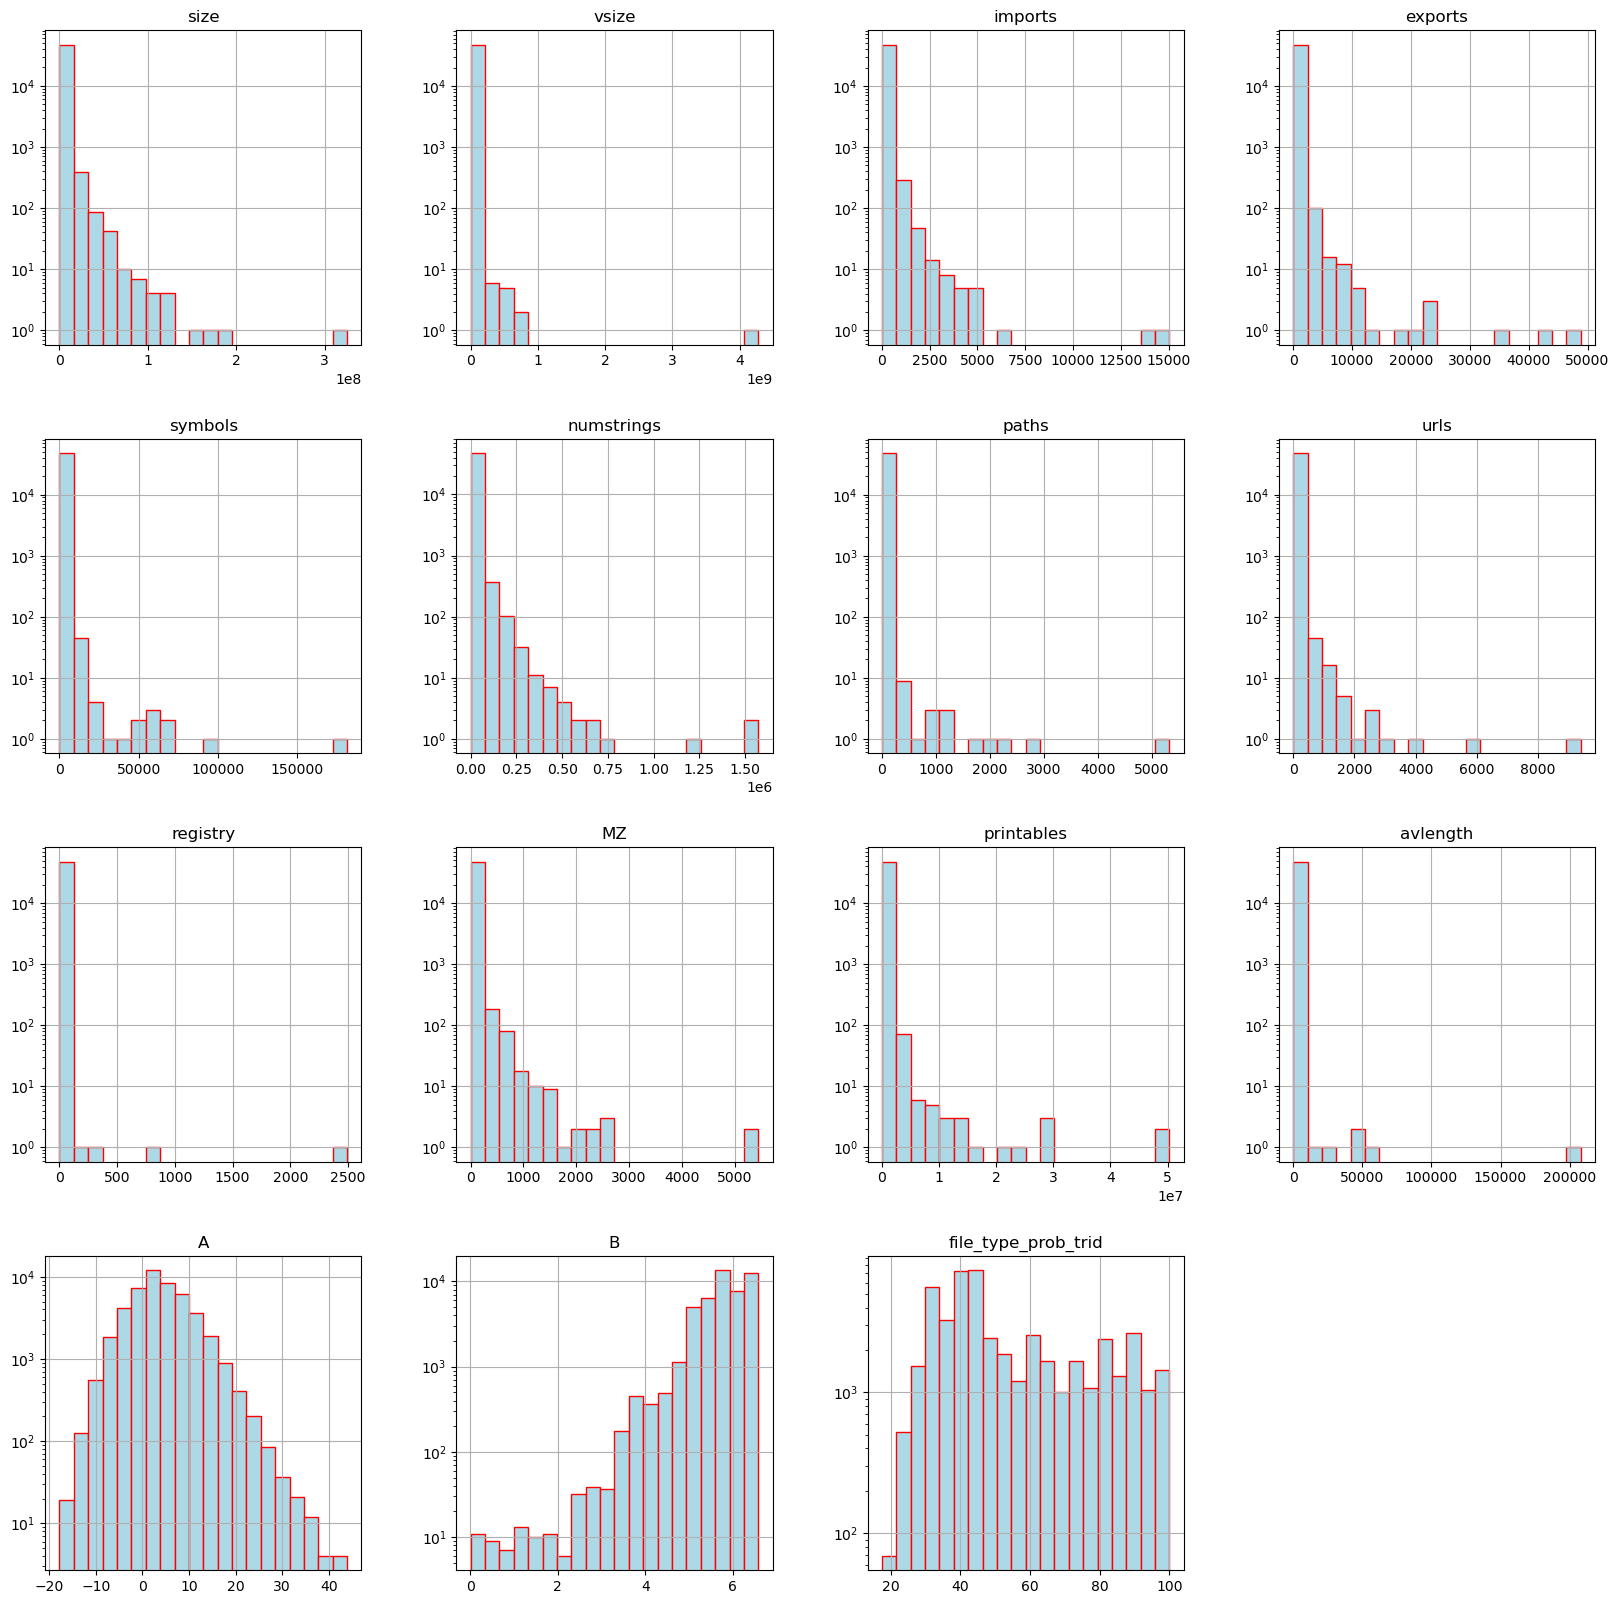

In [251]:

X_train_n.loc[:, numeric].hist(bins = 20, figsize=(20, 20), color='lightblue', edgecolor='red', log = True)

plt.show()


    Looking at the plot, we can see that the features have skewed distribution, a distribution simillar to normal distribution, where one tail is longer than the other

#### Also, we want to see the distibution of each column before outlier handling, also in a boxplot.

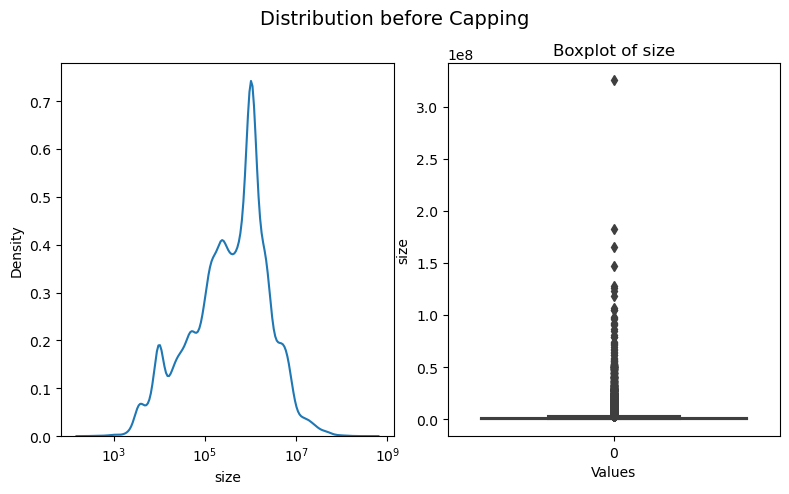

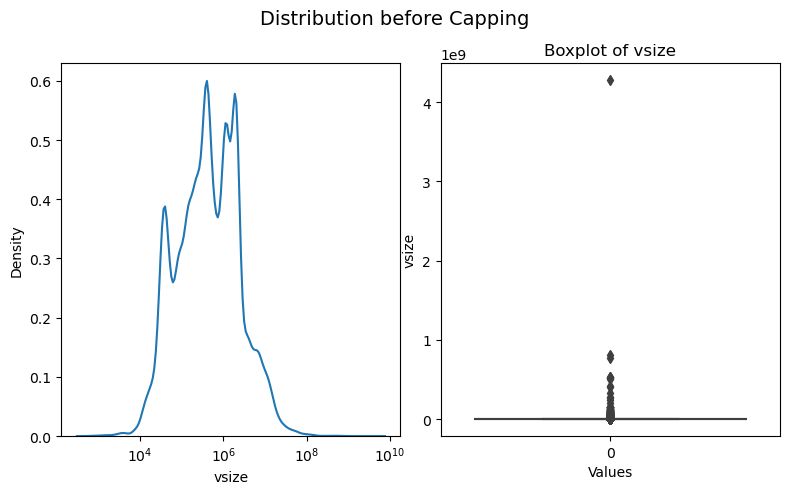

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2355571308.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


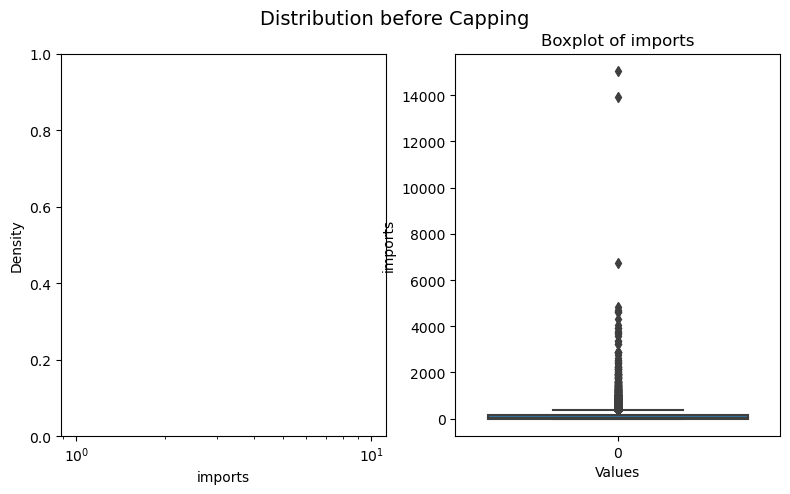

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2355571308.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


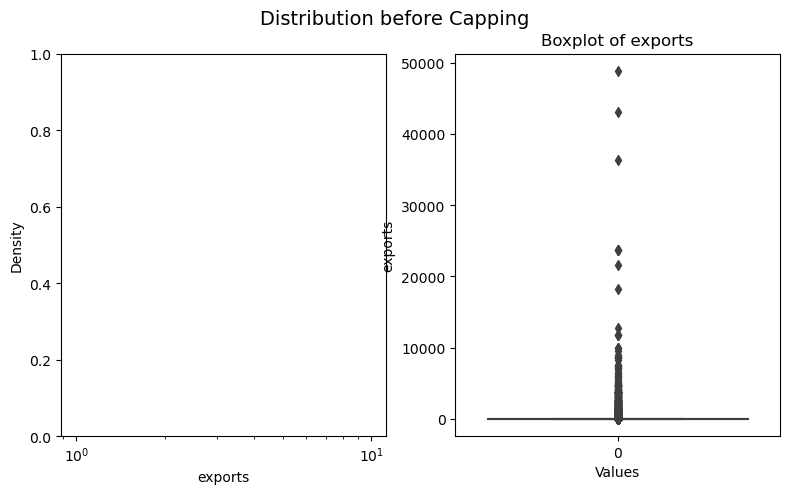

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2355571308.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


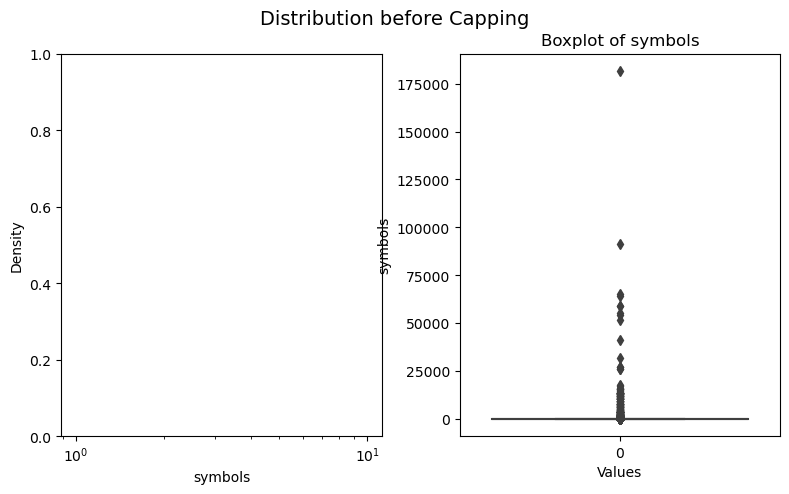

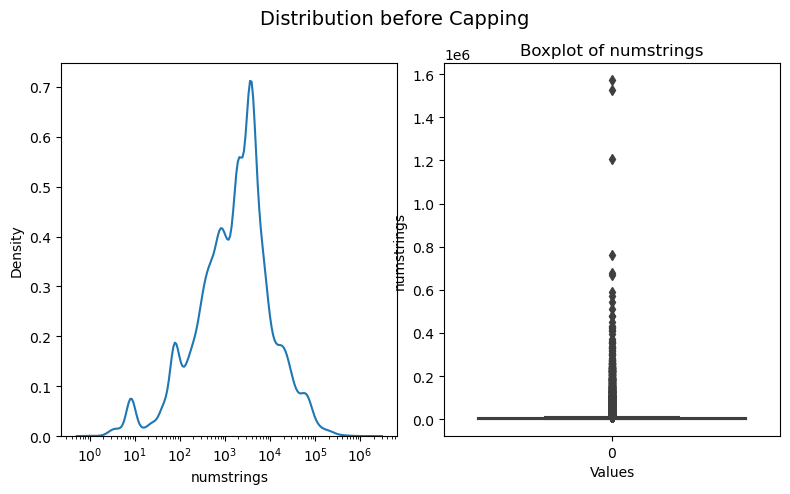

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2355571308.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


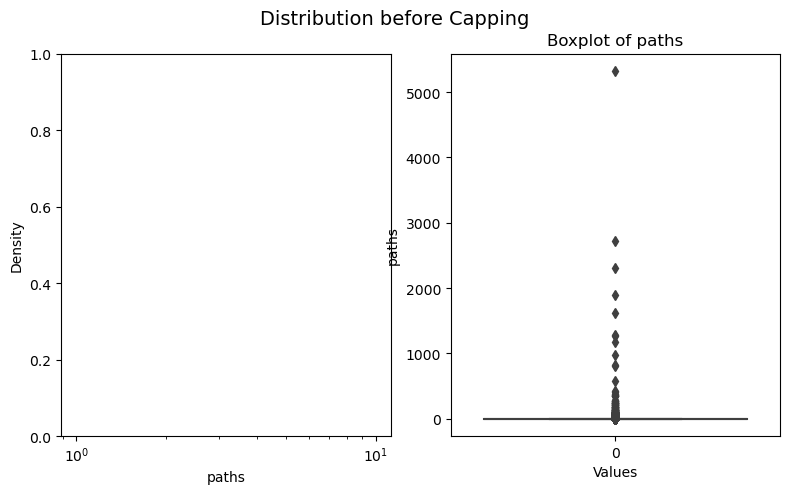

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2355571308.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


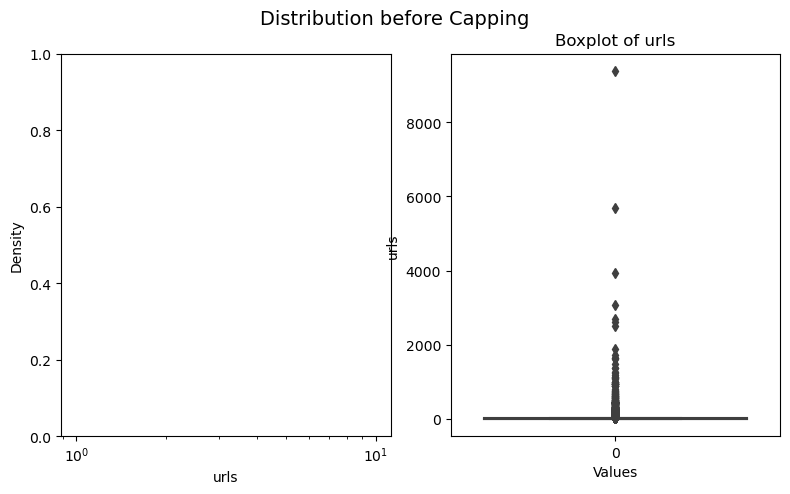

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/2355571308.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


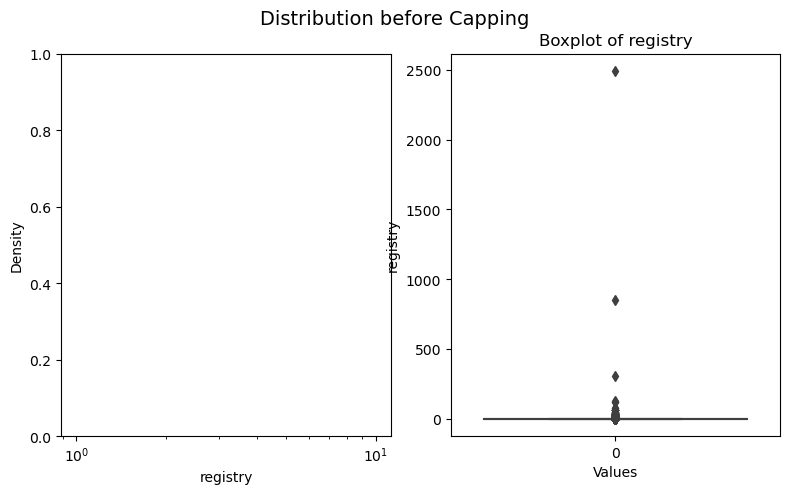

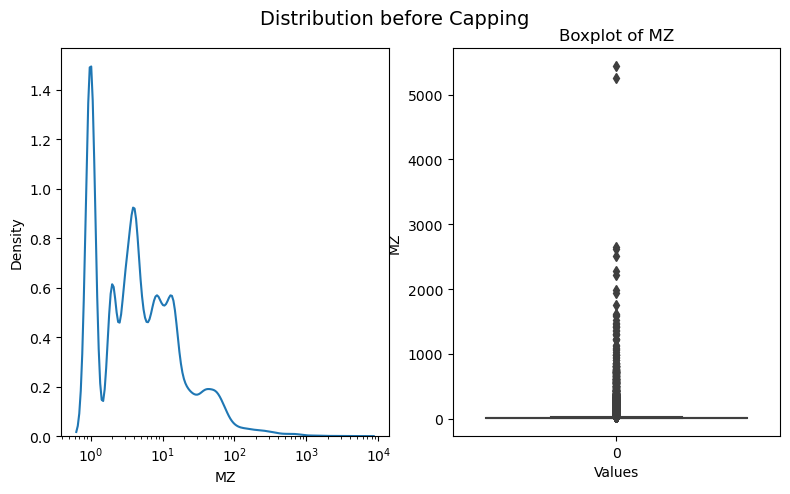

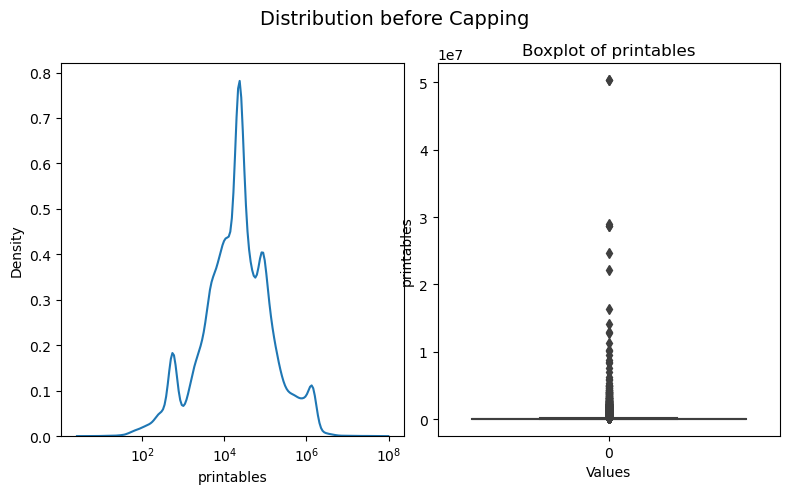

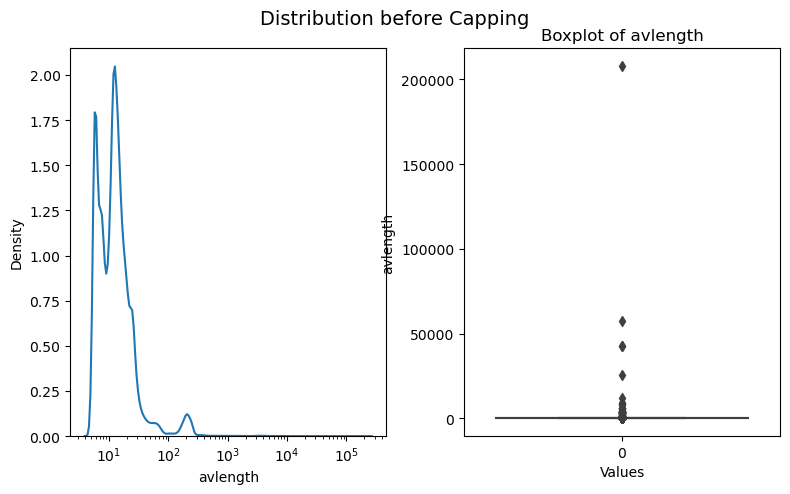

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


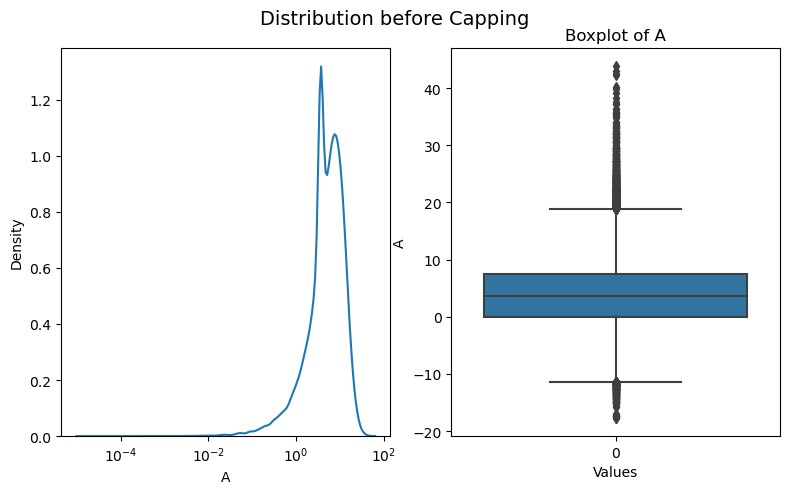

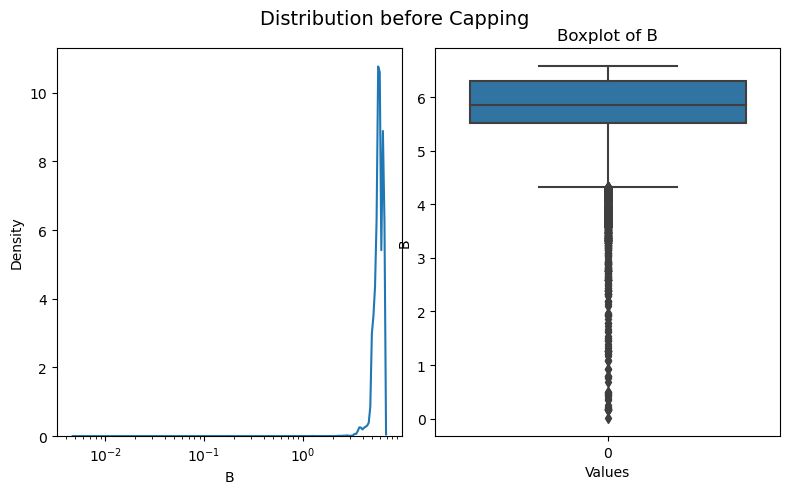

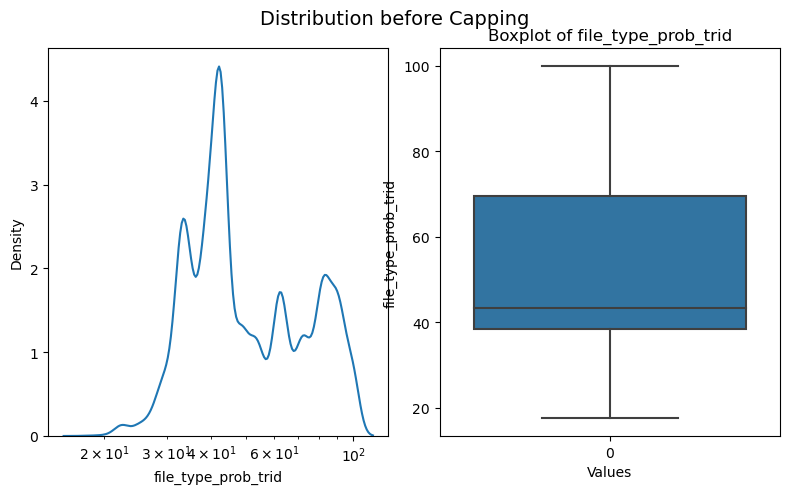

In [252]:
numeric_columns = X_train_n.loc[:, numeric]

for column in numeric:
    plt.figure(figsize=(8,5))
    plt.suptitle("Distribution before Capping", fontsize=14)
    plt.subplot(1,2,1)
    sns.kdeplot(data =X_train_n[column] , log_scale=True)
    plt.subplot(1,2,2)
    sns.boxplot(data  = X_train_n[column])
    plt.tight_layout()
    plt.xlabel('Values')
    plt.ylabel(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

    We can see that most of the features contain outliers

#### A breakdown for how we handeled outliers in each supgroup:

for the subgroup **numeric1** we use **capping & Inter-Quartile Range** (IQR) that fits the skewed distribution.

for the subgroups **numeric2** and **numeric3** we use the **precntile method**

1. Capping is setting a limit for the feature and set the value of all the outliers exceeding the limit to the value of the limit. So in the student example, we will set a limit of score and change the score of the 2% student to that. For example, 75 is the max score limit that we set. The score of 2% outlier students will be set to 75.

2. Percentile method is equal percentile on both the sides to detect outliers. Once you detect these outliers you can use either trimming or capping to get rid of them.

we will use the train dataset parameters to handel outliers in the test set as well.

source: https://www.kaggle.com/code/aimack/how-to-handle-outliers

In [253]:

def handel_outliers_numeric(X_train_n, X_test):
    #created 3 lists of numeric feautures, we will use diffrant methods of outlier handeling for each.
    numeric1 = ['size','vsize', 'imports', 'numstrings', 'MZ', 'printables', 'avlength', 'A', 'B']
    #PRBLEMATIC
    numeric2 = ['exports','paths','urls','registry',]
    #removed 'file_type_prob_trid', from numeric
    numeric3 = ['symbols']
    
    for col in numeric1:
        #on the test set, based on the train set parameters:
        outliers_handling(col,X_train_n,X_test)
        #on the train set
        outliers_handling(col,X_train_n,X_train_n)

    #same for the other subgroups:

    for col in numeric2:
        outliers_handling_precentile(col,0.99 ,X_train_n,X_test)
        outliers_handling_precentile(col,0.99 ,X_train_n,X_train_n)


    for col in numeric3:
        outliers_handling_precentile(col,0.995 ,X_train_n,X_test)
        outliers_handling_precentile(col,0.995 ,X_train_n,X_train_n)
    
    return

In [254]:
handel_outliers_numeric(X_train_n,X_test)

#### Use the same plots again to see the difference:

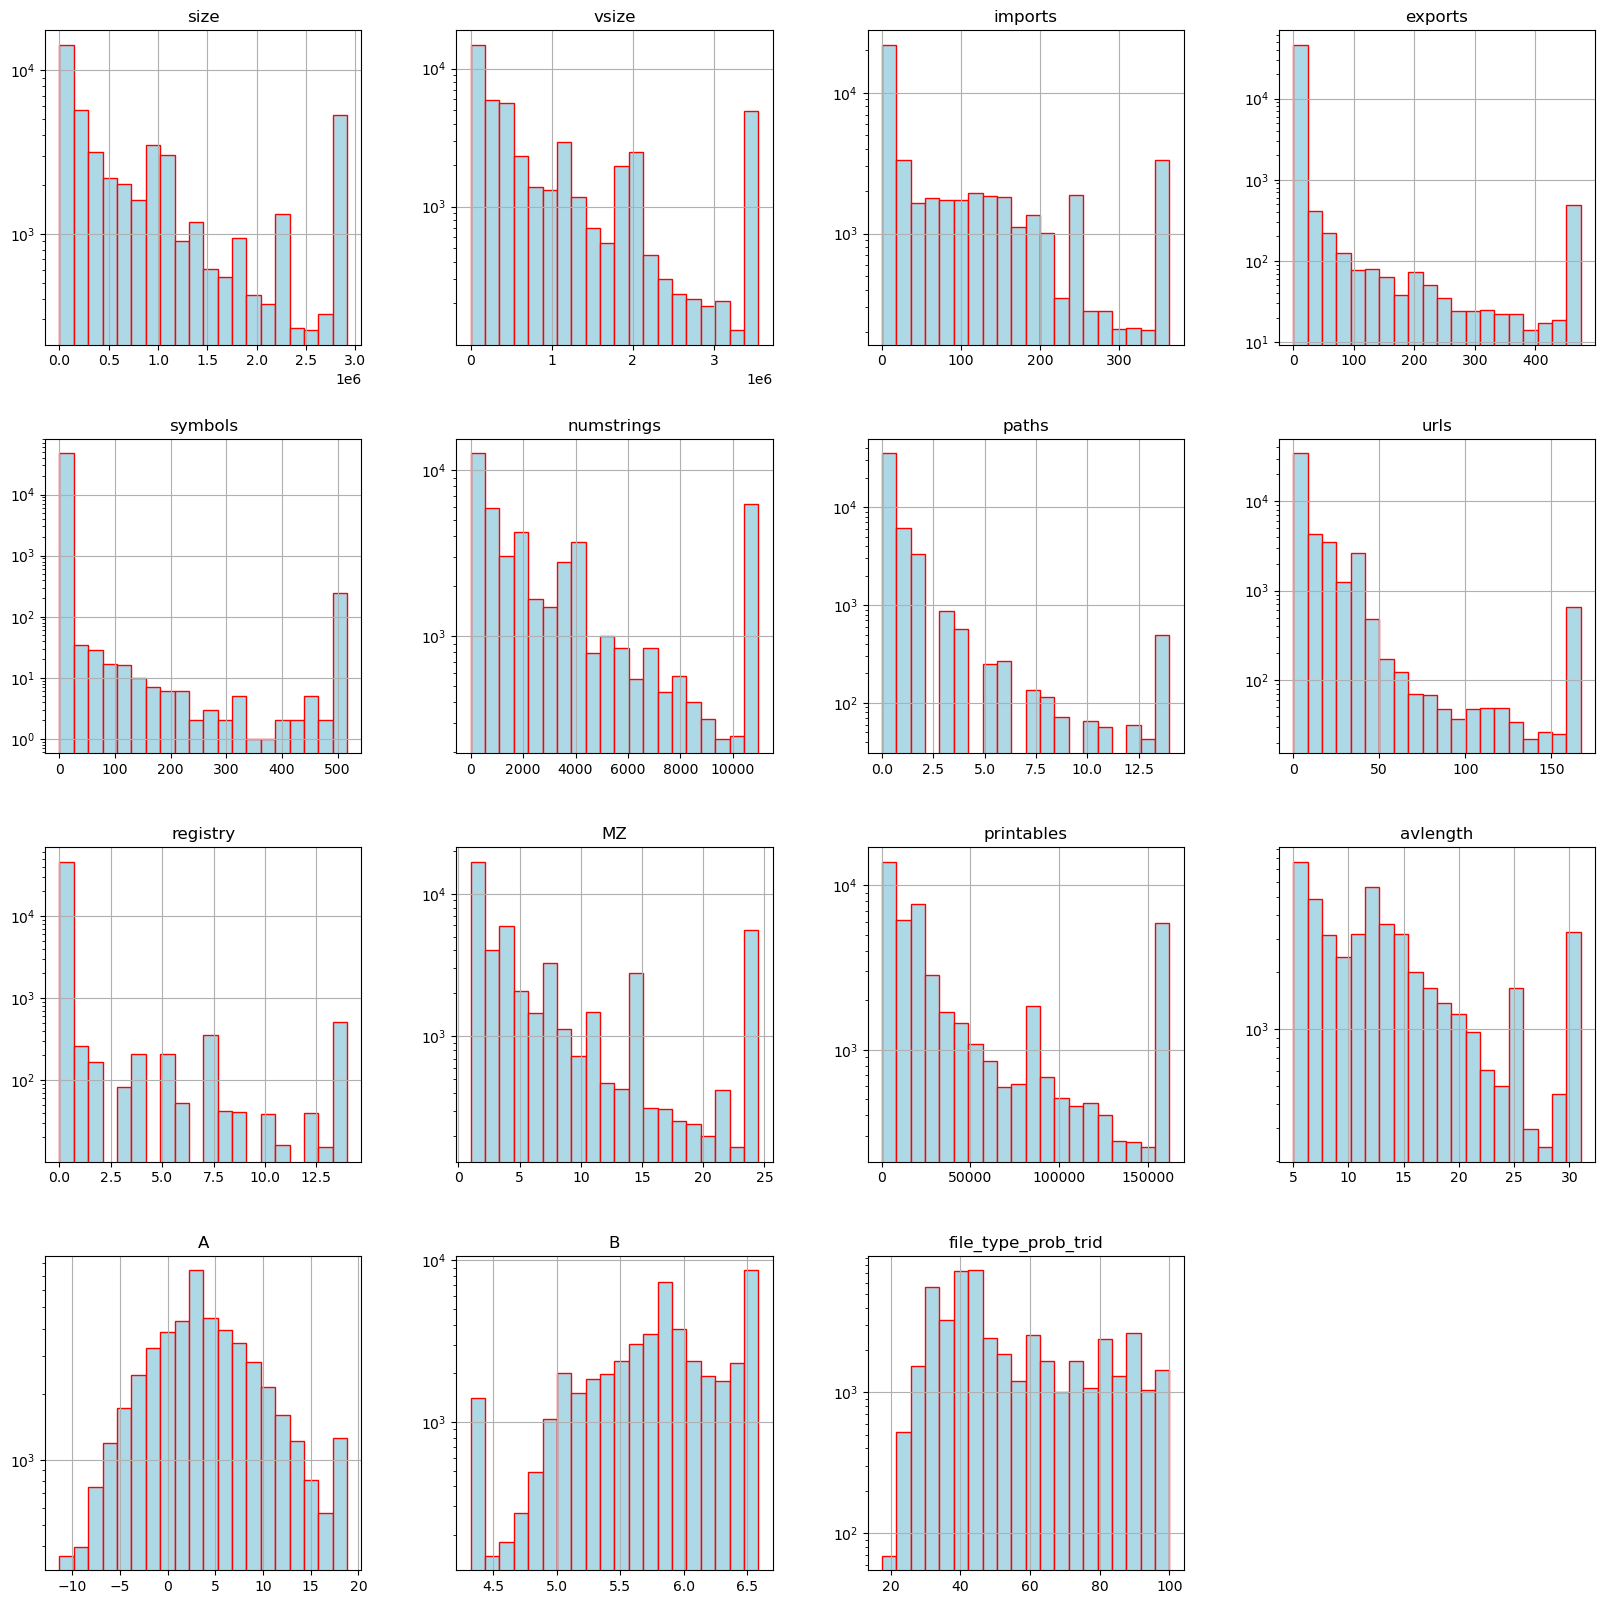

In [255]:
X_train_n.loc[:, numeric].hist(bins = 20, figsize=(20, 20), color='lightblue', edgecolor='red', log = True)

plt.show()

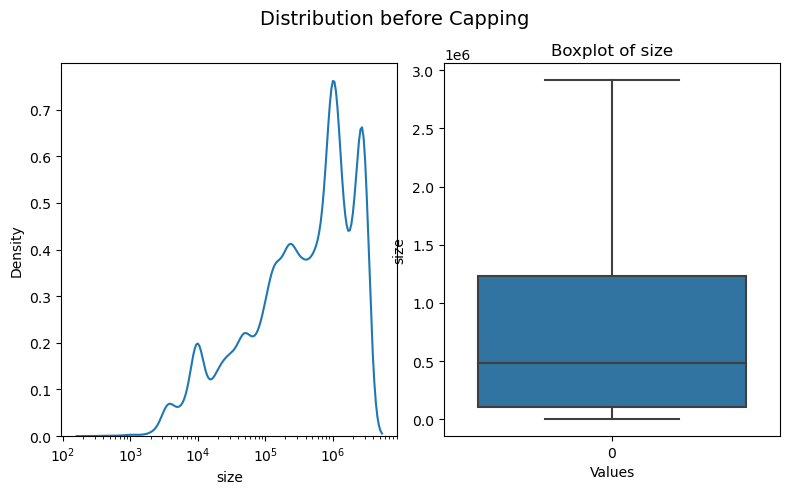

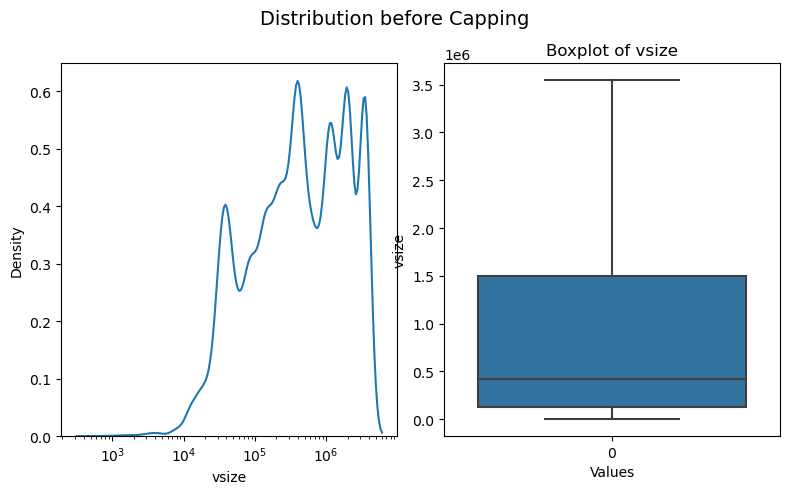

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/3965835139.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


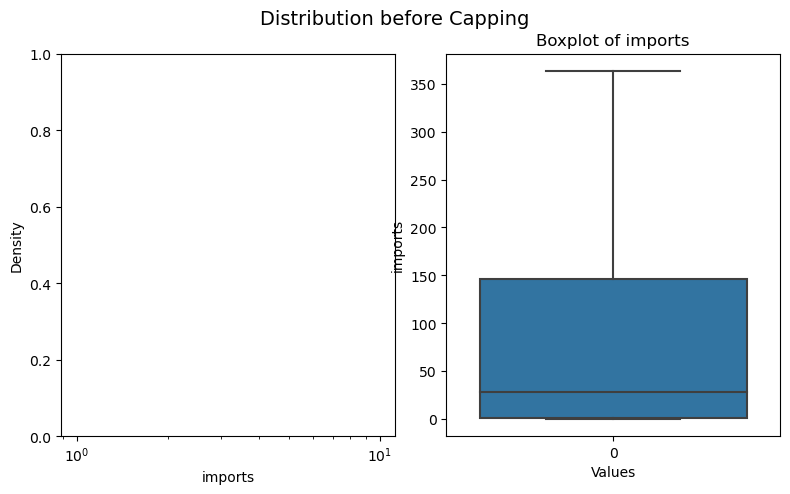

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/3965835139.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


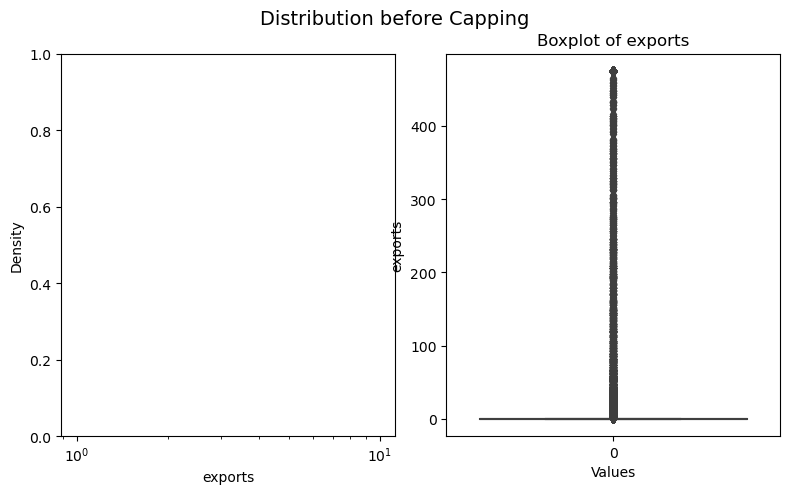

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/3965835139.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


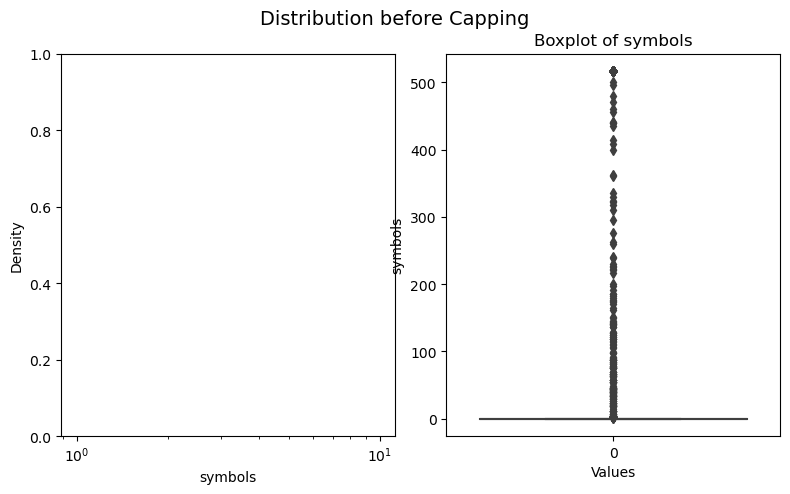

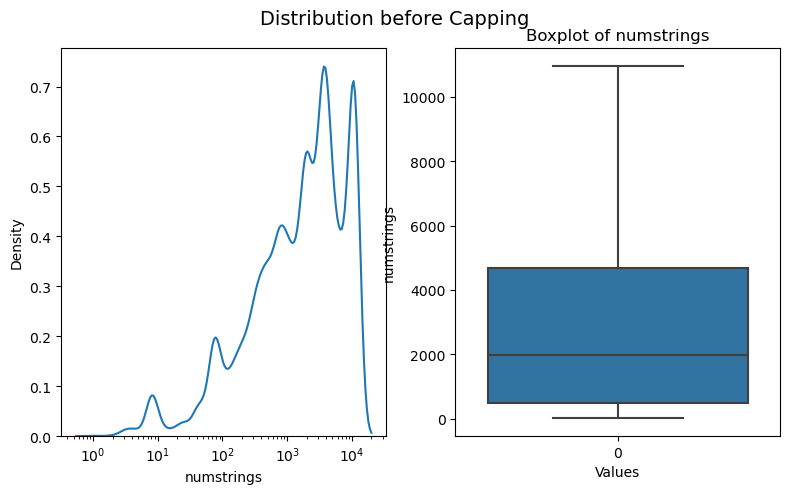

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/3965835139.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


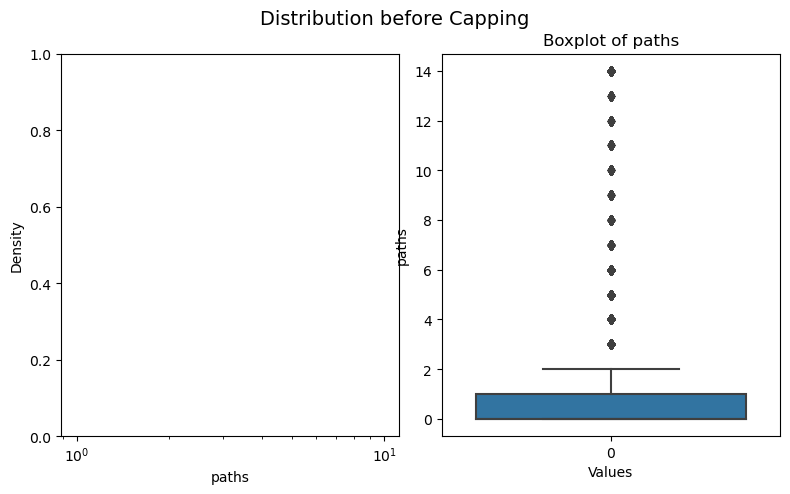

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/3965835139.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


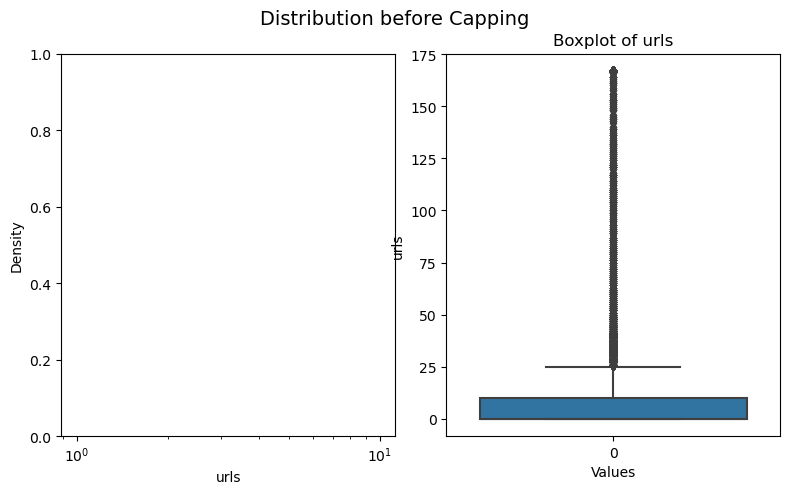

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/3965835139.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data =X_train_n[column] , log_scale=True)


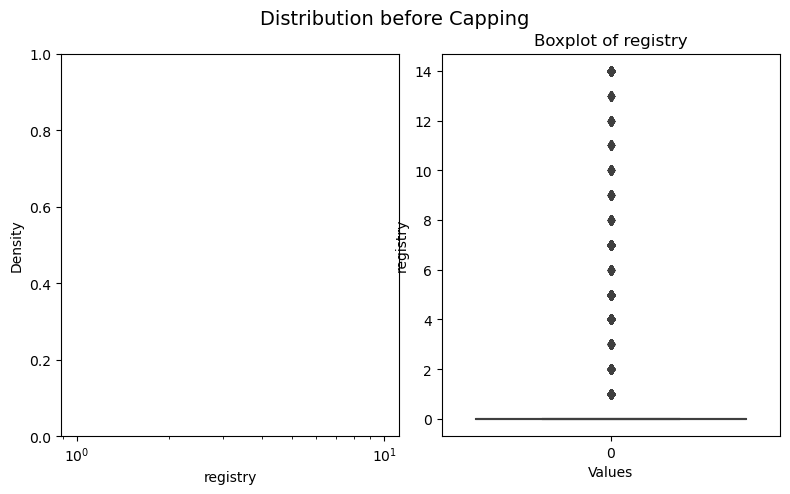

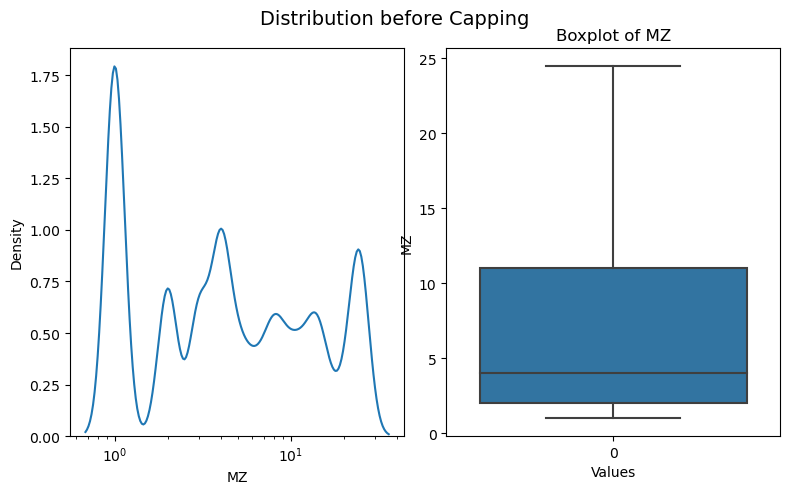

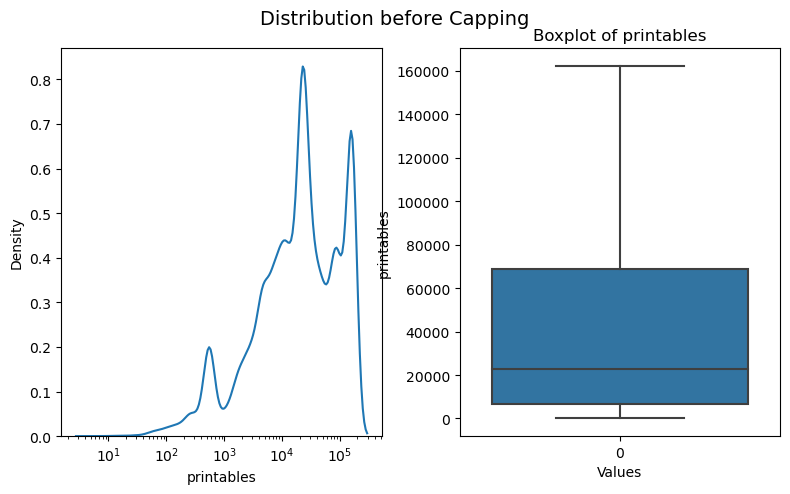

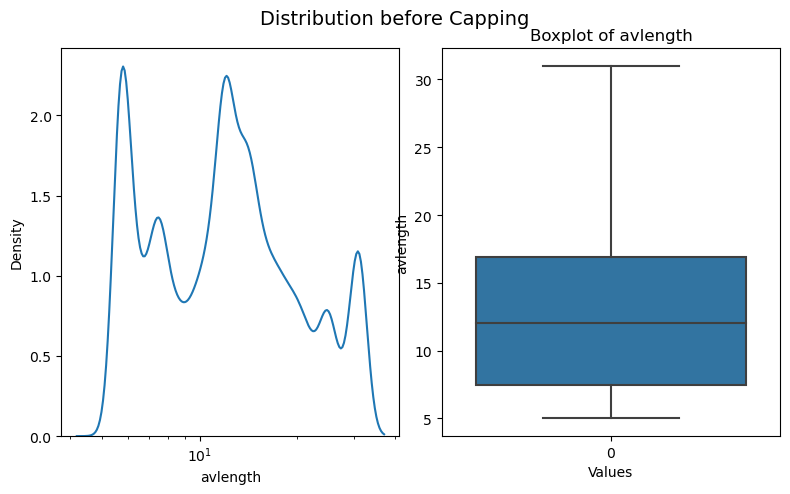

/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


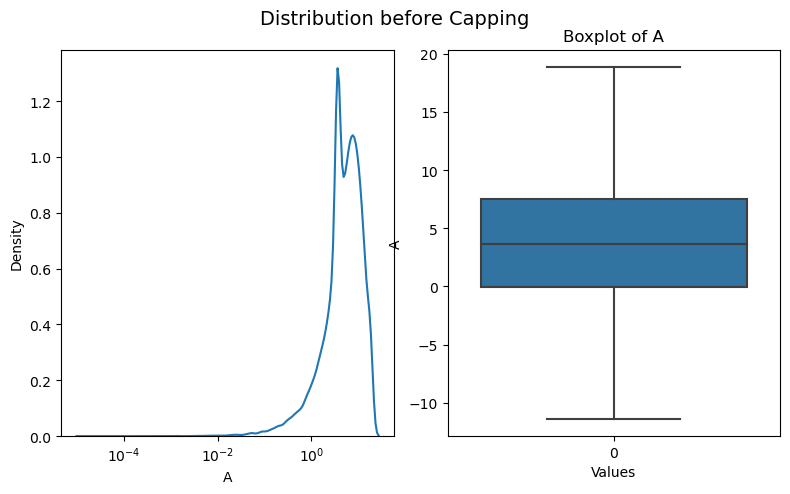

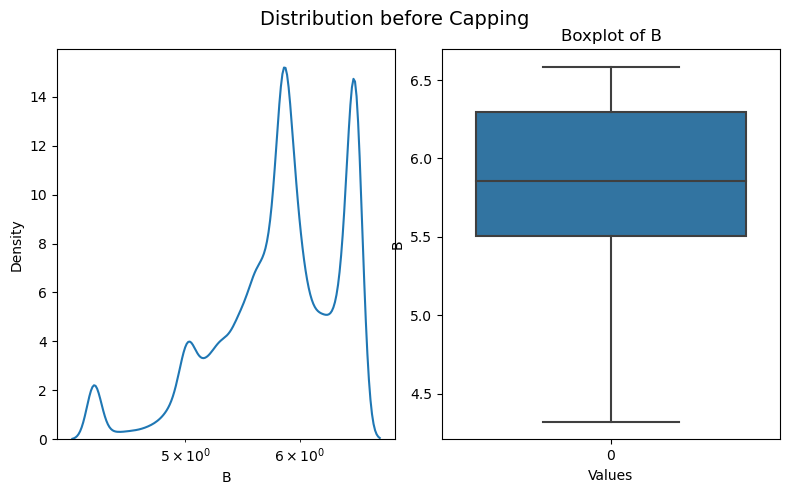

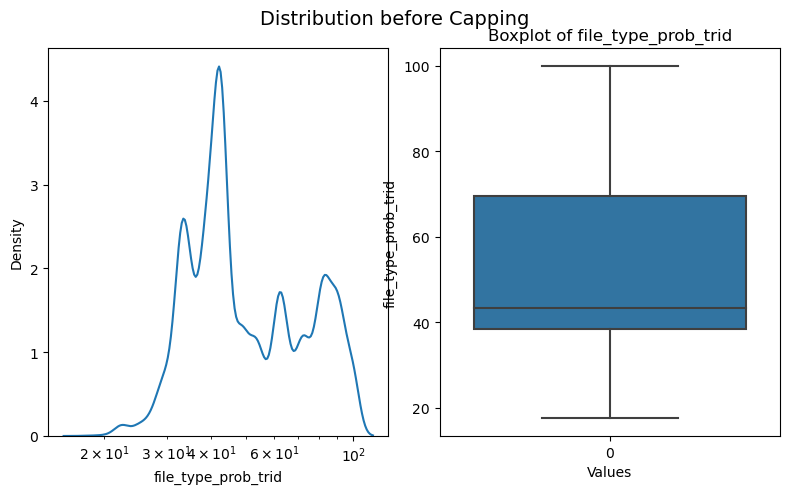

In [256]:


numeric_columns = X_train_n.loc[:, numeric]

for column in numeric_columns:
    plt.figure(figsize=(8,5))
    plt.suptitle("Distribution before Capping", fontsize=14)
    plt.subplot(1,2,1)
    sns.kdeplot(data =X_train_n[column] , log_scale=True)
    plt.subplot(1,2,2)
    sns.boxplot(data  = X_train_n[column])
    plt.tight_layout()
    plt.xlabel('Values')
    plt.ylabel(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

    We can see a significant improvment!

## feature engineering and evaluation

### Categorical features

After many attempts and research, we considerd 3 ways to handle the categorical features.
1. the first method we considered, as mentioned earlier, is **creating dummies**. this method isnt sutible for our dataset because of the many diffrant values the categorical features contain which causes large dimantionality in the reainset.

2. the second method we tried is to simpely **drop** the categorical features.

3. the last method is **ordinal encoding**. knowing that the number we assing to each value crates order relation between the values, we choose to encode each value to it's row count value in the train set. 

Categorical features - in categorical features that contain non-numerical values (words) we would have to decide on a method for encoding the variables -

The first method we tried is creating dummies columns, basically a method that creates columns as the number of different values in the feature. As we mentioned earlier in these columns (file_type_trid, C) there are a large number of different values, even after dealing with the outliers.. therefore using it adds about 35 columns and significantly increases the dimensionallity of the data and harms the prediction. That's why we switched to using the other two methods.

The second method for coding the categoricals is to simply get rid of them! We also tried this method, (the data after removing the categoricals is called X_train_drop_cat, X_test_drop_cat)

The third method we tried is ordinal encoding. With this method, the object values are replaced with numerical values. Understanding that by replacing the values with numbers we create an order relation between the different values, we chose to replace each value with the number of times it appeared in the train set. Thus more common values will get larger numbers. And the order relation created is based on the frequency of the value and says something about the original data.

In addition, we built a new feature 'interactions_file_type_trid_C' containing the various combinations between the values of the two features. We also encoded it.

In [257]:
#dealing with categorical features

#the second method - drop categorical features
def drop_categorical_features(X_train_n, X_test, categorical):
    #train
    X_train_drop_cat = X_train_n.drop(categorical,axis = 1)
    #test
    X_test_drop_cat = X_test.drop(categorical,axis = 1)
    
    return X_train_drop_cat ,  X_test_drop_cat


In [258]:
X_train_drop_cat , X_test_drop_cat = drop_categorical_features(X_train_n, X_test, categorical)


In [259]:
X_train_drop_cat.head()

has_debug  has_relocations  has_resources  has_signature  has_tls  \
48572        0.0              1.0            1.0            1.0      1.0   
38696        0.0              0.0            1.0            1.0      0.0   
13611        0.0              0.0            1.0            1.0      0.0   
35213        0.0              0.0            1.0            0.0      0.0   
31766        0.0              0.0            1.0            0.0      0.0   

            size     vsize  imports  exports  symbols  numstrings  paths  \
48572   600848.0  638976.0    209.0      0.0      0.0      5382.0    0.0   
38696  1102936.0  180224.0    122.0      0.0      0.0      1990.0    0.0   
13611   431944.0  188416.0     28.0      0.0      0.0      2123.0    1.0   
35213   873472.0  991232.0     88.0      0.0      0.0       337.0    0.0   
31766    48055.0  217088.0    155.0      0.0      0.0       328.0    0.0   

       urls  registry    MZ  printables   avlength         A         B  \
48572  32.0       0.0   1.0     64130.0  11.915645 -1.671498  5.869204   
38696  18.0       0.0  17.0     30989.0   6.360632 -4.373939  6.541799   
13611  13.0       0.0   9.0     15523.0  12.026422 -0.250451  6.433637   
35213   0.0       5.0   1.0      5445.0  16.157270  0.634696  5.136413   
31766   1.0       0.0   4.0      4668.0  12.026422  2.224836  5.590438   

       file_type_prob_trid  
48572                 47.5  
38696                 38.8  
13611                 94.8  
35213                 37.8  
31766                 94.6

#### Next, we created two ordinal encoded categorical features, based on the features 'file_type_trid' and another feature we created from the combination of 'file_type_trid' and 'C'.

    the ordinal encoding was done by assigning to each value its row count in the train set.

In [260]:
def ordinal_encode_categorical_f(X_train_n, X_test,  numeric):    
    #the third method - ordinal encoding
    #train
    categorical_features = X_train_n.drop(numeric,axis =1)
    #test
    categorical_features_test = X_test.drop(numeric,axis =1)

    #feature generation
    #create a third categorical features that contains the combination of the 2 other features
    a =  X_train_n['file_type_trid'].astype(str)
    b =  X_train_n['C'].astype(str)

    at =  X_test['file_type_trid'].astype(str)
    bt =  X_test['C'].astype(str)

    categorical_features['interactions_file_type_trid_C'] = a + "_" + b
    categorical_features_test['interactions_file_type_trid_C'] = at + "_" + bt

    #ordinal encode the features, asigning to each value its row count in the train set

    categorical_ordinal = ['file_type_trid','C','interactions_file_type_trid_C']

    category_counts1 = X_train_n['file_type_trid'].value_counts()
    # Create a new column to store the encoded values
    categorical_features['file_type_trid_count_encoded'] = X_train_n['file_type_trid'].map(category_counts1)
    # Repeat the same process for the test dataset
    categorical_features_test['file_type_trid_count_encoded'] = X_test['file_type_trid'].map(category_counts1)
    
    category_counts2 = X_train_n['C'].value_counts()
    # Create a new column to store the encoded values
    categorical_features['C_count_encoded'] = X_train_n['C'].map(category_counts2)
    # Repeat the same process for the test dataset
    categorical_features_test['C_count_encoded'] = X_test['C'].map(category_counts2)

    

    category_counts3 = categorical_features['interactions_file_type_trid_C'].value_counts()
    # Create a new column to store the encoded values
    categorical_features['interactions_file_type_trid_C_count_encoded'] = categorical_features['interactions_file_type_trid_C'].map(category_counts3)
    # Repeat the same process for the test dataset
    categorical_features_test['interactions_file_type_trid_C_count_encoded'] = categorical_features_test['interactions_file_type_trid_C'].map(category_counts3)

    categorical_features.drop(categorical_ordinal,axis = 1, inplace= True)
    categorical_features_test.drop(categorical_ordinal,axis = 1, inplace= True)
    
    return categorical_features, categorical_features_test


In [261]:

def select_numeric_features(X_train_n, X_test, y_train,  numeric): 
                
    numeric_features = X_train_n[numeric].copy()
    numeric_features_test = X_test[numeric].copy()

    # Instantiate SelectKBest with a scoring function (e.g., anova f)
    selector = SelectKBest(score_func=f_classif, k=11)  # Select the top 9 features

    # Fit the selector to your data
    selector.fit(numeric_features, y_train)

    # Get the boolean mask of selected features 
    x_selected_numeric = numeric_features.loc[:,selector.get_support()]
    x_test_selected_numeric = numeric_features_test.loc[:,selector.get_support()]

    return x_selected_numeric , x_test_selected_numeric


In [262]:

def concat_x_selected(x_selected_numeric, categorical_features,x_test_selected_numeric, categorical_features_test):

    x_selected = pd.concat([x_selected_numeric, categorical_features],axis=1)
    x_selected_test = pd.concat([x_test_selected_numeric, categorical_features_test],axis=1)
    return x_selected , x_selected_test


In [263]:
#two metodes to handel categorical features
#only numeric
X_train_drop_cat , X_test_drop_cat = drop_categorical_features(X_train_n, X_test, categorical)
#only categorical
X_train_cat_ordinal ,X_test_cat_ordinal = ordinal_encode_categorical_f(X_train_n, X_test , numeric)
    
#dimmantionality reduction
#selected categorical
X_train_selected= X_train_cat_ordinal.drop(['interactions_file_type_trid_C_count_encoded' , 'C_count_encoded'], axis = 1)
X_test_selected= X_test_cat_ordinal.drop(['interactions_file_type_trid_C_count_encoded' , 'C_count_encoded'], axis = 1)
    
#numeric feature reduction
#selected numeric
X_train_selected_drop , X_test_selected_drop  = select_numeric_features(X_train_drop_cat , X_test_drop_cat, y_train,  numeric)
    
#numeric reducuction and ordinal reductuon
X_train_selected , X_test_selected = concat_x_selected(X_train_selected_drop, X_train_selected,X_test_selected_drop, X_test_selected)
#no feature selection
X_train_full , X_test_full = concat_x_selected(X_train_drop_cat, X_train_cat_ordinal,X_test_drop_cat, X_test_cat_ordinal)
    

In [299]:
X_train_cat_ordinal.head()

has_debug  has_relocations  has_resources  has_signature  has_tls  \
48572        0.0              1.0            1.0            1.0      1.0   
38696        0.0              0.0            1.0            1.0      0.0   
13611        0.0              0.0            1.0            1.0      0.0   
35213        0.0              0.0            1.0            0.0      0.0   
31766        0.0              0.0            1.0            0.0      0.0   

       file_type_trid_count_encoded  C_count_encoded  \
48572                           939             9267   
38696                          7175             9267   
13611                           811             4096   
35213                          7175             4475   
31766                           811            18617   

       interactions_file_type_trid_C_count_encoded  
48572                                          172  
38696                                         1385  
13611                                           71  
35213                                          689  
31766                                          299

#### Based on what we have seen in the data exploring section, we tried to remove the feature 'has_relocation' and see if it improves the prediction. 

    the removal actually harmed the auc so we didn'n do it evantually

In [264]:
'''categorical_features.drop('has_relocations', axis = 1, inplace= True)
categorical_features_test.drop('has_relocations', axis = 1, inplace= True)'''

"categorical_features.drop('has_relocations', axis = 1, inplace= True)\ncategorical_features_test.drop('has_relocations', axis = 1, inplace= True)"

## Evaluating the features and feature selecction

sources:
https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

#### Evaluating the categorical features

We used the chi-square implementation in scikit-learn. It computes chi-squared stats between each non-negative feature and class.

This score can be used to evaluate categorical variables in a classification task. It compares the observed distribution of the different classes of target Y among the different categories of the feature, against the expected distribution of the target classes, regardless of the feature categories.

    we used it to asses the value of each categorical feature and decieded not to use 'C_count_encoded' AND 'interactions_file_type_trid_C_count_encoded' because of it.

In [265]:
# Compute chi2 scores for each feature
def evaluate_categorical(x ,y, categorical):
    a = x[categorical].copy()
    chi2_selector = SelectKBest(chi2, k=1)
    chi2_scores, p_values = chi2(a, y)
    features = a.columns
    # Print the chi2 scores for each feature
    for feature, score in zip(features, chi2_scores):
        print(f"Feature: {feature}, Chi2 Score: {score}")
    return


In [266]:
categorical_ordinal_c = ['file_type_trid_count_encoded','C_count_encoded','interactions_file_type_trid_C_count_encoded','has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']

In [267]:

evaluate_categorical(X_train_cat_ordinal, y_train, categorical_ordinal_c)

Feature: file_type_trid_count_encoded, Chi2 Score: 270960.63419307314
Feature: C_count_encoded, Chi2 Score: 106.96354412969151
Feature: interactions_file_type_trid_C_count_encoded, Chi2 Score: 67327.72962205758
Feature: has_debug, Chi2 Score: 2726.914879019532
Feature: has_relocations, Chi2 Score: 453.34910522150204
Feature: has_resources, Chi2 Score: 89.85372037597872
Feature: has_signature, Chi2 Score: 2758.0494347533936
Feature: has_tls, Chi2 Score: 676.5032338752663


    Also tried using sklearn's select k best with chi squer score but it resulted in lower AUC so we chose to remove features manually in the categorical case. 

In [268]:
def select_chi(X_train,X_test,y_train,k):

    selector = SelectKBest(score_func=chi2, k= k)  # Select the top k features
    selector.fit(X_train, y_train)

    selected_train_features = X_train.loc[:, selector.get_support()]
    selected_test_features = X_test.loc[:, selector.get_support()]

    return selected_train_features,  selected_test_features

x_selected_cat , x_test_selected_cat = select_chi(X_train_cat_ordinal, X_test_cat_ordinal, y_train,5)

In [269]:
X_train_cat_ordinal.head()

has_debug  has_relocations  has_resources  has_signature  has_tls  \
48572        0.0              1.0            1.0            1.0      1.0   
38696        0.0              0.0            1.0            1.0      0.0   
13611        0.0              0.0            1.0            1.0      0.0   
35213        0.0              0.0            1.0            0.0      0.0   
31766        0.0              0.0            1.0            0.0      0.0   

       file_type_trid_count_encoded  C_count_encoded  \
48572                           939             9267   
38696                          7175             9267   
13611                           811             4096   
35213                          7175             4475   
31766                           811            18617   

       interactions_file_type_trid_C_count_encoded  
48572                                          172  
38696                                         1385  
13611                                           71  
35213                                          689  
31766                                          299

Checking to see the results with different k

In [270]:
x_selected_cat.head()

has_debug  has_signature  has_tls  file_type_trid_count_encoded  \
48572        0.0            1.0      1.0                           939   
38696        0.0            1.0      0.0                          7175   
13611        0.0            1.0      0.0                           811   
35213        0.0            0.0      0.0                          7175   
31766        0.0            0.0      0.0                           811   

       interactions_file_type_trid_C_count_encoded  
48572                                          172  
38696                                         1385  
13611                                           71  
35213                                          689  
31766                                          299

In [271]:
x_test_selected_cat.head()

has_debug  has_signature  has_tls  file_type_trid_count_encoded  \
12628        0.0            0.0      0.0                          7175   
37730        1.0            1.0      0.0                          2580   
39991        0.0            0.0      0.0                          1389   
8525         1.0            1.0      0.0                          8040   
8279         1.0            1.0      1.0                          8040   

       interactions_file_type_trid_C_count_encoded  
12628                                         2831  
37730                                          256  
39991                                          127  
8525                                          1556  
8279                                          1556

#### Numeric features

#### Variance threshold
Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features.

    We wanted to see if we have features that have the same value in all sampels or quasi-constant, the exam showed that none of the features are like this.

In [272]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(X_train_drop_cat)
print(sum(sel.get_support()))
print(len(numeric))

20
15


#### Select numeric features based on ANOVA F-value score

The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different.

In [273]:

# Compute ANOVA F-value scores for each feature
f_scores, p_values = f_classif(X_train_drop_cat, y_train)

featuresn = X_train_drop_cat.columns
# Sort the features based on ANOVA F-value scores in descending order
sorted_features = sorted(zip(featuresn, f_scores), key=lambda x: x[1], reverse=True)

# Print the ANOVA F-value scores for each feature in descending order
for feature, score in sorted_features:
    print(f"Feature: {feature}, ANOVA F-value Score: {score}")


Feature: has_debug, ANOVA F-value Score: 4878.165000521474
Feature: B, ANOVA F-value Score: 4209.199256563679
Feature: has_signature, ANOVA F-value Score: 3954.388154658322
Feature: avlength, ANOVA F-value Score: 2251.296925118434
Feature: MZ, ANOVA F-value Score: 1546.5042598181483
Feature: has_relocations, ANOVA F-value Score: 947.577998469293
Feature: paths, ANOVA F-value Score: 921.0359971170473
Feature: has_tls, ANOVA F-value Score: 886.1998358484411
Feature: vsize, ANOVA F-value Score: 747.4546709187489
Feature: has_resources, ANOVA F-value Score: 539.8322573722048
Feature: size, ANOVA F-value Score: 495.7250040615329
Feature: exports, ANOVA F-value Score: 354.2400275049423
Feature: urls, ANOVA F-value Score: 333.6432470618722
Feature: registry, ANOVA F-value Score: 234.2580412952563
Feature: symbols, ANOVA F-value Score: 193.62059883061664
Feature: numstrings, ANOVA F-value Score: 98.92981862841629
Feature: file_type_prob_trid, ANOVA F-value Score: 88.16752377080448
Feature: pri

    We ended up using the sklearn's SelectKBest with anova f-value score to choose the 10 best numeric features' this code portion is included in the create_x_selected function

#### Creating the selected data set with both numeric and categorical features

Testing to see the impact of the selection

In [274]:
X_train_selected.head(10)

size     vsize  exports  symbols  numstrings  paths  urls  \
48572   600848.0  638976.0      0.0      0.0      5382.0    0.0  32.0   
38696  1102936.0  180224.0      0.0      0.0      1990.0    0.0  18.0   
13611   431944.0  188416.0      0.0      0.0      2123.0    1.0  13.0   
35213   873472.0  991232.0      0.0      0.0       337.0    0.0   0.0   
31766    48055.0  217088.0      0.0      0.0       328.0    0.0   1.0   
57477    94208.0   94208.0      2.0      0.0       377.0    0.0   0.0   
9165     48050.0  217088.0      0.0      0.0       334.0    0.0   1.0   
21399   305924.0   45056.0      0.0      0.0      1300.0    1.0   0.0   
44113    10784.0   40960.0      6.0     27.0        98.0    0.0   0.0   
55436   159157.0   90112.0      0.0      0.0      1023.0    4.0   0.0   

       registry    MZ   avlength         B  has_debug  has_relocations  \
48572       0.0   1.0  11.915645  5.869204        0.0              1.0   
38696       0.0  17.0   6.360632  6.541799        0.0              0.0   
13611       0.0   9.0  12.026422  6.433637        0.0              0.0   
35213       5.0   1.0  16.157270  5.136413        0.0              0.0   
31766       0.0   4.0  12.026422  5.590438        0.0              0.0   
57477       0.0   1.0  13.618037  5.971061        0.0              1.0   
9165        0.0   1.0  14.152695  5.607190        0.0              0.0   
21399       0.0   7.0   6.394615  6.521569        0.0              0.0   
44113       0.0   4.0  15.836735  5.334319        1.0              1.0   
55436       0.0   2.0  26.680352  5.639970        0.0              0.0   

       has_resources  has_signature  has_tls  file_type_trid_count_encoded  
48572            1.0            1.0      1.0                           939  
38696            1.0            1.0      0.0                          7175  
13611            1.0            1.0      0.0                           811  
35213            1.0            0.0      0.0                          7175  
31766            1.0            0.0      0.0                           811  
57477            1.0            0.0      0.0                          7175  
9165             1.0            0.0      0.0                           811  
21399            1.0            0.0      0.0                          8040  
44113            0.0            0.0      0.0                          3204  
55436            1.0            0.0      0.0                          3204

#### Scale train and test

In [275]:
X_train_selected , X_test_selected = scaling_data( X_train_selected , X_test_selected)
X_train_full , X_test_full = scaling_data(X_train_full , X_test_full)
X_train_selected_drop , X_test_selected_drop = scaling_data( X_train_selected_drop , X_test_selected_drop)


#### Dimensionality reduction using PCA

Use pca with 0.99 explained variance, on our datasets.


In [276]:


def apply_pca(X_train, X_test, explained_variance=0.99):
    print(X_train.shape)
    pca = PCA(explained_variance)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(X_train_pca.shape)
    return pd.DataFrame(X_train_pca), pd.DataFrame(X_test_pca)


backward selection, chose not to use.

In [277]:
'''knn = KNeighborsClassifier(n_neighbors=4)
sfs1 = SFS(knn, 
           k_features=15, 
           forward = False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train), y_train)'''

'''x_train_backward = sfs1.transform(X_train)
x_test_backward = sfs1.transform(X_test)'''

'x_train_backward = sfs1.transform(X_train)\nx_test_backward = sfs1.transform(X_test)'

In [278]:
X_train_full_pca , X_test_full_pca = apply_pca(X_train_full , X_test_full)


(48000, 28)
(48000, 21)


# Models

## Logistic Regression

In [279]:

#create logistic regression model, using GridSearchCV for best hiperparameters.
def logistic_reg (X_train, y_train, X_test, y_test, method):
    parameters = {'penalty':['l1','l2'],
                  'C': [10,100,200,300,400],
                  'solver':['liblinear', 'lbfgs']} 
    

    log_reg = LogisticRegression(random_state=42)
    
    gscv = GridSearchCV(log_reg, parameters, scoring='roc_auc',cv=5,refit = True, n_jobs=-1) 
    gscv.fit(X_train, y_train)
    #gscv results:
    parameters_log_reg=gscv.best_params_
    best_log_reg = gscv.best_estimator_
    print(f"Best Logistic Regression Model:\n LogisticRegression(C={best_log_reg.C}, penalty='{best_log_reg.penalty}', fit_intercept={best_log_reg.fit_intercept},solver='{best_log_reg.solver}')")


    best_log_reg2 = LogisticRegression(**parameters_log_reg, random_state=42)
    
    proba = best_log_reg.predict_proba(X_test)
    fit_with_kfold_get_roc(best_log_reg2, X_train, y_train,5)
    get_AUC(proba, y_test, 'Logistic regression', method)
    get_ROC(proba, y_test, 'Logistic regression', method)


    print("done function")


/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Logistic Regression Model:
 LogisticRegression(C=200, penalty='l2', fit_intercept=True,solver='liblinear')


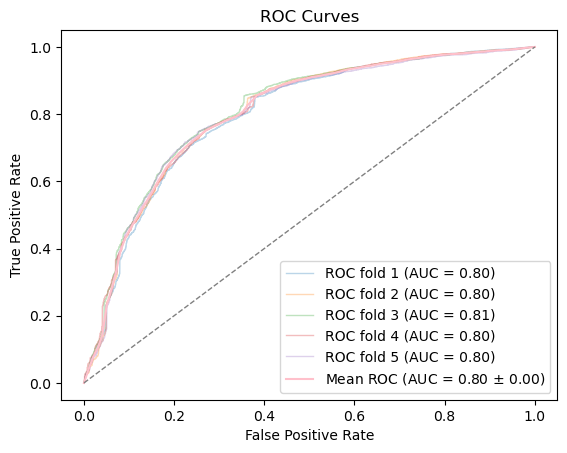

for Logistic regression model, with: encoding categorical features and selecting features AUROC = 0.801


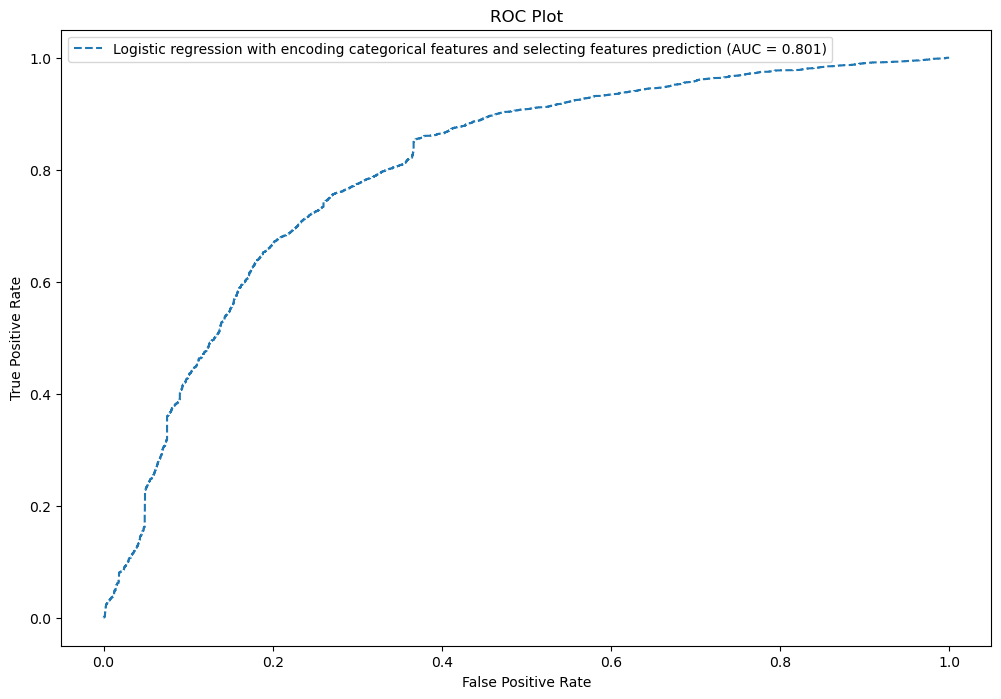

done function


/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Logistic Regression Model:
 LogisticRegression(C=300, penalty='l2', fit_intercept=True,solver='lbfgs')


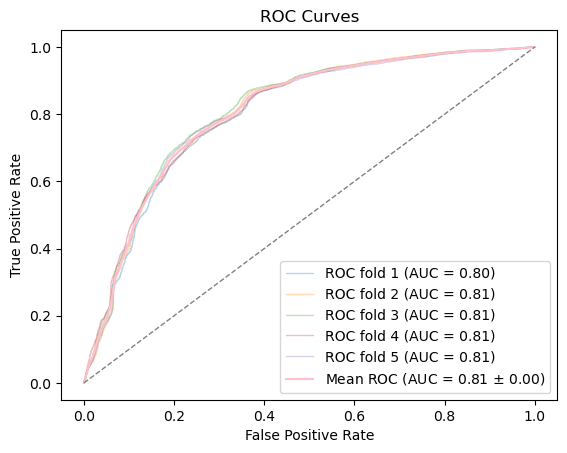

for Logistic regression model, with: no feature selection AUROC = 0.803


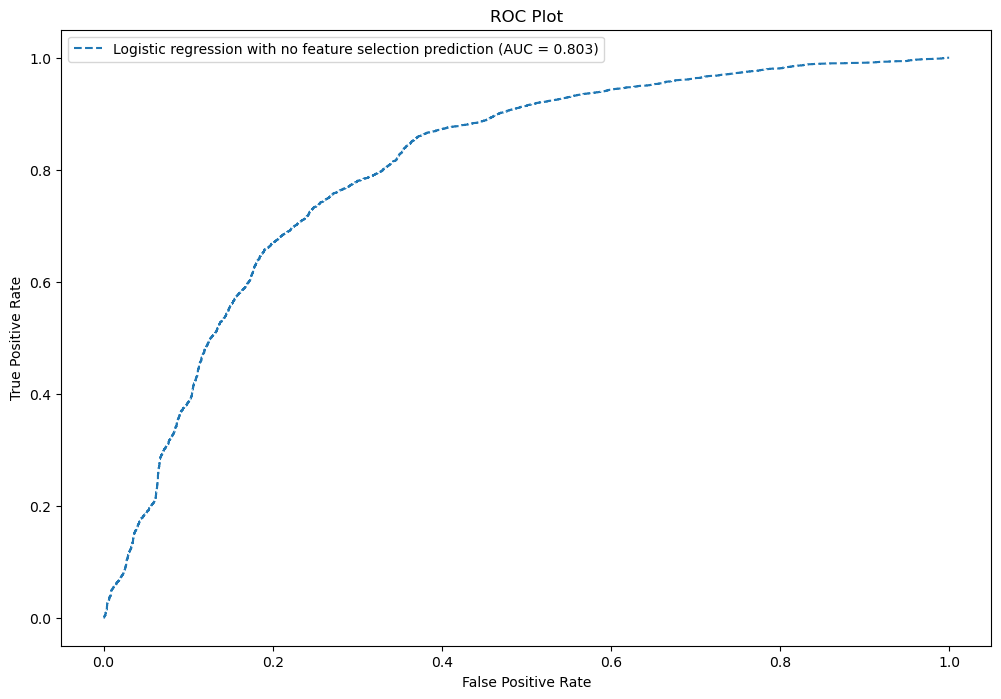

done function


/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Logistic Regression Model:
 LogisticRegression(C=200, penalty='l2', fit_intercept=True,solver='lbfgs')


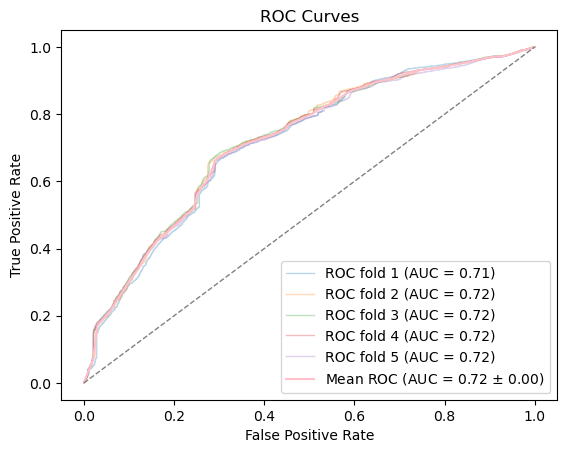

for Logistic regression model, with: drop categorical and select features AUROC = 0.718


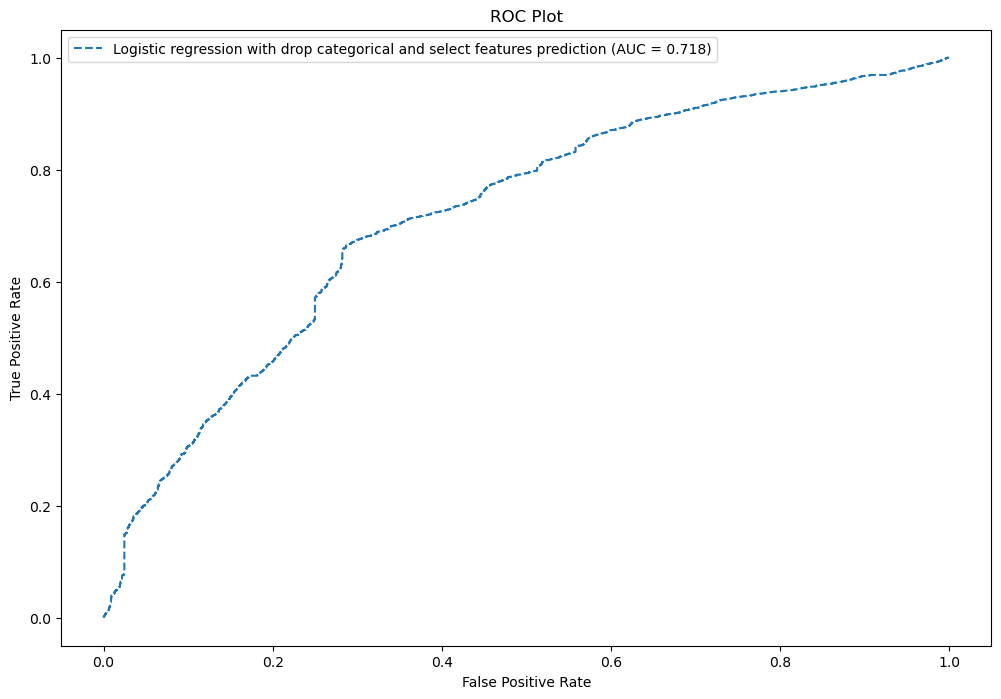

done function


/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lilachcohen/anaconda3/envs/DataScience/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Logistic Regression Model:
 LogisticRegression(C=400, penalty='l2', fit_intercept=True,solver='liblinear')


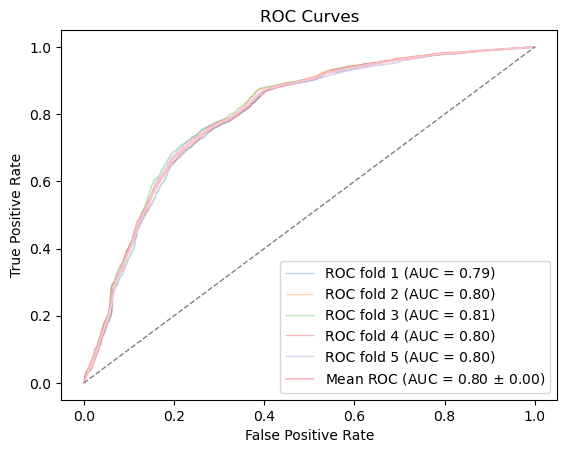

for Logistic regression model, with: no feature selection and pca AUROC = 0.796


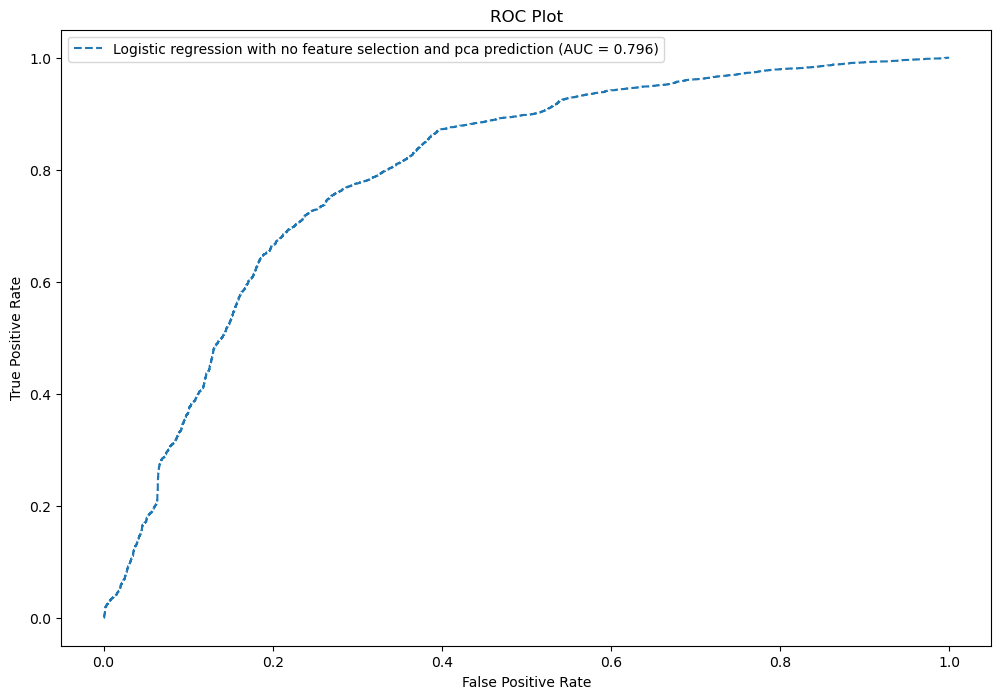

done function


In [280]:

logistic_reg(X_train_selected , y_train, X_test_selected,  y_test, 'encoding categorical features and selecting features')
logistic_reg( X_train_full, y_train , X_test_full, y_test, 'no feature selection' )
logistic_reg(X_train_selected_drop , y_train, X_test_selected_drop, y_test, 'drop categorical and select features')
logistic_reg( X_train_full_pca, y_train , X_test_full_pca, y_test, 'no feature selection and pca' )


## Naive Base

    After concidering the model's performance we decieded not to use it.

In [281]:
#naive bayes classifier:

def Naive_bayes(X_train, y_train, X_test, y_test, method):
    clf_nb = GaussianNB()
    #clf_nb.fit(X_train ,y_train)
    #evaluate the model:
    #proba = clf_nb.predict_proba(X_test)
    #get_AUC(proba, y_test , 'Naive Base' , method)
    #get_ROC(proba, y_test , 'Naive Base' , method)
    fit_with_kfold_get_roc(clf_nb, X_train, y_train ,X_test)

    get_AUC(proba, y_test, 'naive bayes', method)
    get_ROC(proba, y_test, 'naive bayes', method)




## KNN

In [282]:
#knn
def knn(X_train, y_train, X_test, y_test, method, k= 5):
    #create plot to find best k:

    ks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15] # all the k values we will examine
    mean_acc = np.zeros(14)
    # iterate over the different k-values
    for k in range(len(ks)):
        # build our knn regressor model
        knn = KNeighborsClassifier(n_neighbors=ks[k]) # metric='euclidean', algorithm='brute'
        knn.fit(X_train, y_train)
        validation_predictions = knn.predict(X_test)
        mean_acc[k] = metrics.accuracy_score(y_test, validation_predictions)
        # find accuracy score for this k
    
    plt.figure(figsize = (10, 6))
    plt.plot( ks, mean_acc)
    plt.xticks( ks)
    plt.xlabel('Number of Neighbors ')
    plt.ylabel('Accuracy')
    plt.show()
    knn_clf = KNeighborsClassifier(n_neighbors= k) 
    #fit model with k fold
    proba = fit_with_kfold_get_roc2(knn_clf, X_train, y_train, X_test)
    get_AUC(proba, y_test, 'KNN', method)
    get_ROC(proba, y_test, 'KNN', method)



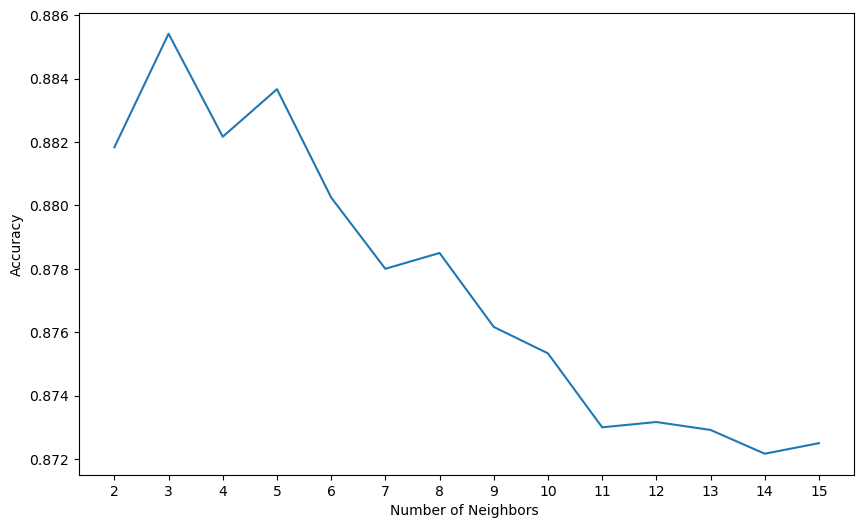

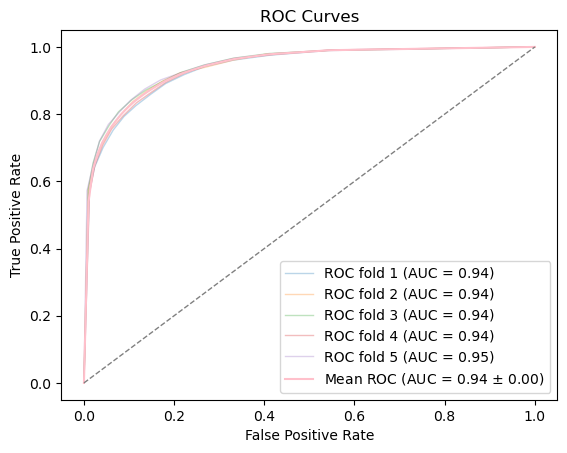

for KNN model, with: encoding categorical features and selecting features AUROC = 0.945


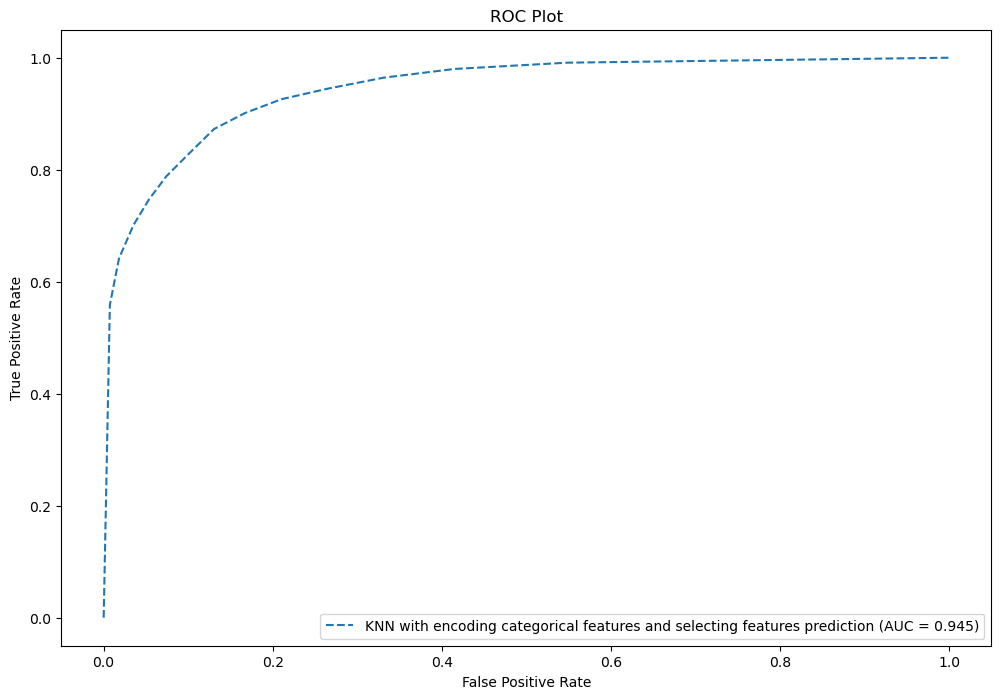

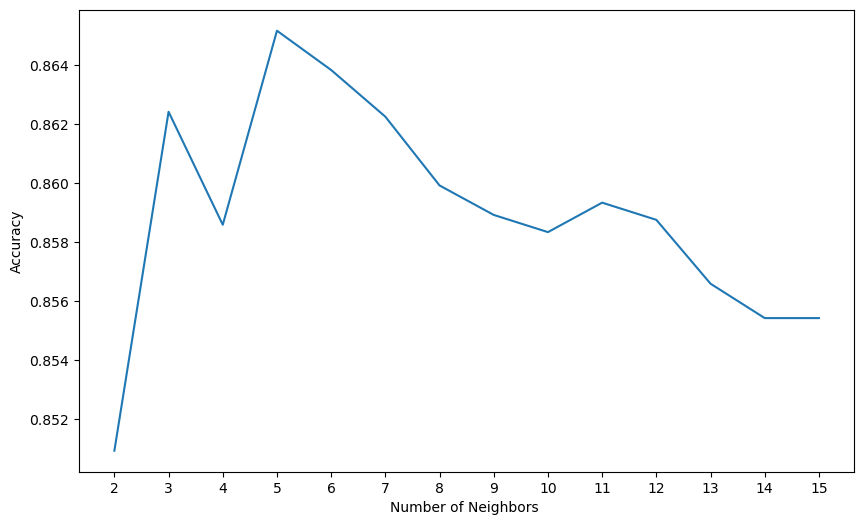

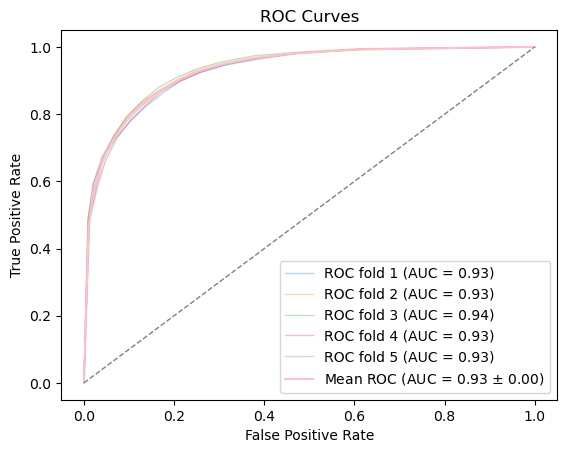

for KNN model, with: no feature selection AUROC = 0.934


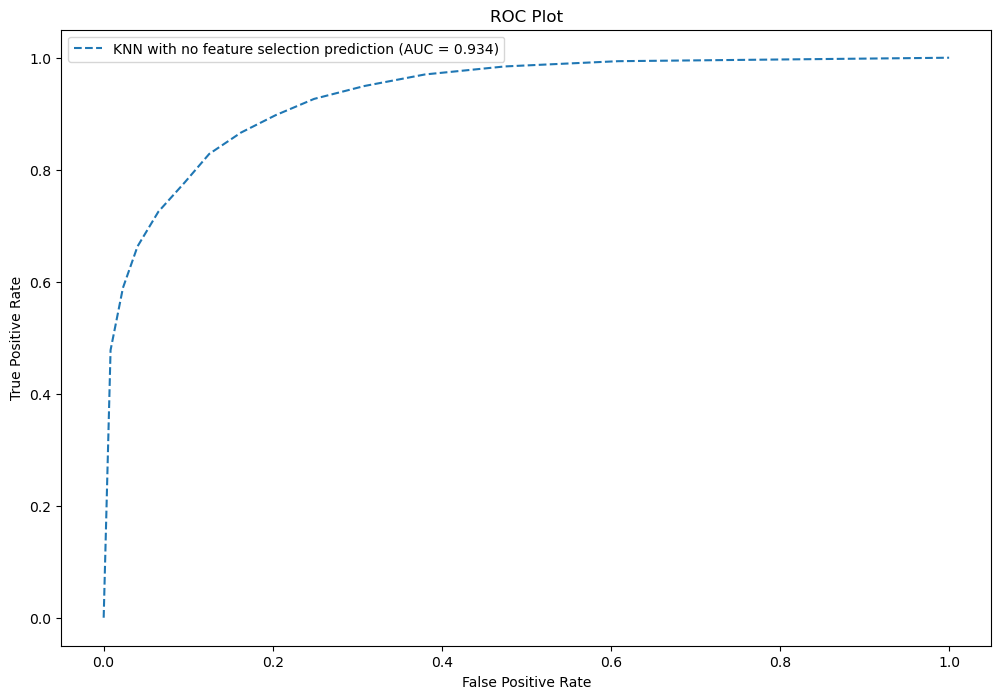

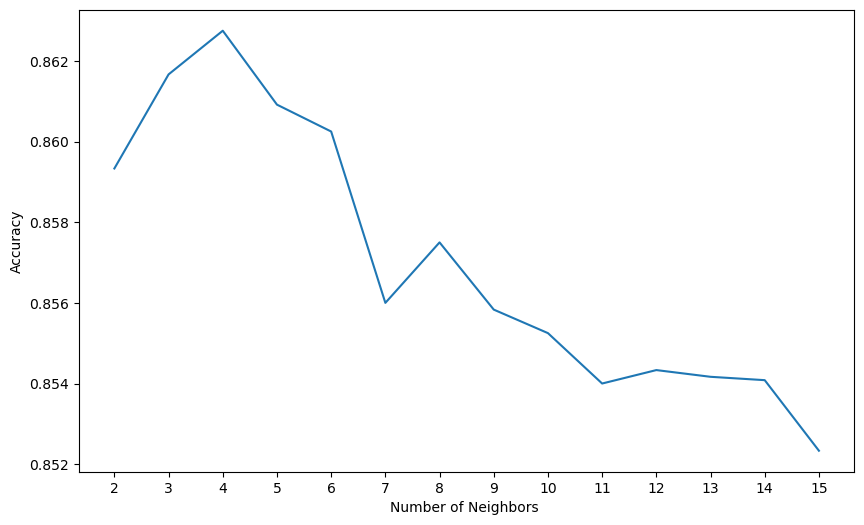

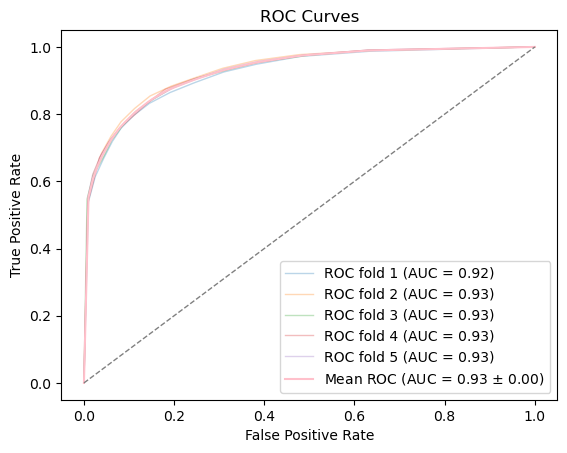

for KNN model, with: drop categorical and select features AUROC = 0.928


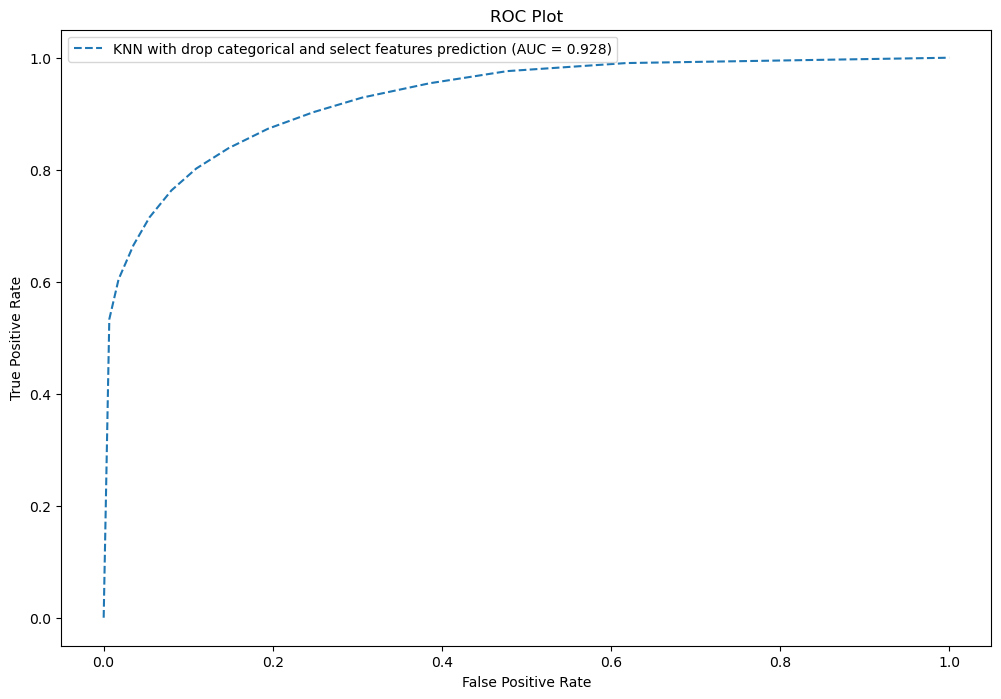

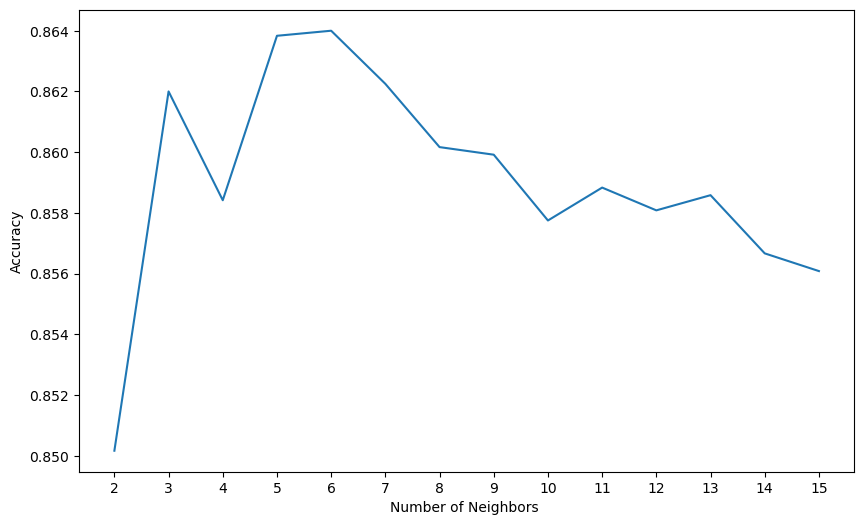

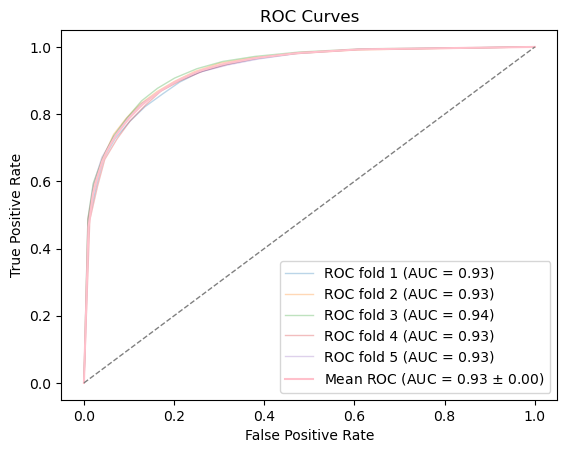

for KNN model, with: no feature selection and pca AUROC = 0.933


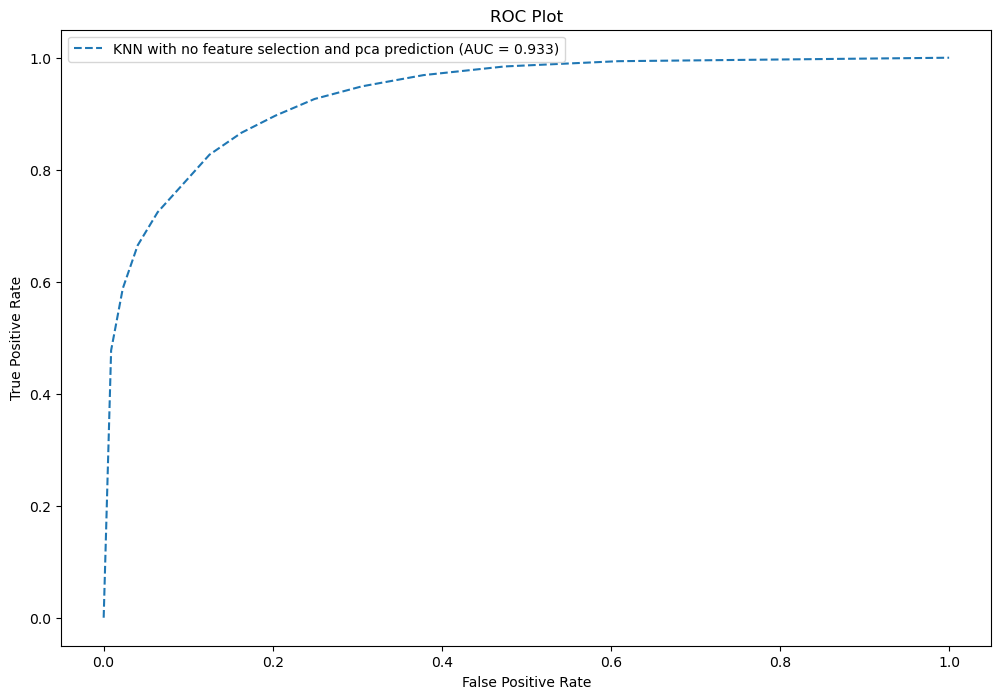

In [283]:
knn(X_train_selected , y_train, X_test_selected,  y_test, 'encoding categorical features and selecting features',3)
knn( X_train_full, y_train , X_test_full, y_test, 'no feature selection' ,5)
knn(X_train_selected_drop , y_train, X_test_selected_drop, y_test, 'drop categorical and select features',4)
knn( X_train_full_pca, y_train , X_test_full_pca, y_test, 'no feature selection and pca',6 )


## Multi- Layer Perceptron 


In [284]:
#multi- layer perceptron 
def multi_layer_perceptron(X_train, y_train, X_test, y_test, method):
    parameters={'hidden_layer_sizes':[(100)], 'alpha':[1e-5], 'solver':['sgd', 'adam'],'activation':['relu','logistic']\
                ,'verbose':[True],'early_stopping':[True],'max_iter':[1000], 'learning_rate_init':[0.01]}
    mlp = MLPClassifier(random_state=42)
    gscv=GridSearchCV(mlp, parameters, scoring='roc_auc', cv=5, refit=True, n_jobs=-1)
    gscv.fit(X_train,y_train)
    parameters_mlp=gscv.best_params_
    print(f"Best Parameters: {parameters_mlp}")
    best_mlp = gscv.best_estimator_
    best_mlp2 = MLPClassifier(**parameters_mlp, random_state=42)
    print(f"Best mlp Model:{best_mlp}")

    proba = best_mlp.predict_proba(X_test)
    fit_with_kfold_get_roc(best_mlp2, X_train, y_train)

    get_AUC(proba, y_test, 'multi- layer perceptron', method)
    get_ROC(proba, y_test, 'multi- layer perceptron', method)
    
    print("done function")
        
    print(f"number of layers: {best_mlp.n_layers_}")
    print(f"layer sizes: {[layer.shape for layer in best_mlp.coefs_]}")
    print(f"layer bias sizes: {[layer.shape for layer in best_mlp.intercepts_]}")
    print(f"final loss reached in training: {best_mlp.loss_}")
    print(f"best loss reached in training: {best_mlp.best_loss_}")
    print(f"accuracy on test set: {best_mlp.score(X_test, y_test)}")


Iteration 1, loss = 0.52889285
Validation score: 0.788281
Iteration 1, loss = 0.53069080
Validation score: 0.786198
Iteration 1, loss = 0.52901576
Validation score: 0.785677
Iteration 1, loss = 0.53174791
Validation score: 0.793229
Iteration 2, loss = 0.46231030
Validation score: 0.802865
Iteration 1, loss = 0.52989795
Validation score: 0.776823Iteration 1, loss = 0.43656821

Validation score: 0.815104
Iteration 2, loss = 0.46444023
Validation score: 0.802083
Iteration 2, loss = 0.46286883
Validation score: 0.796615
Iteration 2, loss = 0.46556718
Validation score: 0.800260
Iteration 1, loss = 0.43932710
Validation score: 0.812760
Iteration 1, loss = 0.43709253
Validation score: 0.819531
Iteration 3, loss = 0.43966553
Validation score: 0.802865
Iteration 2, loss = 0.46404038
Validation score: 0.792969
Iteration 3, loss = 0.43989757
Validation score: 0.806250
Iteration 2, loss = 0.38854807
Validation score: 0.828906
Iteration 3, loss = 0.44180971
Iteration 3, loss = 0.44249943
Validation

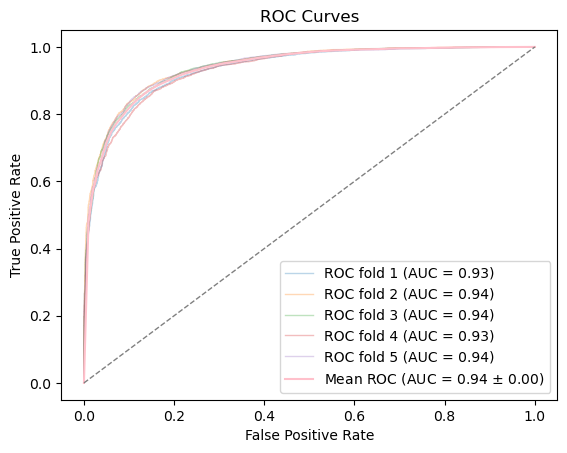

for multi- layer perceptron model, with: encoding categorical features and selecting features AUROC = 0.943


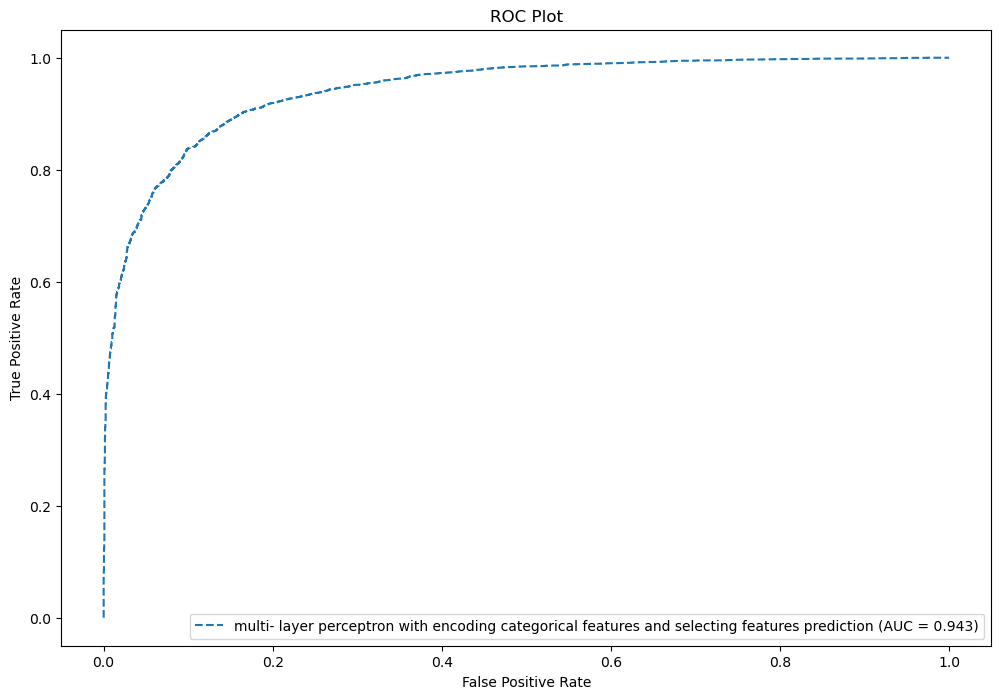

done function
number of layers: 3
layer sizes: [(17, 100), (100, 1)]
layer bias sizes: [(100,), (1,)]
final loss reached in training: 0.2645869406811727
best loss reached in training: None
accuracy on test set: 0.8696666666666667
Iteration 1, loss = 0.52735184
Validation score: 0.786979
Iteration 1, loss = 0.42987423
Validation score: 0.823698
Iteration 1, loss = 0.53191503
Iteration 1, loss = 0.53070387
Validation score: 0.788802
Iteration 1, loss = 0.52995424
Validation score: 0.790885
Validation score: 0.782292
Iteration 1, loss = 0.43645529
Validation score: 0.822656
Iteration 1, loss = 0.52901276
Validation score: 0.790365
Iteration 1, loss = 0.43475497
Validation score: 0.824740
Iteration 2, loss = 0.45879844
Validation score: 0.795052
Iteration 2, loss = 0.37227865
Validation score: 0.839063
Iteration 2, loss = 0.46183736
Validation score: 0.798177
Iteration 2, loss = 0.46130647
Validation score: 0.804688
Iteration 2, loss = 0.46276865
Validation score: 0.801823
Iteration 2, los

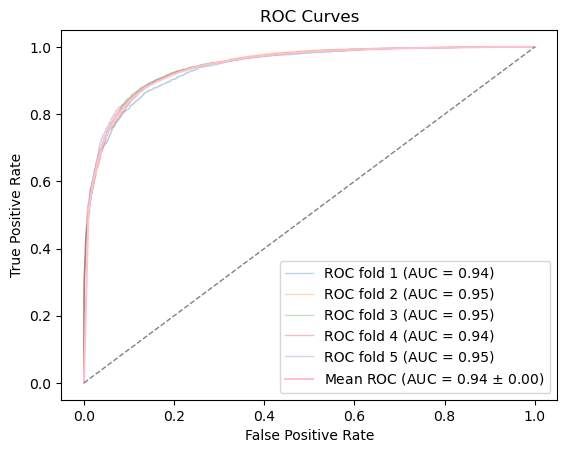

for multi- layer perceptron model, with: no feature selection AUROC = 0.948


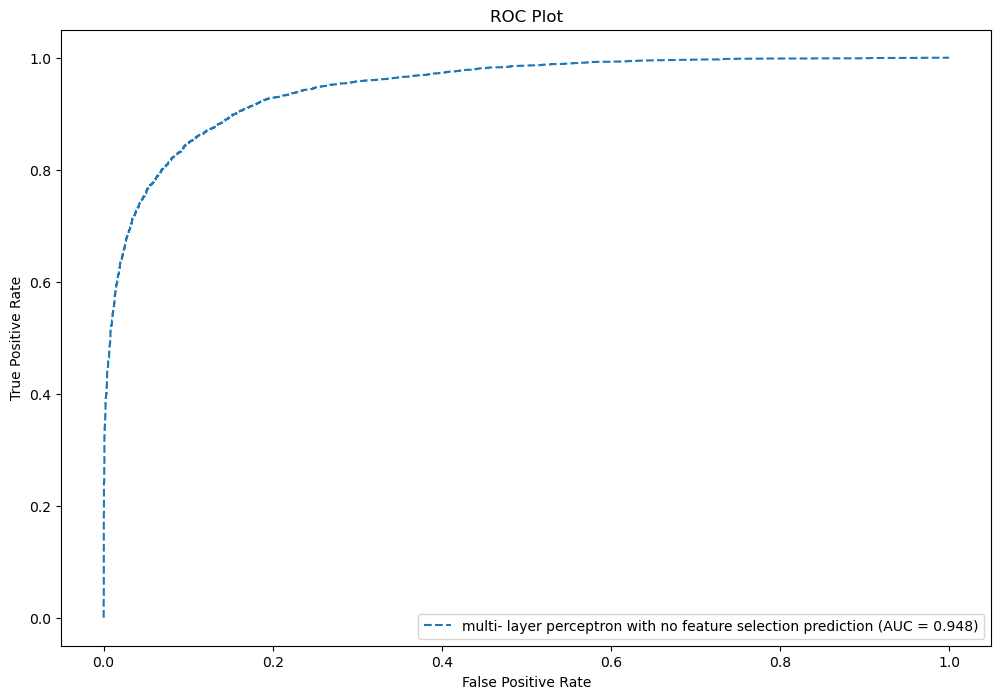

done function
number of layers: 3
layer sizes: [(28, 100), (100, 1)]
layer bias sizes: [(100,), (1,)]
final loss reached in training: 0.24019452353216017
best loss reached in training: None
accuracy on test set: 0.8728333333333333
Iteration 1, loss = 0.50961282
Validation score: 0.777865
Iteration 1, loss = 0.50921435
Validation score: 0.770052
Iteration 1, loss = 0.59650774
Validation score: 0.736979
Iteration 1, loss = 0.59425768
Validation score: 0.736458
Iteration 1, loss = 0.59650825
Validation score: 0.740365
Iteration 1, loss = 0.50642704
Iteration 1, loss = 0.59538519
Validation score: 0.776302
Validation score: 0.735677
Iteration 1, loss = 0.59713027
Validation score: 0.735417
Iteration 2, loss = 0.46605195
Iteration 2, loss = 0.52868325
Validation score: 0.766146
Validation score: 0.753125
Iteration 2, loss = 0.52897250
Validation score: 0.758854
Iteration 2, loss = 0.46840292
Validation score: 0.772656
Iteration 2, loss = 0.52881167
Iteration 2, loss = 0.52838132
Validation 

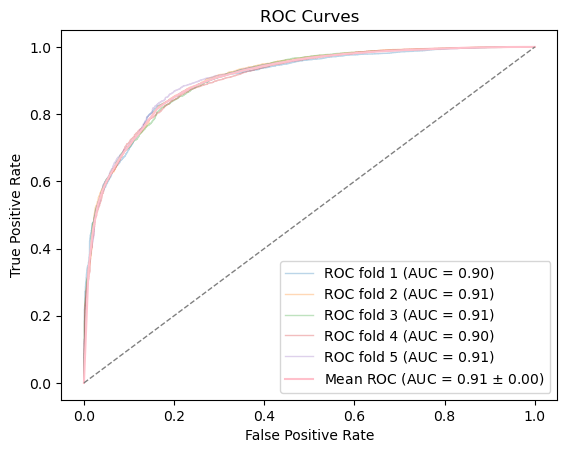

for multi- layer perceptron model, with: drop categorical and select features AUROC = 0.908


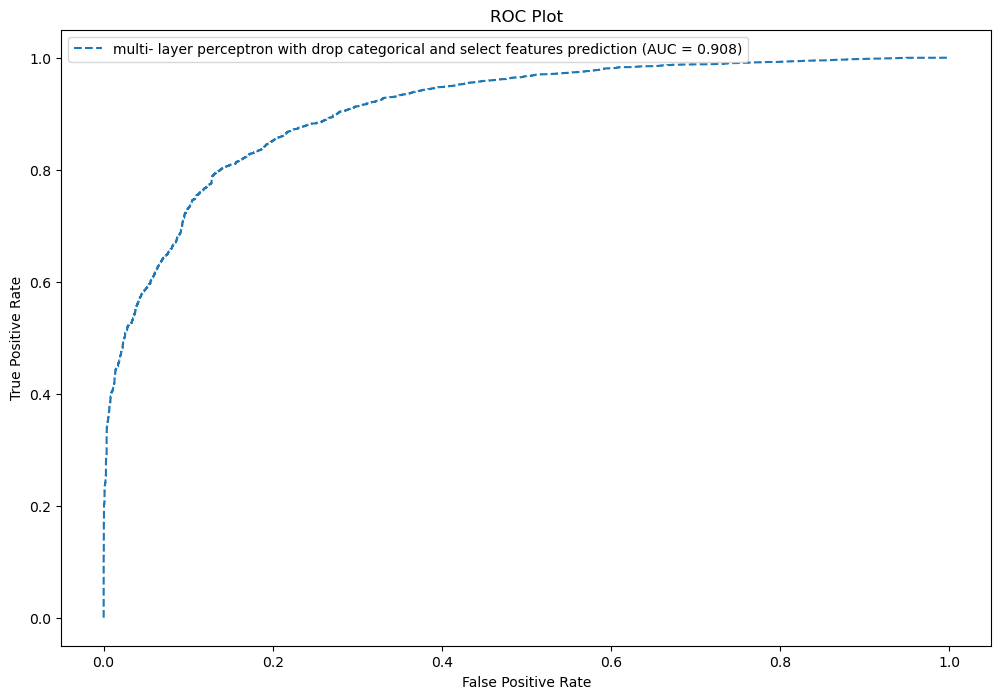

done function
number of layers: 3
layer sizes: [(11, 100), (100, 1)]
layer bias sizes: [(100,), (1,)]
final loss reached in training: 0.36606379774307785
best loss reached in training: None
accuracy on test set: 0.8284166666666667
Iteration 1, loss = 0.52606418
Validation score: 0.799219
Iteration 1, loss = 0.42304434
Validation score: 0.836458
Iteration 1, loss = 0.52822157
Validation score: 0.786458
Iteration 1, loss = 0.52789953
Validation score: 0.788802
Iteration 1, loss = 0.52496875
Validation score: 0.784635
Iteration 1, loss = 0.52636070
Iteration 1, loss = 0.42411199
Validation score: 0.782292
Iteration 1, loss = 0.42625093
Validation score: 0.836198
Validation score: 0.828385
Iteration 2, loss = 0.36903278
Validation score: 0.845052
Iteration 2, loss = 0.45597303
Validation score: 0.807552
Iteration 2, loss = 0.45818593
Iteration 2, loss = 0.45785704
Validation score: 0.806250
Validation score: 0.804167
Iteration 2, loss = 0.45518312
Validation score: 0.804167
Iteration 2, lo

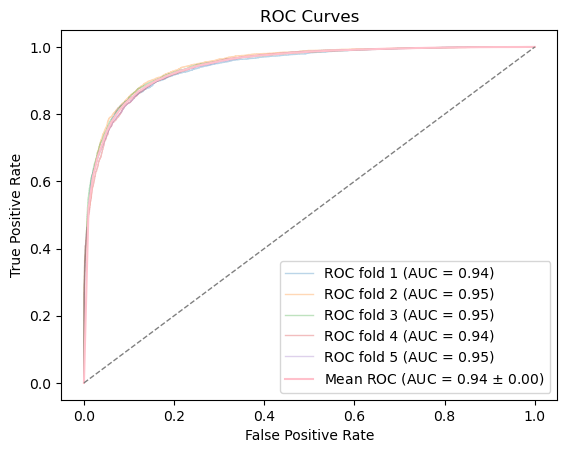

for multi- layer perceptron model, with: no feature selection and pca AUROC = 0.951


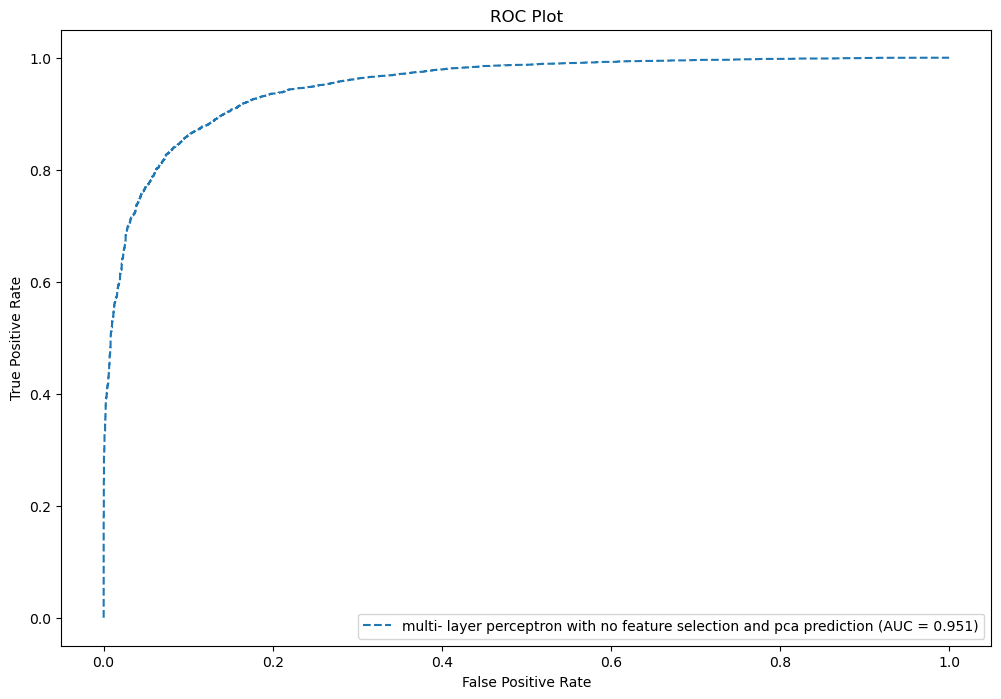

done function
number of layers: 3
layer sizes: [(21, 100), (100, 1)]
layer bias sizes: [(100,), (1,)]
final loss reached in training: 0.23114670282633423
best loss reached in training: None
accuracy on test set: 0.8785833333333334


In [285]:

multi_layer_perceptron(X_train_selected , y_train, X_test_selected,  y_test, 'encoding categorical features and selecting features')
multi_layer_perceptron( X_train_full, y_train , X_test_full, y_test, 'no feature selection' )
multi_layer_perceptron(X_train_selected_drop , y_train, X_test_selected_drop, y_test, 'drop categorical and select features')
multi_layer_perceptron( X_train_full_pca, y_train , X_test_full_pca, y_test, 'no feature selection and pca' )


## Decision Tree


    Althogh we reached AUC above 0.9 with this model, we choose not to use it because the other 2 in this category are even better!

In [286]:
#add gridsearch
#decision tree
def decision_tree(X_train, y_train, X_test, y_test, method):
    clf_dt = DecisionTreeClassifier(max_depth=10)
    #fit with k-fold
    proba = fit_with_kfold_get_roc2(clf_dt, X_train, y_train ,X_test)
    get_AUC(proba, y_test , 'decision tree'  , method)
    get_ROC(proba, y_test , 'decision tree'  , method)


the TP represent that we predict the file will be malicious, and indeed its malicious. the FP represent that we predict that the file will be malicious but its benign. the FN represent that we predict that the file will be benign but its malicious .he TN represent that we predict the file will be benign, and indeed its benign. all the 4 matrix gave similar results, and as we expected the TP and the TN represents most of the files wich leads to good scores(recall, accuracy, precision)

## Random Forest

    We chose this model for the test run!

    also added the confusion matrix

In [287]:

def random_forest(X_train, y_train, X_test, y_test, method):
    
    parameters = {
        'n_estimators': [300],
        'max_depth': [10, 15],
        'criterion': ['entropy','gini']}
       
    
    rf = RandomForestClassifier(random_state=42)
    #perform gridsearch for best hyperparameters.
    gscv_rf = GridSearchCV(rf, parameters, scoring='roc_auc', n_jobs=-1)
    gscv_rf.fit(X_train, y_train)
    
    best_params_rf = gscv_rf.best_params_
    rf_opt = gscv_rf.best_estimator_
    rf_opt2 = RandomForestClassifier(**best_params_rf, random_state=42)
    print(f'Best Params: {best_params_rf} \n')

    #k fold fit
    fit_with_kfold_get_roc(rf_opt2, X_train, y_train)
    proba = rf_opt.predict_proba(X_test)
    get_AUC(proba, y_test , 'decision tree'  , method)
    get_ROC(proba, y_test , 'decision tree'  , method)  
    test_predict = rf_opt.predict(X_test)
    #confusion matrix
    create_confusion_matrix(y_test, test_predict)  
    return 




Best Params: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 300} 



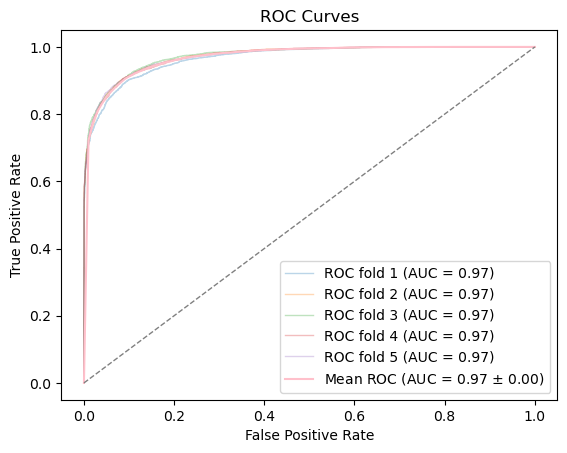

for decision tree model, with: encoding categorical features and selecting features AUROC = 0.973


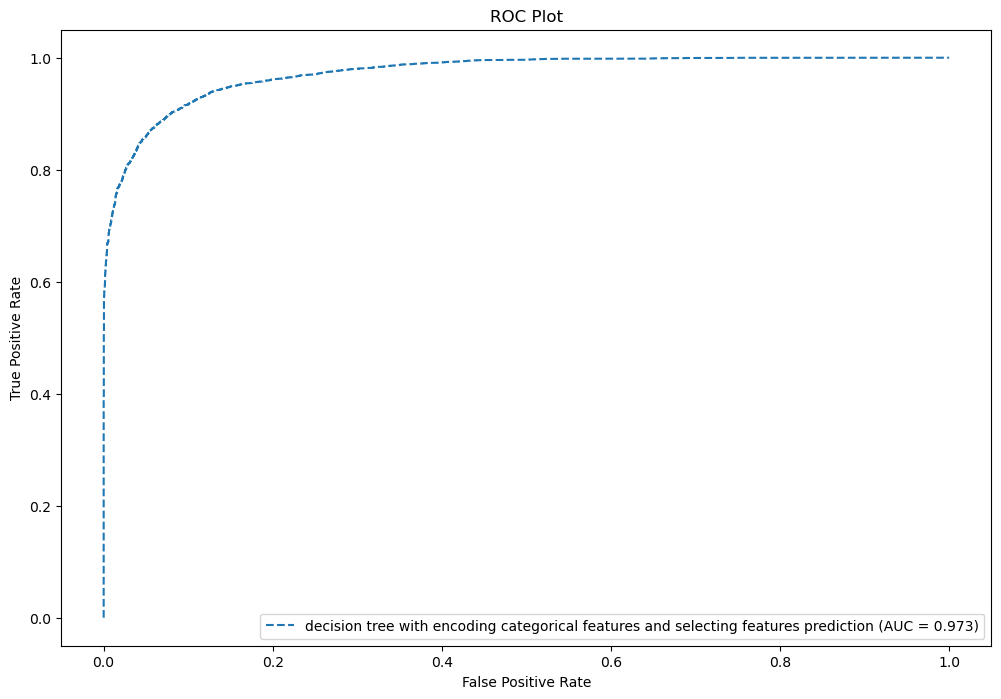

True Positives (TP): 5528
False Positives (FP): 487
True Negatives (TN): 5402
False Negatives (FN): 583
recall\sensitivity: 0.9045982654230077
precision: 0.9190357439733998
accuracy: 0.9108333333333334


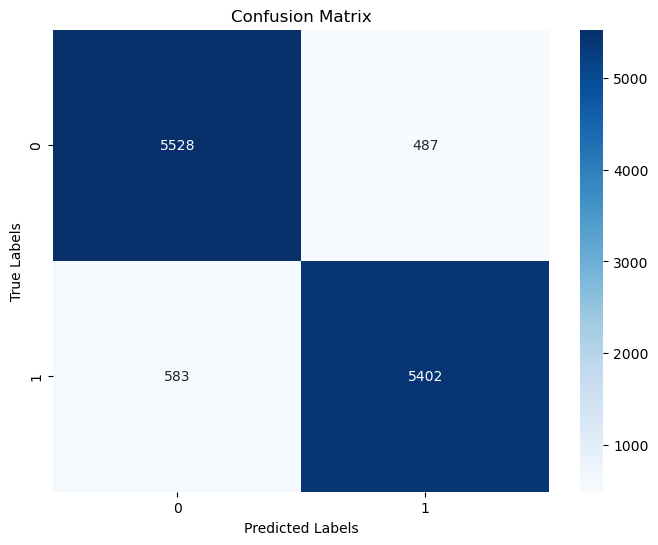

Best Params: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 300} 



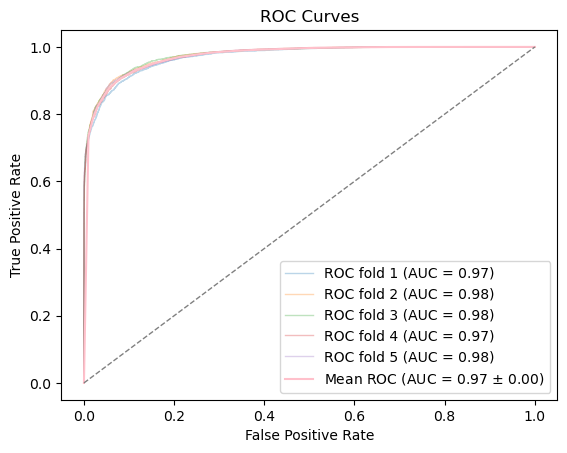

for decision tree model, with: no feature selection AUROC = 0.976


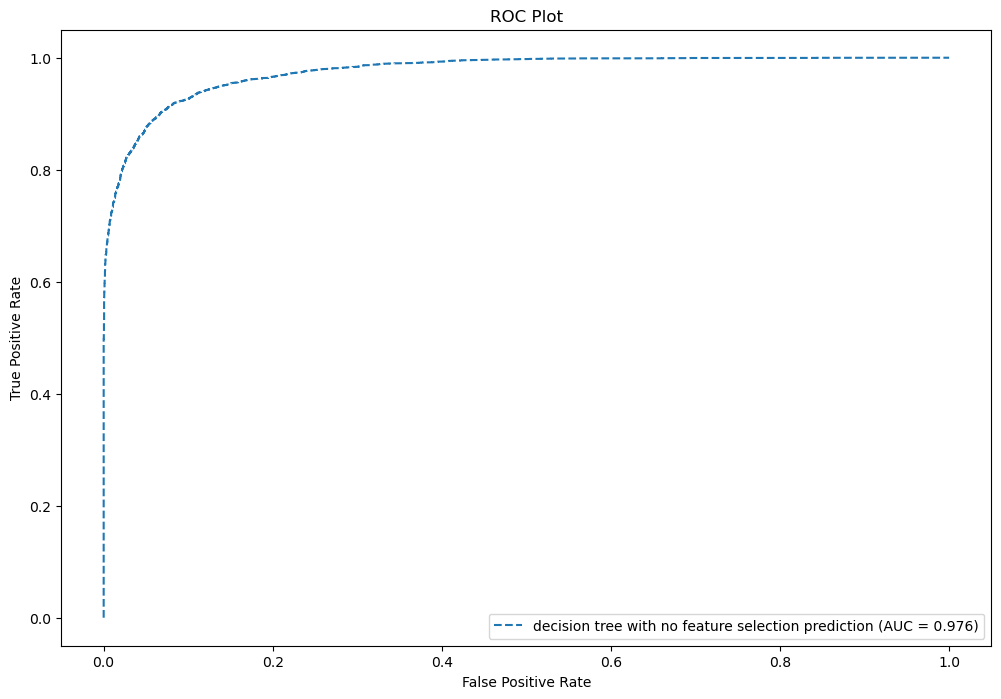

True Positives (TP): 5557
False Positives (FP): 458
True Negatives (TN): 5456
False Negatives (FN): 529
recall\sensitivity: 0.9130791981597108
precision: 0.9238570241064007
accuracy: 0.91775


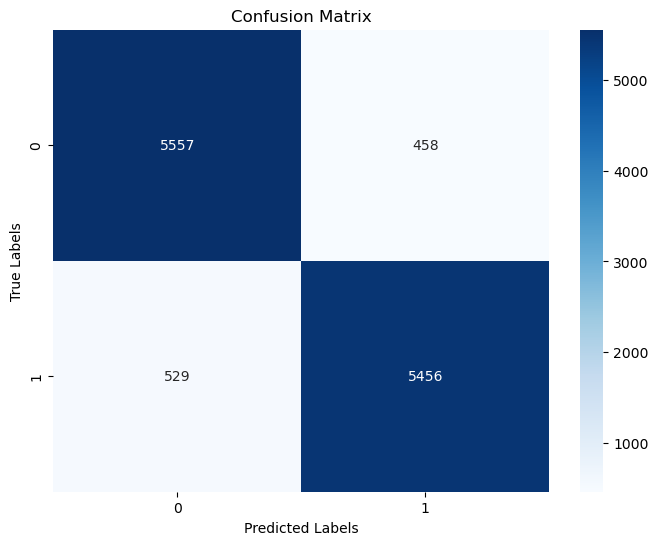

Best Params: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 300} 



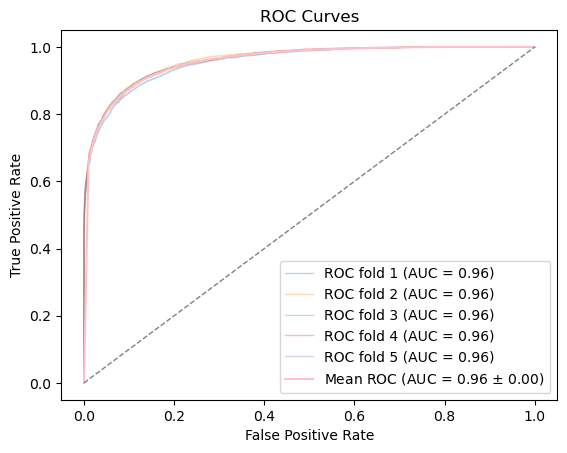

for decision tree model, with: drop categorical and select features AUROC = 0.961


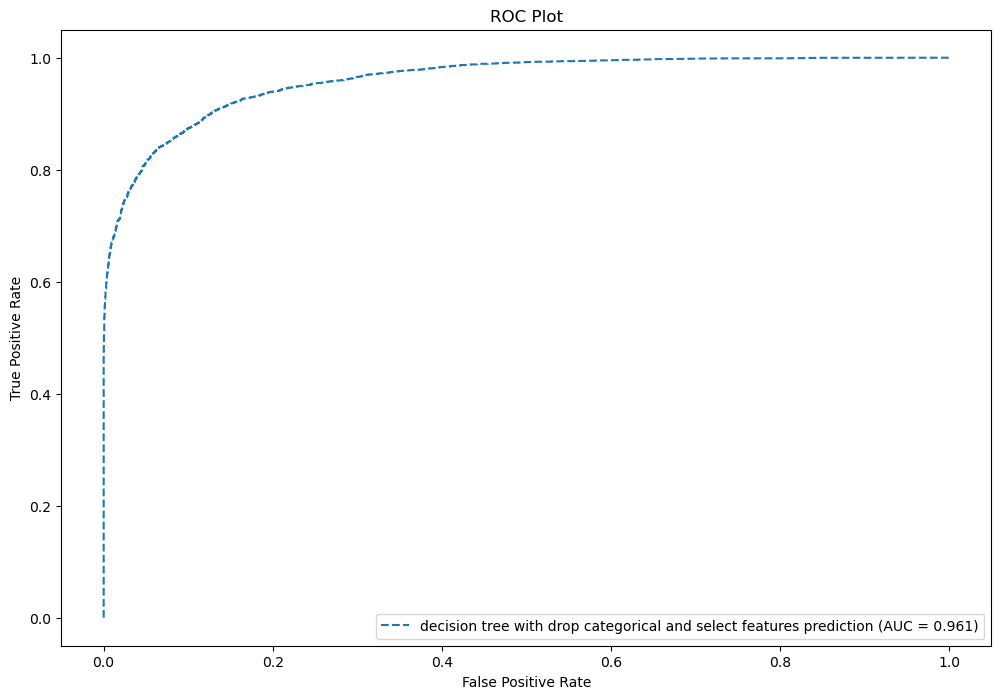

True Positives (TP): 5448
False Positives (FP): 567
True Negatives (TN): 5189
False Negatives (FN): 796
recall\sensitivity: 0.8725176169122357
precision: 0.9057356608478803
accuracy: 0.8864166666666666


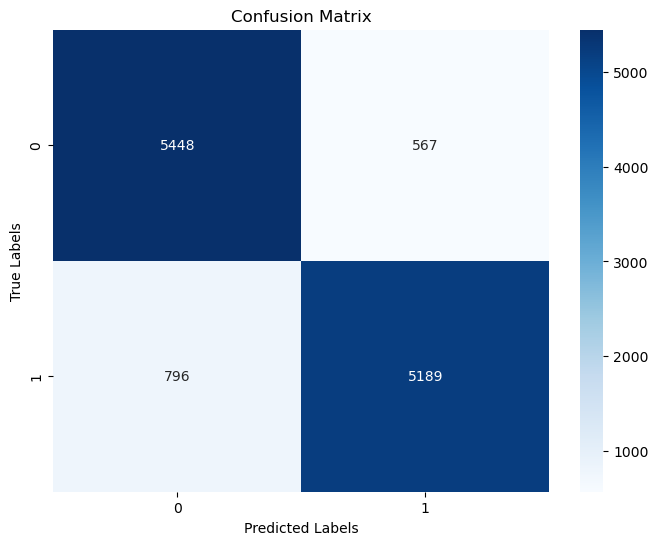

Best Params: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 300} 



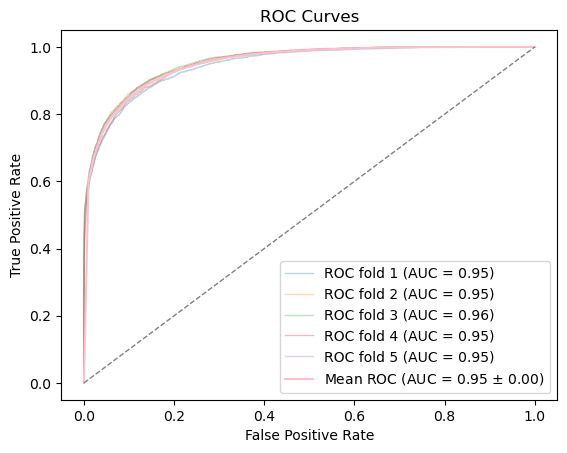

for decision tree model, with: no feature selection and pca AUROC = 0.955


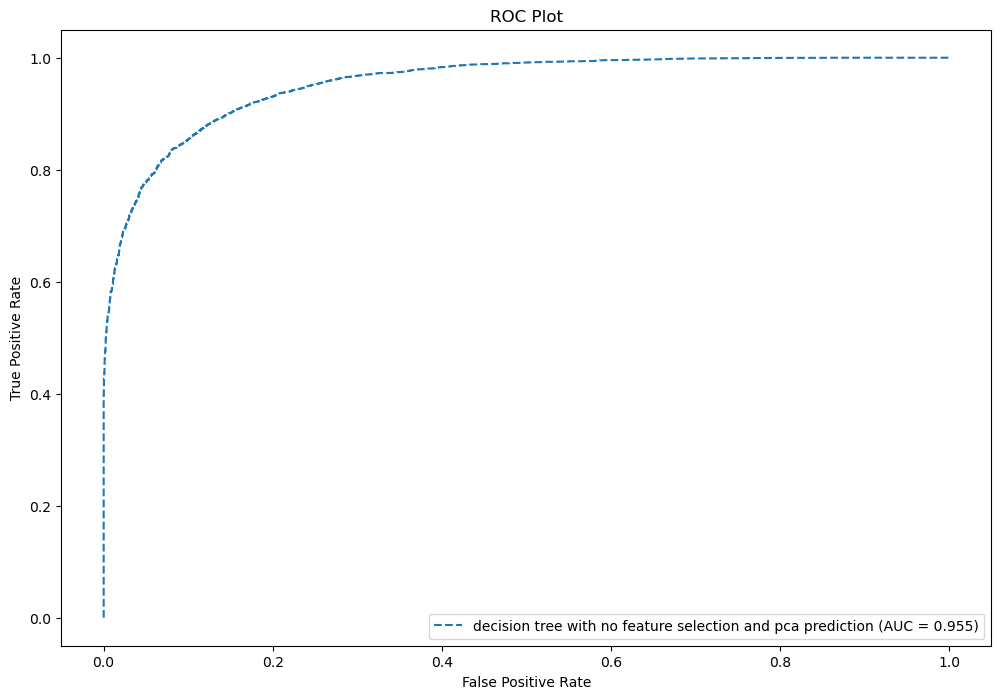

True Positives (TP): 5272
False Positives (FP): 743
True Negatives (TN): 5270
False Negatives (FN): 715
recall\sensitivity: 0.8805745782528812
precision: 0.8764754779717373
accuracy: 0.8785


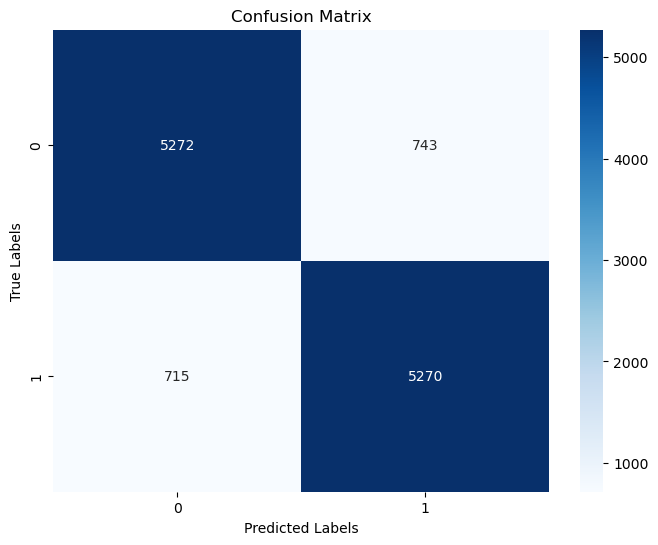

In [288]:

random_forest(X_train_selected , y_train, X_test_selected,  y_test, 'encoding categorical features and selecting features')
random_forest( X_train_full, y_train , X_test_full, y_test, 'no feature selection' )
random_forest(X_train_selected_drop , y_train, X_test_selected_drop, y_test, 'drop categorical and select features')

random_forest( X_train_full_pca, y_train , X_test_full_pca, y_test, 'no feature selection and pca' )


## Final model for test run

In [293]:

def random_forest_final(X_train, y_train, X_test, method):
    
    parameters = {
        'n_estimators': [300],
        'max_depth': [10, 15],
        'criterion': ['entropy','gini']}
       
    rf = RandomForestClassifier(random_state=42)
    #perform gridsearch for best hyperparameters.
    gscv_rf = GridSearchCV(rf, parameters, scoring='roc_auc', n_jobs=-1)
    gscv_rf.fit(X_train, y_train)
    
    best_params_rf = gscv_rf.best_params_
    rf_opt = gscv_rf.best_estimator_
    rf_opt2 = RandomForestClassifier(**best_params_rf, random_state=42)
    print(f'Best Params: {best_params_rf} \n')
    print('Random Forest with no feature selection')
    #k fold fit
    fit_with_kfold_get_roc(rf_opt2, X_train, y_train)
    proba = rf_opt.predict_proba(X_test) 
    return proba


## Pipeline

reducing to 6 values means 2 different values in 2653 rows will be classified as other,
 losing 4.42 precent of the data 
 the most common value is NONE_VAL with 2051 rows
reducing to 30 values means 59 different values in 805 rows will be classified as other,
 losing 1.34 precent of the data 
 the most common value is Microsoft Resource Library (x86) with 78 rows


/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/304819278.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_features_train.iloc[:,:] = imputer.fit_transform(numeric_features_train)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/304819278.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  numeric_features_train.iloc[:,:] = imputer.fit_transform(numeric_features_train)
/var/folders/vf/mj3hntp128x3jmj8cz5p4ywh0000gn/T/ipykernel_43234/304819278.py:11: SettingWithCopyWarning: 
A valu

Best Params: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 300} 

Random Forest with no feature selection


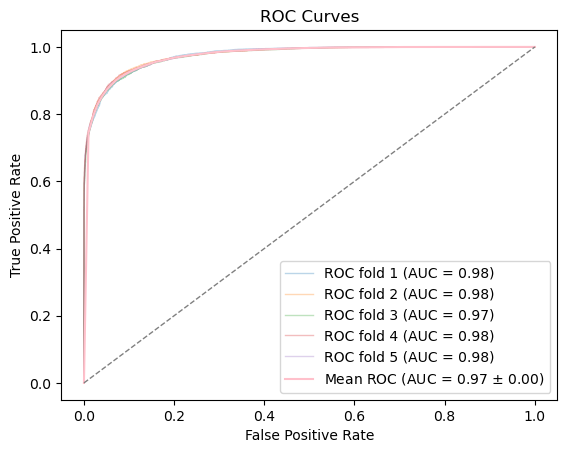

done test run!


In [297]:
def pipeline(train_name_csv, test_name_csv):

    train, X_test = read_csv(train_name_csv, test_name_csv)

    ids = X_test['sha256'].copy()

    X_train_n = train.drop('label', axis=1)
    y_train = train['label']

    drop_sha(X_train_n, X_test)   
    categorical, numeric, binary = create_subgroups()

    null_removing_categorical (X_train_n, X_test, categorical)
    X_train_n, X_test = reduce_to_top_k_indices(X_train_n,  X_test , 'C', 6, True)
    X_train_n, X_test = reduce_to_top_k_indices(X_train_n,  X_test , 'file_type_trid', 30, True)

    X_train_n, X_test = num_null_handling(X_train_n , X_test, numeric)

    null_handling_binary(X_train_n , X_test,binary)

    handel_outliers_numeric(X_train_n, X_test)

    #two metodes to handel categorical features
    #only numeric
    X_train_drop_cat , X_test_drop_cat = drop_categorical_features(X_train_n, X_test, categorical)
    #only categorical
    X_train_cat_ordinal ,X_test_cat_ordinal = ordinal_encode_categorical_f(X_train_n, X_test , numeric)
    
   
    #no feature selection
    X_train_full , X_test_full = concat_x_selected(X_train_drop_cat, X_train_cat_ordinal,X_test_drop_cat, X_test_cat_ordinal)

    X_train_full , X_test_full = scaling_data(X_train_full , X_test_full)
   
    proba = random_forest_final( X_train_full, y_train , X_test_full, 'no feature selection' )
    prediction = proba[:,1]
    test_output = pd.DataFrame({'sha256':ids, 'proba': prediction})
    test_output.to_csv('results_24.csv', index= False)

    print('done test run!')

    return

   
pipeline('train.csv', 'test.csv')
